# ***DATA LOADING***

In [1]:
!nvidia-smi    # ensuring whether the terminal is connected to GPU

Thu Aug  8 21:19:02 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Importing the drive modules, giving the appropriate path where I have kept my dataset.

# Please comment out this part while running..

from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/SimplyBusiness')

Mounted at /content/drive


In [3]:
# Importing all the necessary libraries required for model running...

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import numpy as np



warnings.filterwarnings('ignore')

In [ ]:
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel


from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt, seaborn as sb

In [4]:
# Loading the dataset which has been scraped from the decision files..

df = pd.read_csv('updated_final_merged_df.csv')

In [5]:
df # Visualising the dataframe

decision_id                  location                           title  \
0        DRN7934249   decision/DRN7934249.pdf   Decision Reference DRN7934249   
1        DRN0343895   decision/DRN0343895.pdf   Decision Reference DRN0343895   
2        DRN6179184   decision/DRN6179184.pdf   Decision Reference DRN6179184   
3        DRN0098468   decision/DRN0098468.pdf   Decision Reference DRN0098468   
4        DRN9420247   decision/DRN9420247.pdf   Decision Reference DRN9420247   
...             ...                       ...                             ...   
160792  DRN-4229415  decision/DRN-4229415.pdf  Decision Reference DRN-4229415   
160793  DRN-4001454  decision/DRN-4001454.pdf  Decision Reference DRN-4001454   
160794  DRN-4248624  decision/DRN-4248624.pdf  Decision Reference DRN-4248624   
160795  DRN-4222353  decision/DRN-4222353.pdf  Decision Reference DRN-4222353   
160796  DRN-4247561  decision/DRN-4247561.pdf  Decision Reference DRN-4247561   

               date                                company    decision  \
0       15 Jul 2014                   Bank of Scotland Plc  Not upheld   
1       15 Jul 2014            Nationwide Building Society  Not upheld   
2       15 Jul 2014                        Lloyds Bank PLC      Upheld   
3       15 Jul 2014                    Anglian Windows Ltd      Upheld   
4       15 Jul 2014                   Bank of Scotland Plc  Not upheld   
...             ...                                    ...         ...   
160792  17 Jul 2023                    Covea Insurance plc  Not upheld   
160793  17 Jul 2023                               Unum Ltd  Not upheld   
160794  17 Jul 2023                   AXA Insurance UK Plc      Upheld   
160795  17 Jul 2023      Skyfire Insurance Company Limited  Not upheld   
160796  16 Jul 2023  Lloyds Bank General Insurance Limited      Upheld   

        extras                                 tag  \
0          NaN  Payment protection insurance (PPI)   
1          NaN  Payment protection insurance (PPI)   
2          NaN  Payment protection insurance (PPI)   
3          NaN  Payment protection insurance (PPI)   
4          NaN  Payment protection insurance (PPI)   
...        ...                                 ...   
160792     NaN                           Insurance   
160793     NaN                           Insurance   
160794     NaN                           Insurance   
160795     NaN                           Insurance   
160796     NaN                           Insurance   

                                           Complaint_Info  \
0       This complaint concerns a mortgage payment pro...   
1       This complaint concerns a regular premium paym...   
2       This complaint concerns a regular premium paym...   
3       Mr L and Miss M have complained that they were...   
4       This complaint concerns a regular mortgage pay...   
...                                                   ...   
160792  A limited company, which I will call L, has co...   
160793  Mr S complains that Unum Ltd has turned down a...   
160794  Ms M complains that AXA Insurance UK Plc unfai...   
160795  Ms M complains about Skyfire Insurance Company...   
160796  Mr F and Mrs F complain about Lloyds Bank Gene...   

                                    Complaint_Explanation  \
0       Our adjudicator considered that this complaint...   
1       Our adjudicator considered Mrs T’s complaint a...   
2       The background to this complaint was set out i...   
3       Mr L and Miss M took out a loan with Anglian W...   
4       An adjudicator at this service has considered ...   
...                                                   ...   
160792  L is a restaurant. L contacted Covea to make a...   
160793  The background to this complaint is well-known...   
160794  Ms M had home insurance that was underwritten ...   
160795  Ms M held a motor insurance policy, underwritt...   
160796  Mr F and Mrs F have owned their home for aroun...   

                               

# ***PREPROCESSING THE DATA***

In [6]:
# Printing the shape of the dataframe.
df.shape

(160797, 12)

In [7]:
# Printing the columns of the dataframe.
df.columns

Index(['decision_id', 'location', 'title', 'date', 'company', 'decision',
       'extras', 'tag', 'Complaint_Info', 'Complaint_Explanation',
       'Decision_Taken_And_Reason', 'Final_Decision'],
      dtype='object')

In [8]:
# Printing out the number of unique values present in every feature column..

df.nunique()

decision_id                  160433
location                     160433
title                        160433
date                           3105
company                        2653
decision                          2
extras                            0
tag                               3
Complaint_Info               142111
Complaint_Explanation        142038
Decision_Taken_And_Reason    157689
Final_Decision               160100
dtype: int64

In [9]:
df.isnull().sum() #  Checking for NULL values..

decision_id                       0
location                          0
title                             0
date                              0
company                           0
decision                          0
extras                       160797
tag                               0
Complaint_Info                  273
Complaint_Explanation         14251
Decision_Taken_And_Reason      1711
Final_Decision                  133
dtype: int64

In [10]:
df.drop('extras', axis=1, inplace=True)  # Dropping the NULL column..

In [11]:
df.isnull().sum()

decision_id                      0
location                         0
title                            0
date                             0
company                          0
decision                         0
tag                              0
Complaint_Info                 273
Complaint_Explanation        14251
Decision_Taken_And_Reason     1711
Final_Decision                 133
dtype: int64

In [12]:
df.shape

(160797, 11)

In [13]:
# Find duplicate rows, keeping the first occurrence
duplicates = df.duplicated(keep='first')

# Get the duplicate rows
duplicate_rows = df[duplicates]
len(duplicate_rows)

364

In [14]:
df = df.drop_duplicates(keep='first')

In [15]:
df.shape

(160433, 11)

In [16]:
df.nunique()

decision_id                  160433
location                     160433
title                        160433
date                           3105
company                        2653
decision                          2
tag                               3
Complaint_Info               142111
Complaint_Explanation        142038
Decision_Taken_And_Reason    157689
Final_Decision               160100
dtype: int64

In [17]:
df.decision_id.value_counts() # Ensuring the value counts equal to one across every deicision id present..

decision_id
DRN-4247561    1
DRN7934249     1
DRN0343895     1
DRN6179184     1
DRN0098468     1
              ..
DRN8734933     1
DRN2651854     1
DRN6832153     1
DRN2529015     1
DRN7210654     1
Name: count, Length: 160433, dtype: int64

In [18]:
#  Printing the records where both first two columns have no information on them (information on what the complaint is about is absent).

df[pd.isna(df['Complaint_Info']) & pd.isna(df['Complaint_Explanation'])].shape

(85, 11)

In [19]:
'''
REASONS BEHIND THE BELOW PREPROCESSING WORK

-> COMPLAINT_INFO and Complaint_Explanation are two columns which captures the first two sections from every pdf document parsed..
-> this would give us an idea on what the complaint is all about with regards to a detailed explanation..
-> We are checking for the records where there are NULL values present on both the columns...
-> as these records wont be useful in the modeling purpose and the size is way lesser as compared to the original size..
-> thus removing those records..

'''


'\nREASONS BEHIND THE BELOW PREPROCESSING WORK\n\n-> COMPLAINT_INFO and Complaint_Explanation are two columns which captures the first two sections from every pdf document parsed..\n-> this would give us an idea on what the complaint is all about with regards to a detailed explanation..\n-> We are checking for the records where there are NULL values present on both the columns...\n-> as these records wont be useful in the modeling purpose and the size is way lesser as compared to the original size..\n-> thus removing those records..\n\n'

In [20]:
df = df[~(pd.isna(df['Complaint_Info']) & pd.isna(df['Complaint_Explanation']))] # Removing those records as they are of no use to us..

In [21]:
# Filling the remaining NULL values with whitespace..

df['Complaint_Info'] = df['Complaint_Info'].fillna('')
df['Complaint_Explanation'] = df['Complaint_Explanation'].fillna('')
df['Decision_Taken_And_Reason'] = df['Decision_Taken_And_Reason'].fillna('')
df['Final_Decision'] = df['Final_Decision'].fillna('')

In [22]:
df.shape

(160348, 11)

In [23]:
df.isnull().sum()

decision_id                  0
location                     0
title                        0
date                         0
company                      0
decision                     0
tag                          0
Complaint_Info               0
Complaint_Explanation        0
Decision_Taken_And_Reason    0
Final_Decision               0
dtype: int64

In [24]:
# Presence of provisional decision content is found out on the complaint summary section
# Therefore those are scraped out of the dataframe and the content is placed into another feature column.
# Performing modeling on the input data which encompasses information on what the decision is about and the ombudsman findings is not ideal
# Thus, we process and scrape the content..

def extract_provisional_decision(text):
    keyword = "provisional decision"
    if keyword in text.lower():
        split_text = re.split(keyword, text, 1,flags=re.IGNORECASE)
        return split_text[0].strip(), split_text[1].strip() if len(split_text) > 1 else ""
    return text, ""

In [25]:
# Apply the function to the DataFrame
df[['Complaint_Explanation', 'provisional_decision']] = df['Complaint_Explanation'].apply(lambda x: pd.Series(extract_provisional_decision(x)))

In [26]:
df[df['provisional_decision'] != ''].shape

(22308, 12)

In [27]:
df[pd.isna(df['Decision_Taken_And_Reason']) & pd.isna(df['Final_Decision'])].shape

(0, 12)

In [28]:
df[['date']]

date
0       15 Jul 2014
1       15 Jul 2014
2       15 Jul 2014
3       15 Jul 2014
4       15 Jul 2014
...             ...
160792  17 Jul 2023
160793  17 Jul 2023
160794  17 Jul 2023
160795  17 Jul 2023
160796  16 Jul 2023

[160348 rows x 1 columns]

In [29]:
df['date'] = pd.to_datetime(df['date'], format='%d %b %Y', errors='coerce')

In [30]:
df[['date']]

date
0      2014-07-15
1      2014-07-15
2      2014-07-15
3      2014-07-15
4      2014-07-15
...           ...
160792 2023-07-17
160793 2023-07-17
160794 2023-07-17
160795 2023-07-17
160796 2023-07-16

[160348 rows x 1 columns]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160348 entries, 0 to 160796
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   decision_id                160348 non-null  object        
 1   location                   160348 non-null  object        
 2   title                      160348 non-null  object        
 3   date                       160348 non-null  datetime64[ns]
 4   company                    160348 non-null  object        
 5   decision                   160348 non-null  object        
 6   tag                        160348 non-null  object        
 7   Complaint_Info             160348 non-null  object        
 8   Complaint_Explanation      160348 non-null  object        
 9   Decision_Taken_And_Reason  160348 non-null  object        
 10  Final_Decision             160348 non-null  object        
 11  provisional_decision       160348 non-null  object       

## TEXT PREPROCESSING

In [33]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [34]:
# Lemmatization, removing punctuation marks, stopwords, special characters are performed below
# as a part of text preprocessing..

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
additional_stopwords = {'mr', 'mrs','Mr','Mrs'}

In [36]:
def clean_and_preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in additional_stopwords]
    # Remove special characters and extra whitespace
    tokens = [re.sub(r'\W+', '', word) for word in tokens]
    tokens = [word for word in tokens if word.strip() != '']
    return ' '.join(tokens)

In [35]:
text_columns = ['Complaint_Info','Complaint_Explanation', 'Decision_Taken_And_Reason', 'Final_Decision']

In [40]:
new_df = df.copy()

In [41]:
# New dataframe is created from the existing dataframe where the processed text data goes into the new dataframe
# later stages, this is the dataframe which we are going to use everywhere...

for column in text_columns:
    new_df[column] = df[column].apply(lambda x: clean_and_preprocess_text(str(x)))

In [42]:
df['Complaint_Info'].iloc[4]

'This complaint concerns a regular mortgage payment protection insurance (MPPI) policy, taken out in 1999 in conjunction with a mortgage. The mortgage was taken out jointly but the MPPI provided single cover for Mr T. Mr and Mrs T say that Bank of Scotland plc, trading as Halifax (“Halifax”) mis-sold the policy.'

In [43]:
new_df['Complaint_Info'].iloc[4]

'complaint concern regular mortgage payment protection insurance mppi policy taken conjunction mortgage mortgage taken jointly mppi provided single cover say bank scotland plc trading halifax halifax missold policy'

In [44]:
df['Complaint_Explanation'].iloc[6]

'Miss J took out a loan for new windows with Anglian Windows in March 2006, and alongside this she took out a PPI policy. It is not in dispute that the sale took place during a meeting, or that Miss J was advised to take out the policy. Miss J complained that she was pressured into taking an inappropriate loan and insurance and that she was not eligible for the insurance. This was a single premium policy, the cost being added to the loan and repayable over the term of the loan (ten years). However the policy provided cover for five years. An adjudicator at this service considered that Miss J’s complaint should not be upheld; Miss J disagreed and asked that it be referred to an ombudsman for review.'

In [45]:
new_df['Complaint_Explanation'].iloc[6]

'miss j took loan new window anglian window march alongside took ppi policy dispute sale took place meeting miss j advised take policy miss j complained pressured taking inappropriate loan insurance eligible insurance single premium policy cost added loan repayable term loan ten year however policy provided cover five year adjudicator service considered miss j complaint upheld miss j disagreed asked referred ombudsman review'

In [46]:
new_df.shape

(160348, 12)

In [47]:
complaint_columns = ['Complaint_Info','Complaint_Explanation']

In [48]:
new_df['complaint_data'] = new_df[complaint_columns].apply(lambda x: ' '.join(x), axis=1)

In [49]:
new_df['Complaint_Info'].iloc[0]

'complaint concern mortgage payment protection insurance ppi policy taken march r say bank scotland plc trading halifax halifax mi sold policy'

In [50]:
new_df['Complaint_Explanation'].iloc[0]

'adjudicator considered complaint upheld wrote r explaining reasoning r rejected view asked complaint reviewed ombudsman addressed decision r joint mortgage therefore joint decision proceed mortgage ppi policy taken r sole name'

In [51]:
new_df['complaint_data'].iloc[0]

'complaint concern mortgage payment protection insurance ppi policy taken march r say bank scotland plc trading halifax halifax mi sold policy adjudicator considered complaint upheld wrote r explaining reasoning r rejected view asked complaint reviewed ombudsman addressed decision r joint mortgage therefore joint decision proceed mortgage ppi policy taken r sole name'

# ***EXPLORATORY DATA ANALYSIS (EDA)***

## ***ORGANIZATION ANALYSIS***

In [53]:
# It is found out that SimplyBusiness operates on a different name called 'Xbridge Limited'
# Therefore identifying the number of records and printing them out...
# The number aggregates to over 36 records with 20 upheld cases and 16 not upheld cases...

new_df[new_df['company'] == 'Xbridge Limited'].shape

(36, 13)

In [54]:
new_df.columns

Index(['decision_id', 'location', 'title', 'date', 'company', 'decision',
       'tag', 'Complaint_Info', 'Complaint_Explanation',
       'Decision_Taken_And_Reason', 'Final_Decision', 'provisional_decision',
       'complaint_data'],
      dtype='object')

In [55]:
new_df.company.nunique() # Printing out the number of unique companies present..

2652

In [56]:
# Get the top 10 companies with the highest number of records
company_counts = new_df['company'].value_counts().head(10).reset_index()
company_counts.columns = ['company', 'count']

In [57]:
company_counts # Displaying the top 10 companies alongside their complaint count over the timeline..

company  count
0                 Bank of Scotland Plc  15714
1                      Lloyds Bank PLC   9325
2          Nationwide Building Society   6369
3                    Barclays Bank Plc   6022
4                        HSBC Bank plc   5805
5             Capital One (Europe) plc   5496
6              Aviva Insurance Limited   4058
7                 UK Insurance Limited   3725
8  Financial Insurance Company Limited   3649
9                 AXA Insurance UK Plc   3112

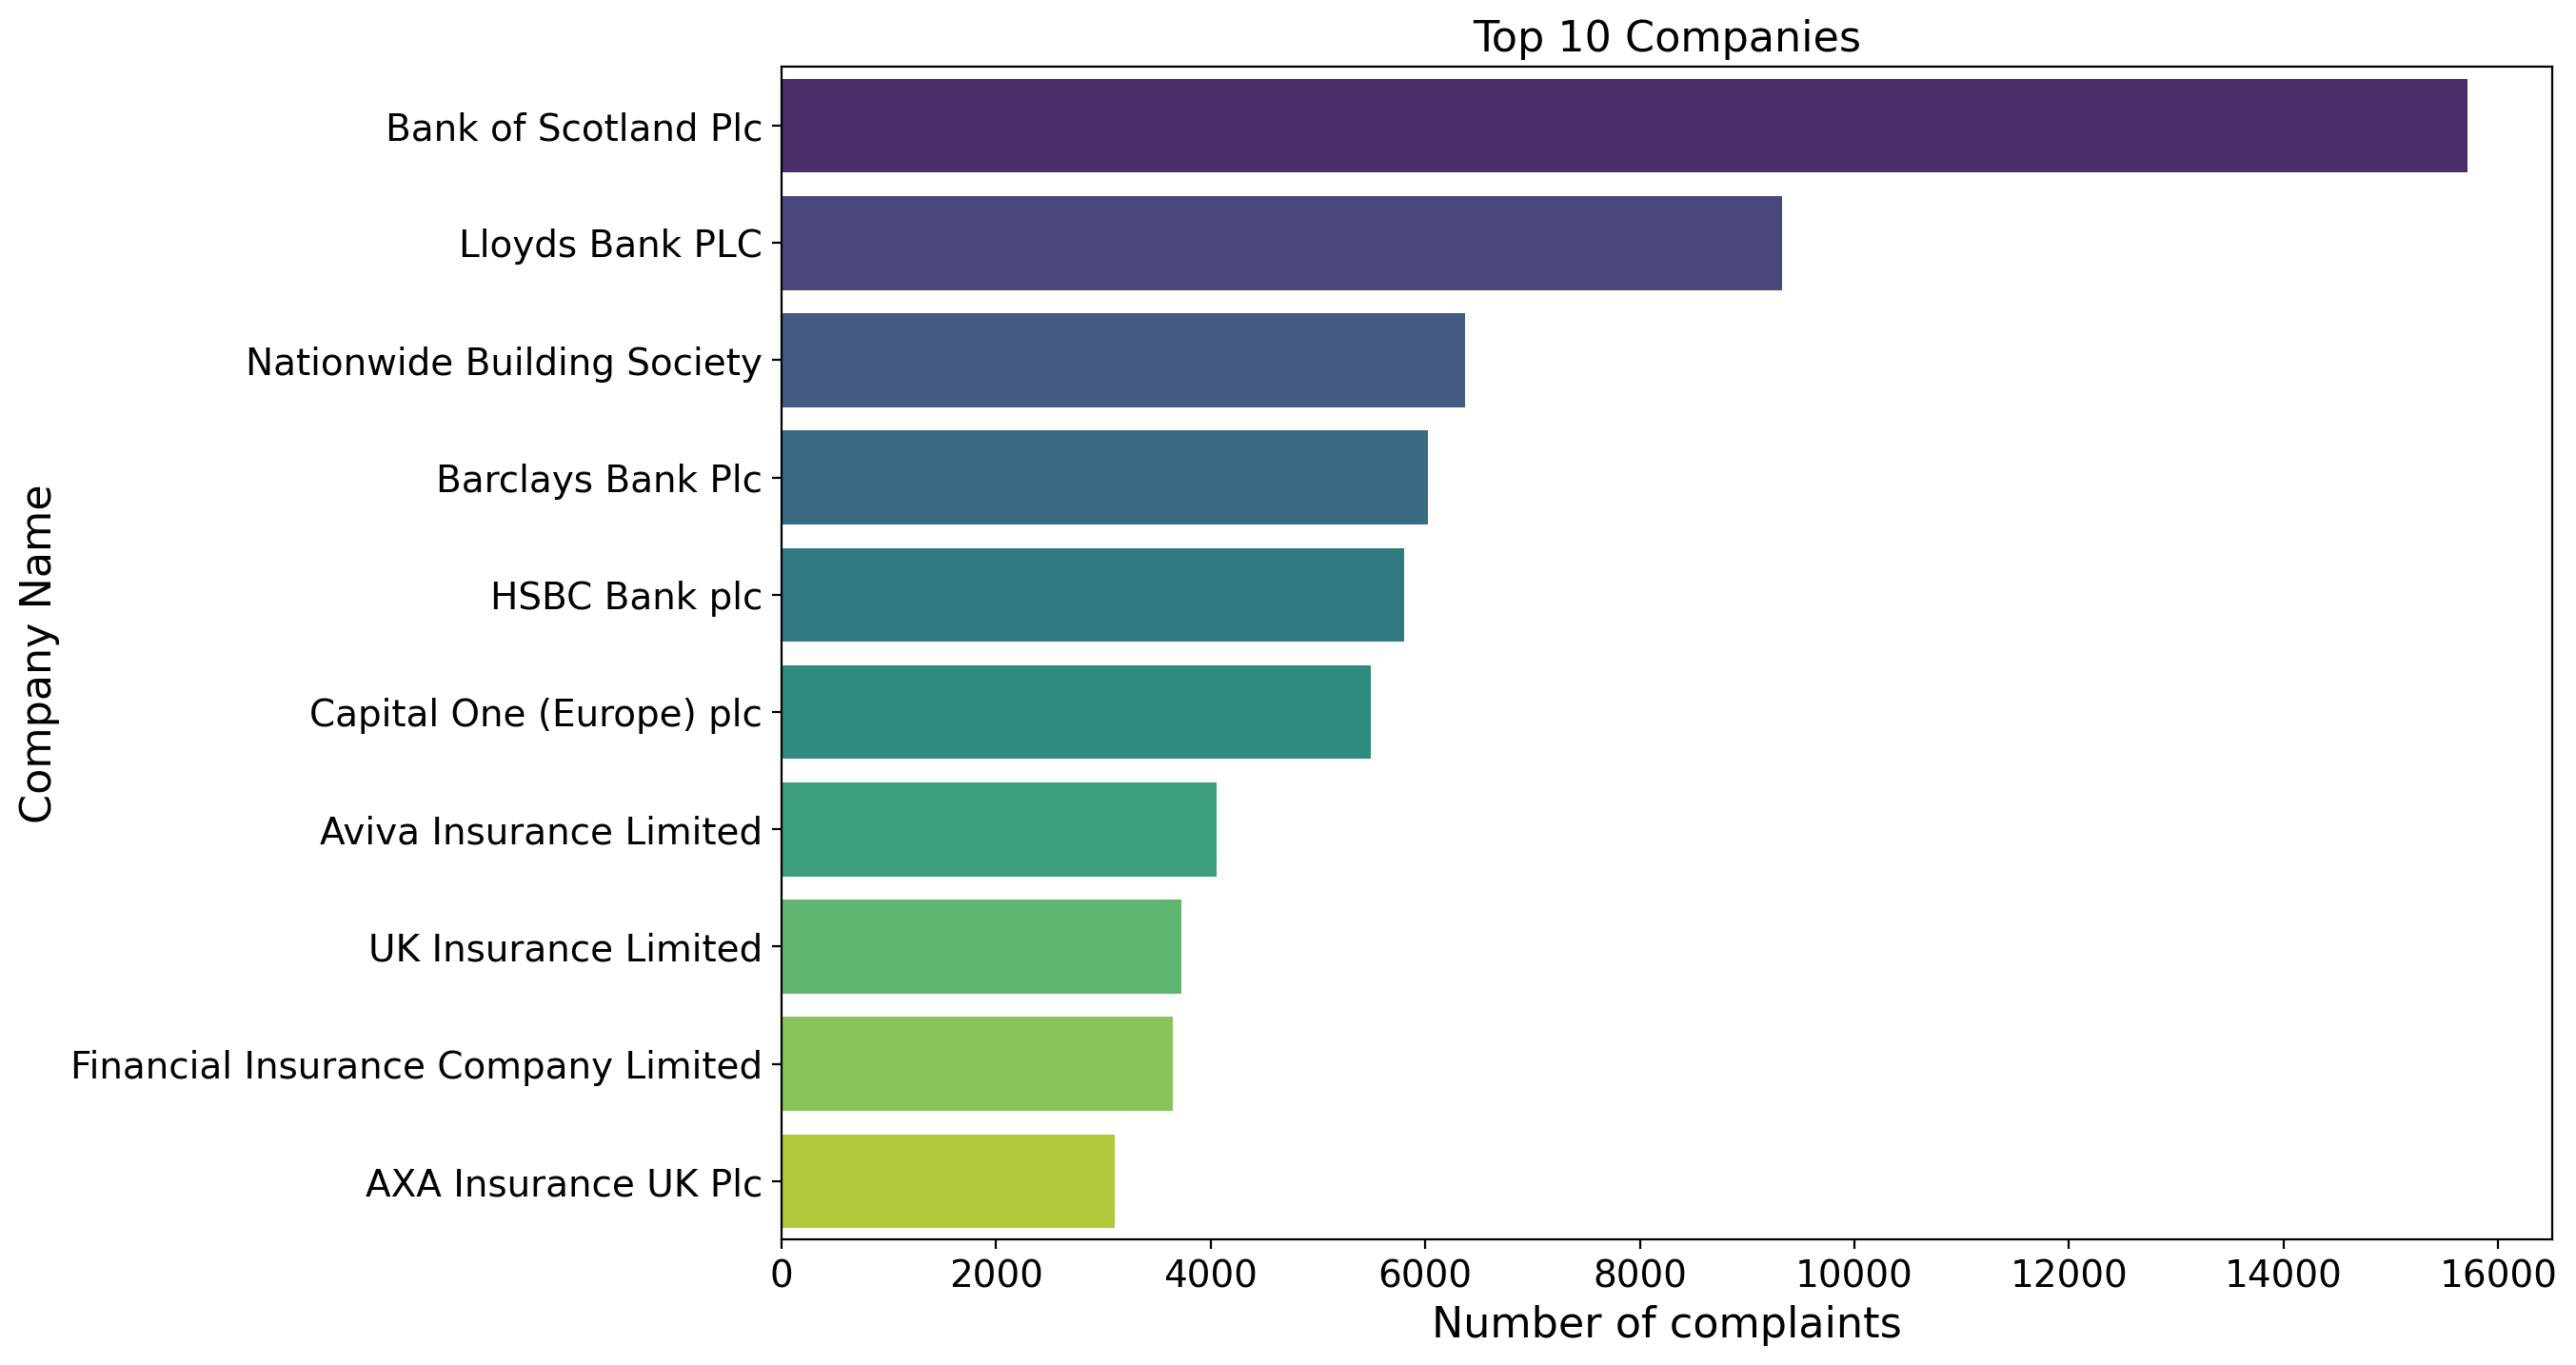

In [59]:
# Bar plot indicating the companies alongside their complaint count.
# Corresponds to Figure 1 in the report..

plt.figure(figsize=(12,8), dpi = 200)
sns.barplot(x='count', y='company', data=company_counts, palette='viridis')
plt.title('Top 10 Companies', fontsize = 16)
plt.xlabel('Number of complaints', fontsize = 16)
plt.ylabel('Company Name', fontsize = 16)

plt.xticks(fontsize=14) # Describing the size of the X axis numeric values.
plt.yticks(fontsize=14) # Describing the size of the Y axis numeric values.
plt.show()

In [60]:
# Filter the dataframe for 'upheld' decisions
upheld_counts = new_df[new_df['decision'] == 'Upheld']['company'].value_counts().head(10).reset_index()
upheld_counts.columns = ['company', 'frequency']

# Filter the DataFrame for 'not upheld' decisions
not_upheld_counts = new_df[new_df['decision'] == 'Not upheld']['company'].value_counts().head(10).reset_index()
not_upheld_counts.columns = ['company', 'frequency']

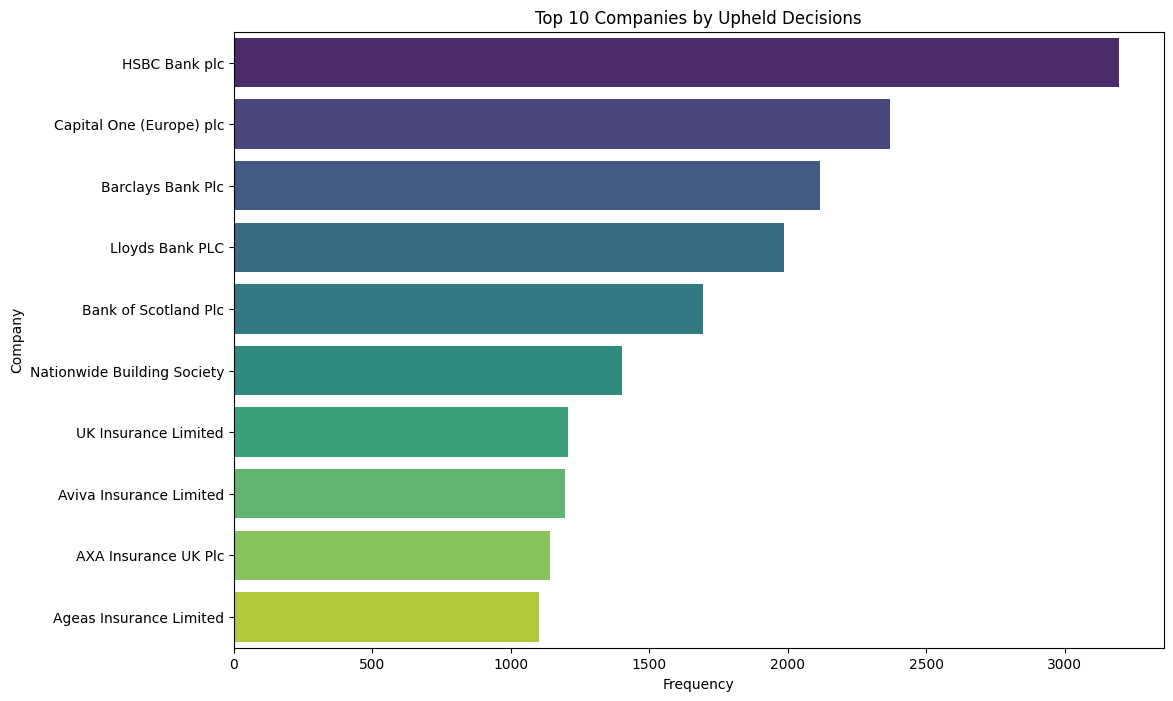

In [61]:
# Barplot indicating the top 10 companies based on the number of upheld decisions.

plt.figure(figsize=(12, 8))
sns.barplot(x='frequency', y='company', data=upheld_counts, palette='viridis')
plt.title('Top 10 Companies by Upheld Decisions')
plt.xlabel('Frequency')
plt.ylabel('Company')
plt.show()

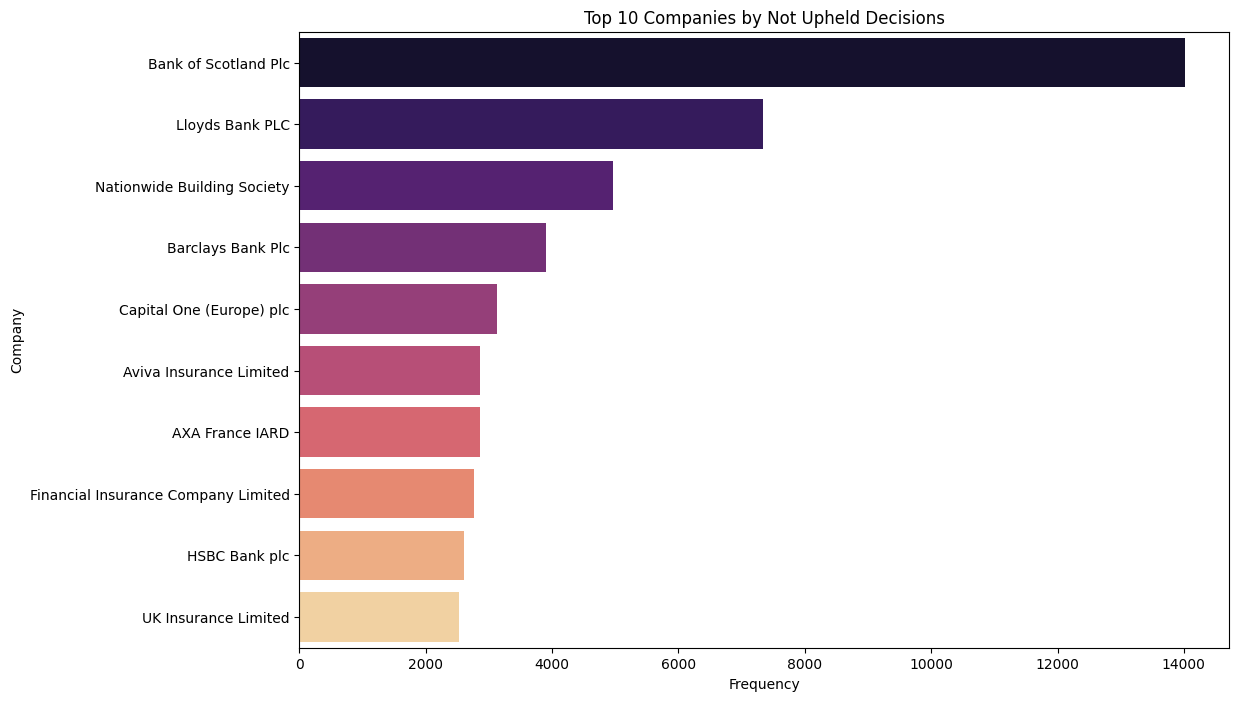

In [62]:
# Plot the top 10 companies with 'not upheld' decisions
plt.figure(figsize=(12, 8))
sns.barplot(x='frequency', y='company', data=not_upheld_counts, palette='magma')
plt.title('Top 10 Companies by Not Upheld Decisions')
plt.xlabel('Frequency')
plt.ylabel('Company')
plt.show()

In [63]:
new_df.decision.value_counts()

decision
Not upheld    107866
Upheld         52482
Name: count, dtype: int64

In [64]:
# Total claims per company
total_claims = new_df['company'].value_counts()

# Upheld claims per company
upheld_claims = new_df[new_df['decision'] == 'Upheld']['company'].value_counts()

# Calculate the ratio
ratio_df = (upheld_claims / total_claims).reset_index()
ratio_df.columns = ['company', 'ratio']

In [65]:
ratio_df.company.nunique()

2652

In [66]:
ratio_df['ratio'] = ratio_df['ratio'].fillna(0)

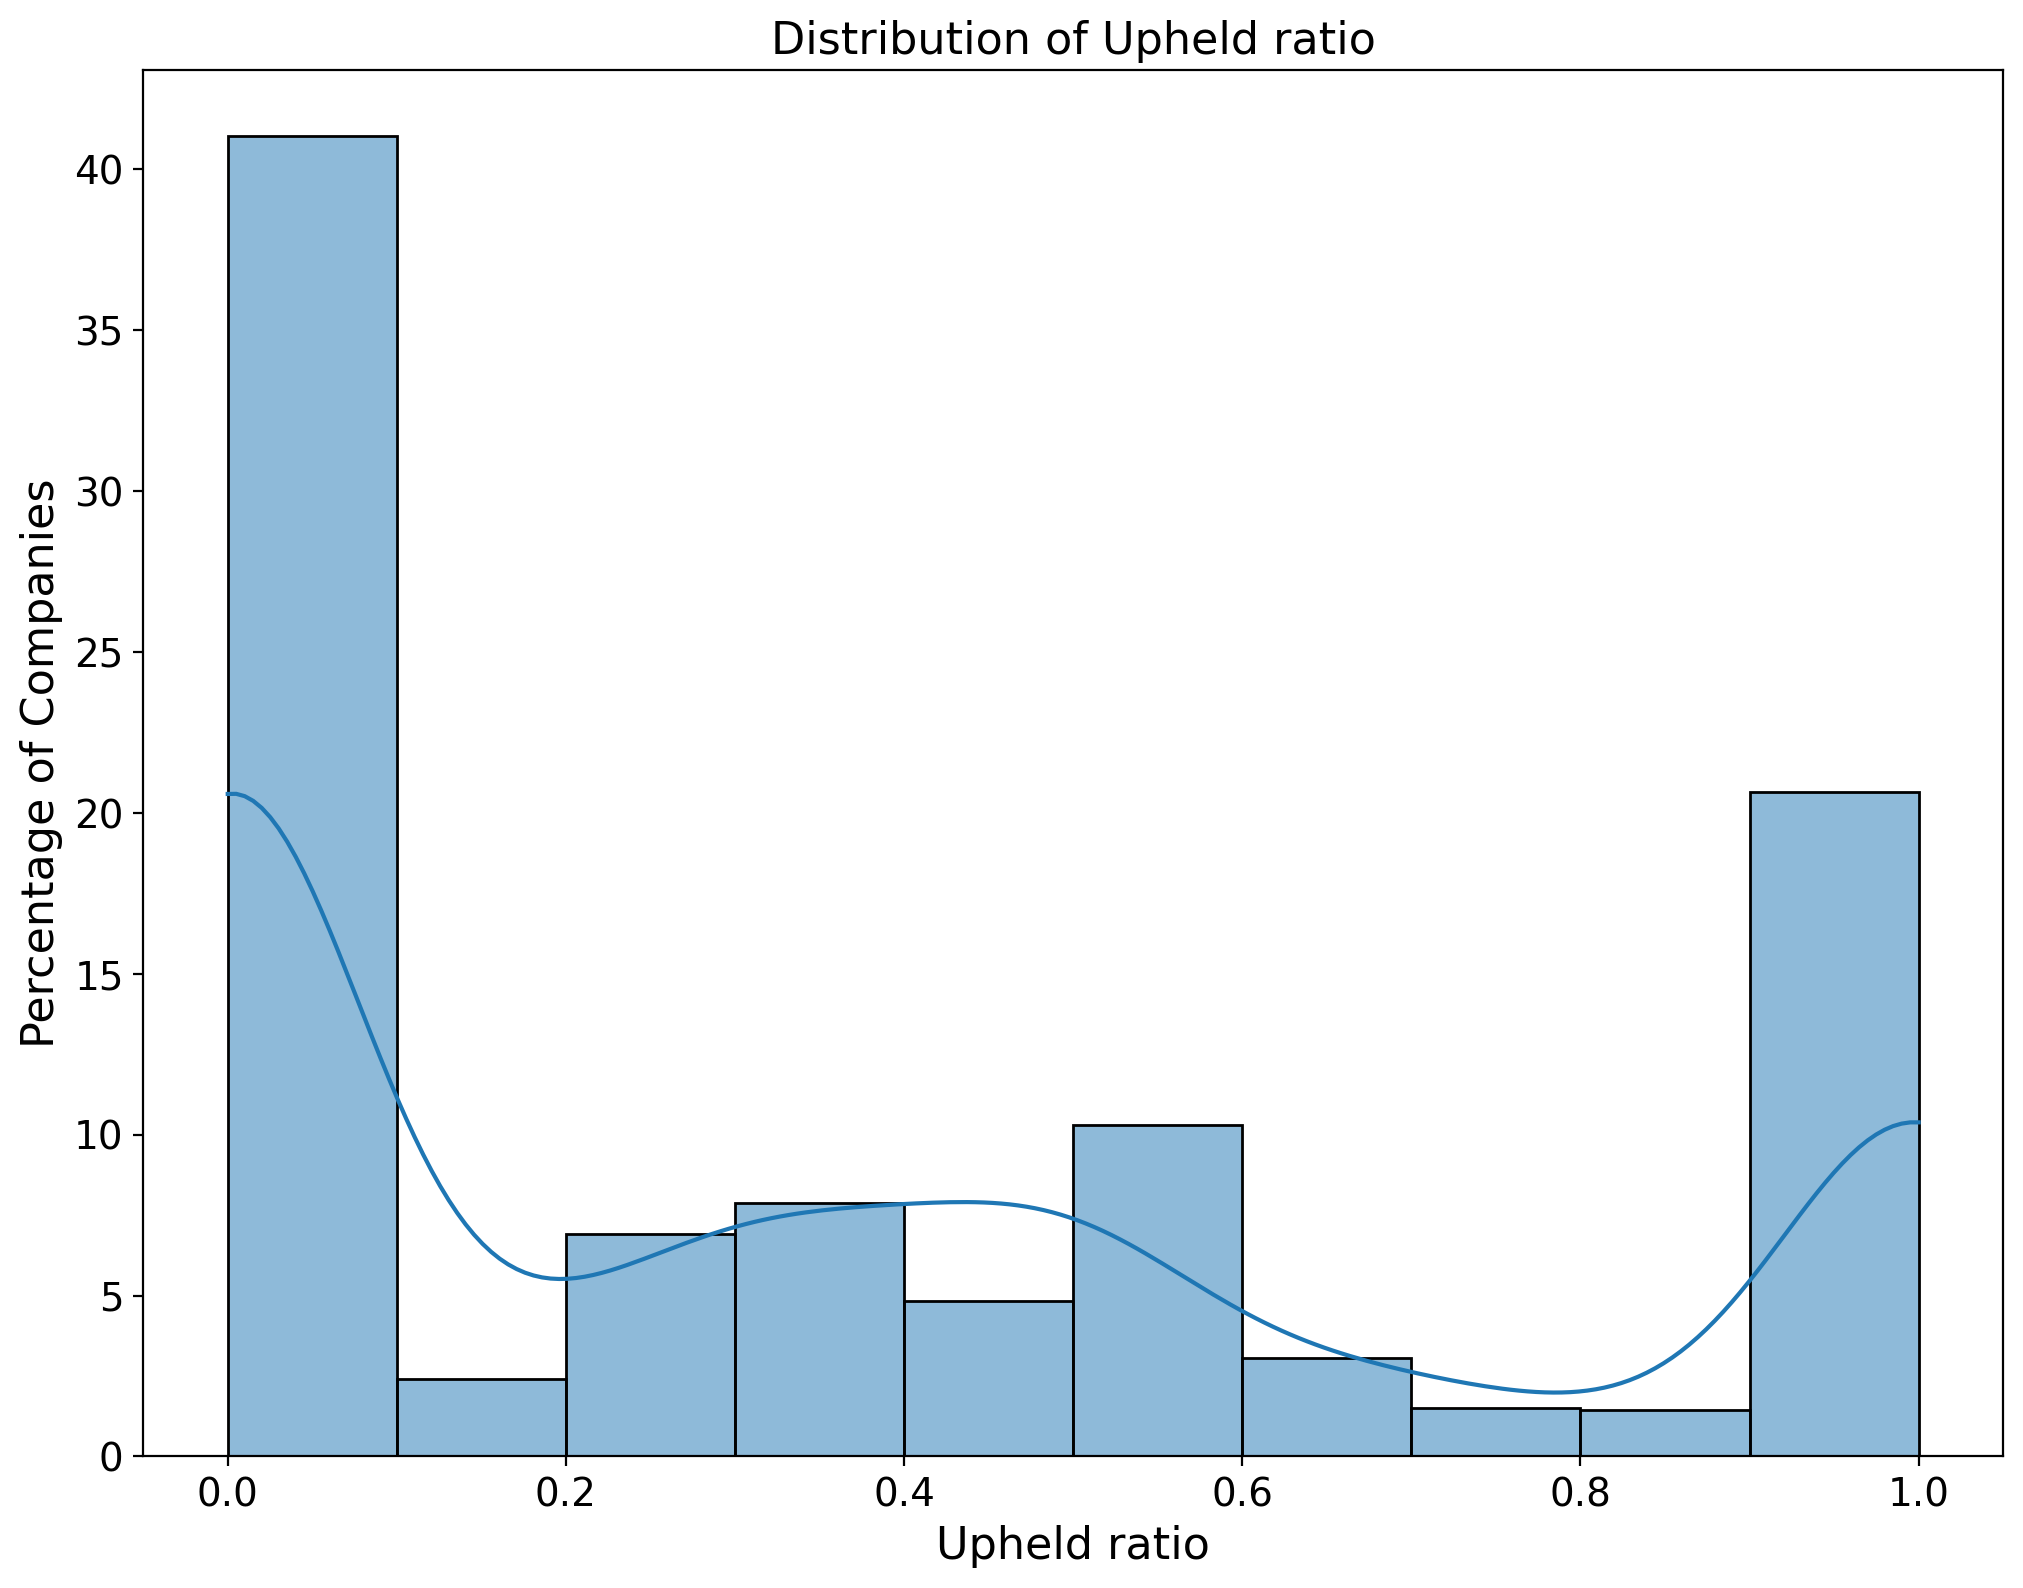

In [67]:
#  Histogram plot depicting the distribution of companies on their upheld ratio..
# Corresponds to Figure 2 in the report..

import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram to show the distribution of ratio values
plt.figure(figsize=(12,9),dpi = 200)
sns.histplot(ratio_df['ratio'], bins=10, kde=True, stat="percent")
plt.title('Distribution of Upheld ratio',fontsize = 16)
plt.xlabel('Upheld ratio',fontsize = 16)
plt.ylabel('Percentage of Companies',fontsize = 16)

plt.xticks(fontsize=14) # Describing the size of the X axis numeric values.
plt.yticks(fontsize=14) # Describing the size of the Y axis numeric values.
plt.show()



In [68]:
ratio_df[(ratio_df['ratio'] >= 0.9) & (ratio_df['ratio'] <= 1.0)].shape

(548, 2)

In [69]:
filtered_df = ratio_df[(ratio_df['ratio'] >= 0.0) & (ratio_df['ratio'] <= 0.1)]

# Calculate the percentage of companies in this range
percentage = (filtered_df.shape[0] / ratio_df.shape[0]) * 100

percentage

41.17647058823529

In [70]:
# Total claims per company
total_claims = new_df['company'].value_counts()

# Not Upheld claims per company
not_upheld_claims = new_df[new_df['decision'] == 'Not upheld']['company'].value_counts()

# Calculate the ratio
non_ratio_df = (not_upheld_claims / total_claims).reset_index()
non_ratio_df.columns = ['company', 'ratio']

In [71]:
non_ratio_df['ratio'] = non_ratio_df['ratio'].fillna(0)

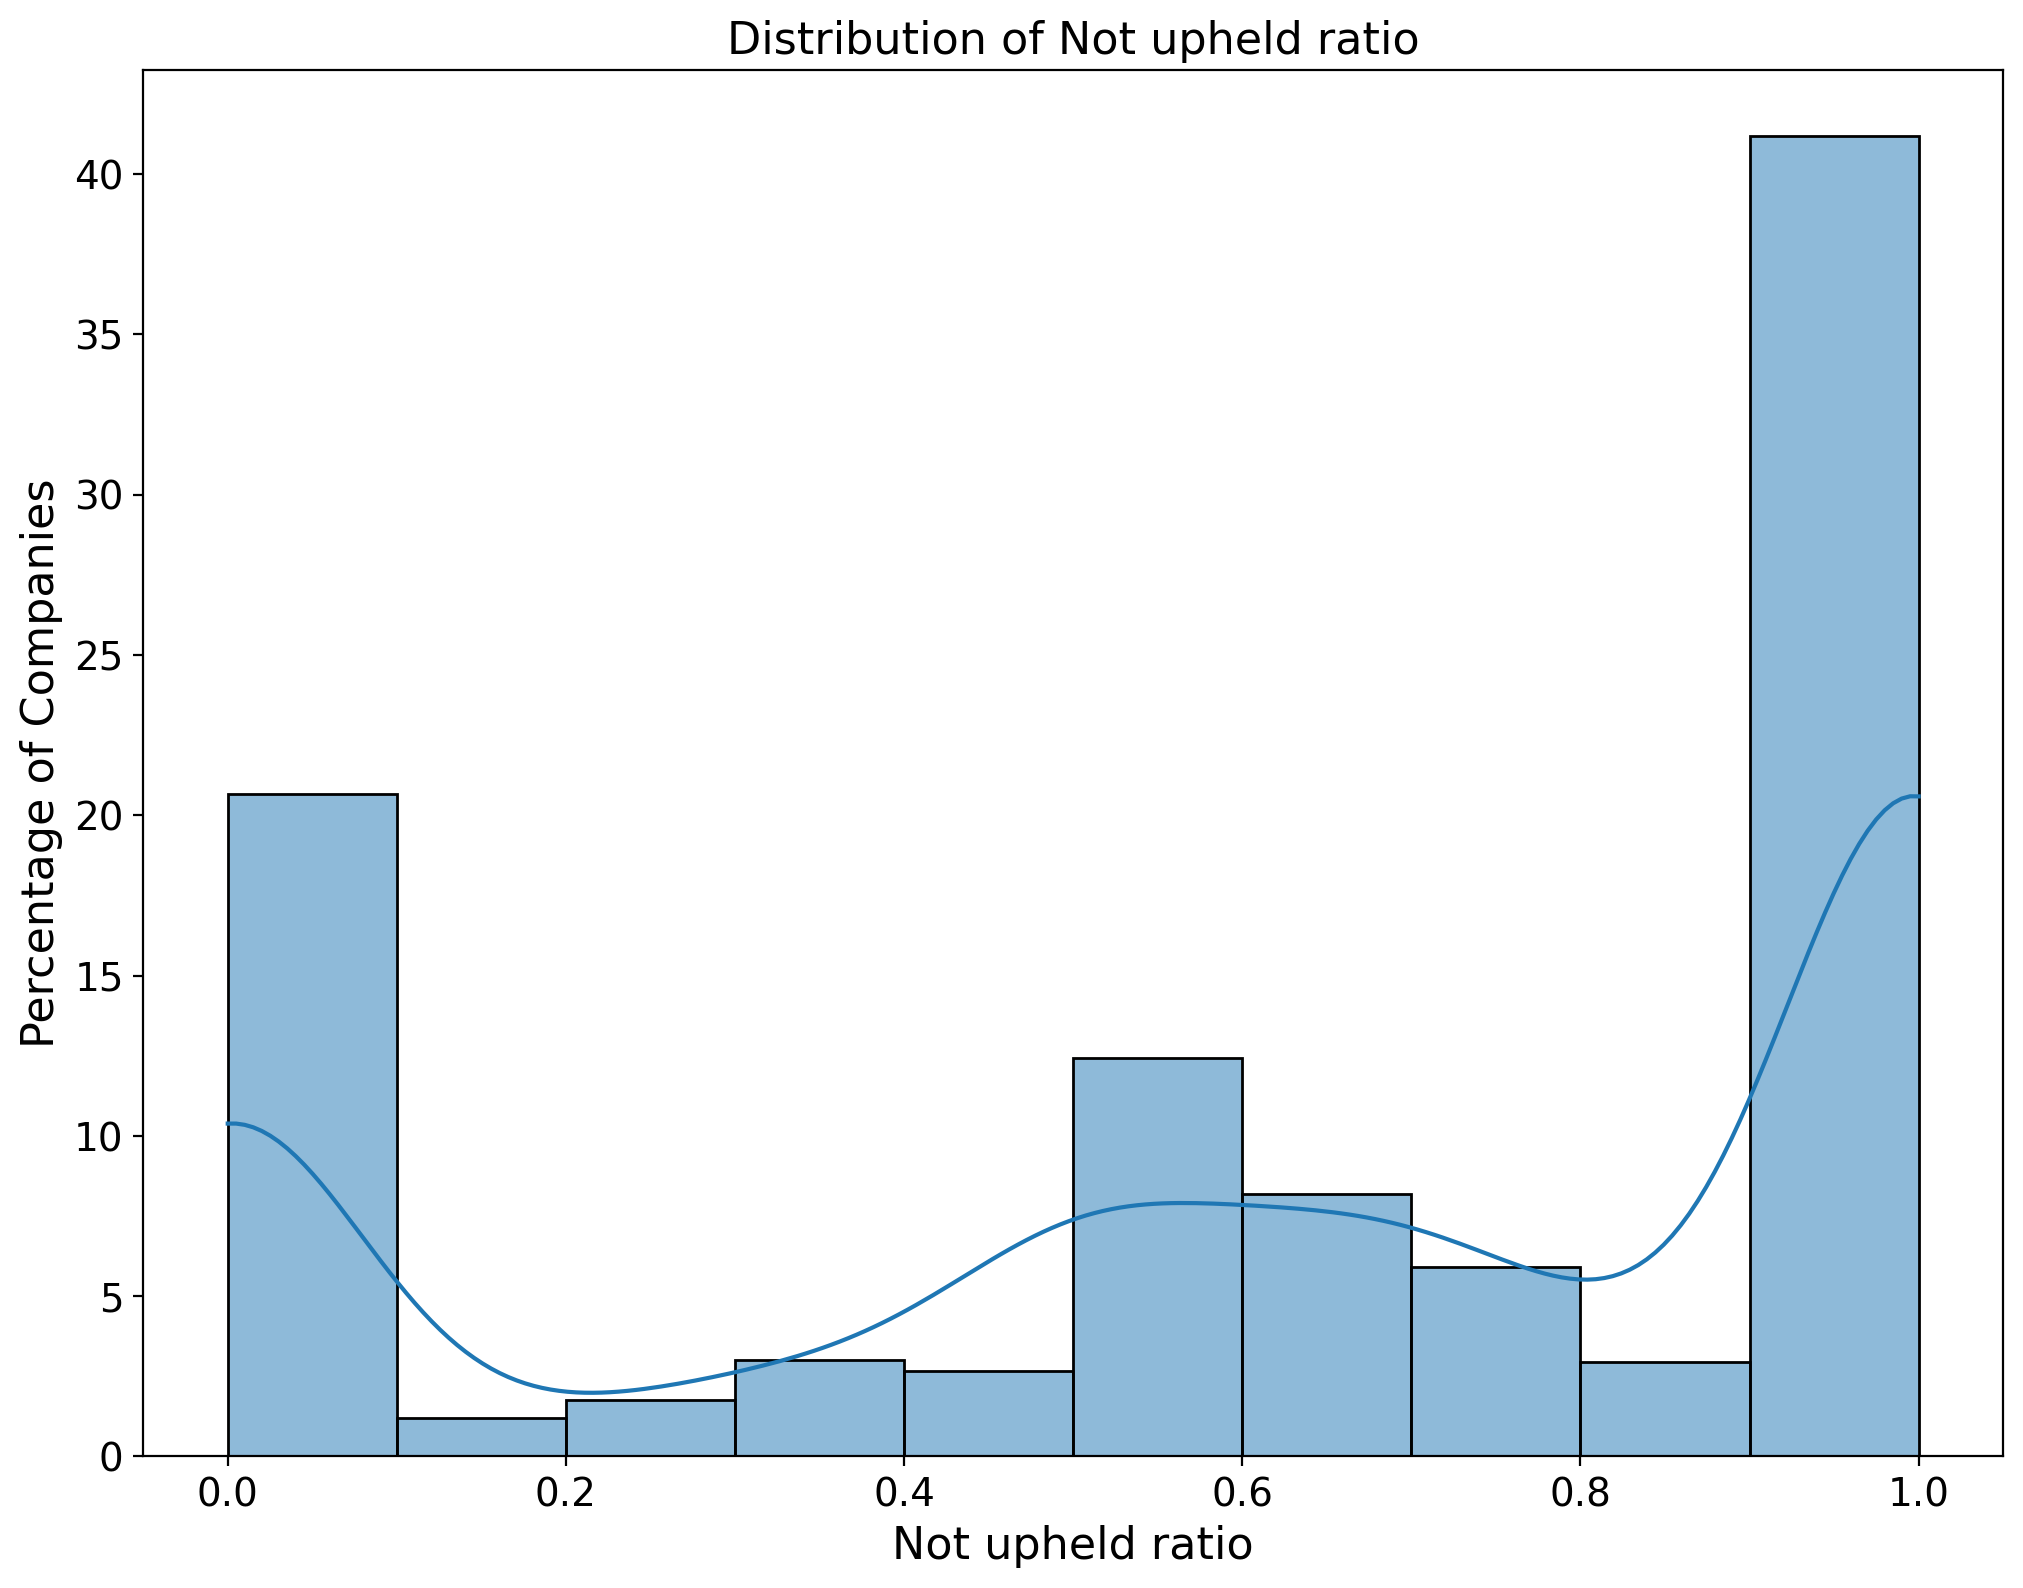

In [72]:
# Distribution on the not upheld ratio across companies..


# Create a histogram to show the distribution of ratio values
plt.figure(figsize=(12,9), dpi = 200)
sns.histplot(non_ratio_df['ratio'], bins=10, kde=True, stat="percent")
plt.title('Distribution of Not upheld ratio',fontsize = 16)
plt.xlabel('Not upheld ratio',fontsize = 16)
plt.ylabel('Percentage of Companies',fontsize = 16)

plt.xticks(fontsize=14) # Describing the size of the X axis numeric values.
plt.yticks(fontsize=14) # Describing the size of the Y axis numeric values.
plt.show()


In [73]:
non_ratio_df[non_ratio_df['ratio'] == 1.0].shape

(1072, 2)

In [74]:
non_ratio_df[non_ratio_df['ratio'] == 0.0].shape

(541, 2)

## ***TIMELINE ANALYSIS***

In [75]:
df.columns # Displaying columns of the dataframe present

Index(['decision_id', 'location', 'title', 'date', 'company', 'decision',
       'tag', 'Complaint_Info', 'Complaint_Explanation',
       'Decision_Taken_And_Reason', 'Final_Decision', 'provisional_decision'],
      dtype='object')

In [76]:
new_df[['date']]

date
0      2014-07-15
1      2014-07-15
2      2014-07-15
3      2014-07-15
4      2014-07-15
...           ...
160792 2023-07-17
160793 2023-07-17
160794 2023-07-17
160795 2023-07-17
160796 2023-07-16

[160348 rows x 1 columns]

In [77]:
# Converting to datetime format and fetching the year, month and day accordingly..

new_df['year'] = new_df['date'].dt.year
new_df['month'] = new_df['date'].dt.month
new_df['day'] = new_df['date'].dt.day

In [78]:
new_df[['date','year','month','day']]

date  year  month  day
0      2014-07-15  2014      7   15
1      2014-07-15  2014      7   15
2      2014-07-15  2014      7   15
3      2014-07-15  2014      7   15
4      2014-07-15  2014      7   15
...           ...   ...    ...  ...
160792 2023-07-17  2023      7   17
160793 2023-07-17  2023      7   17
160794 2023-07-17  2023      7   17
160795 2023-07-17  2023      7   17
160796 2023-07-16  2023      7   16

[160348 rows x 4 columns]

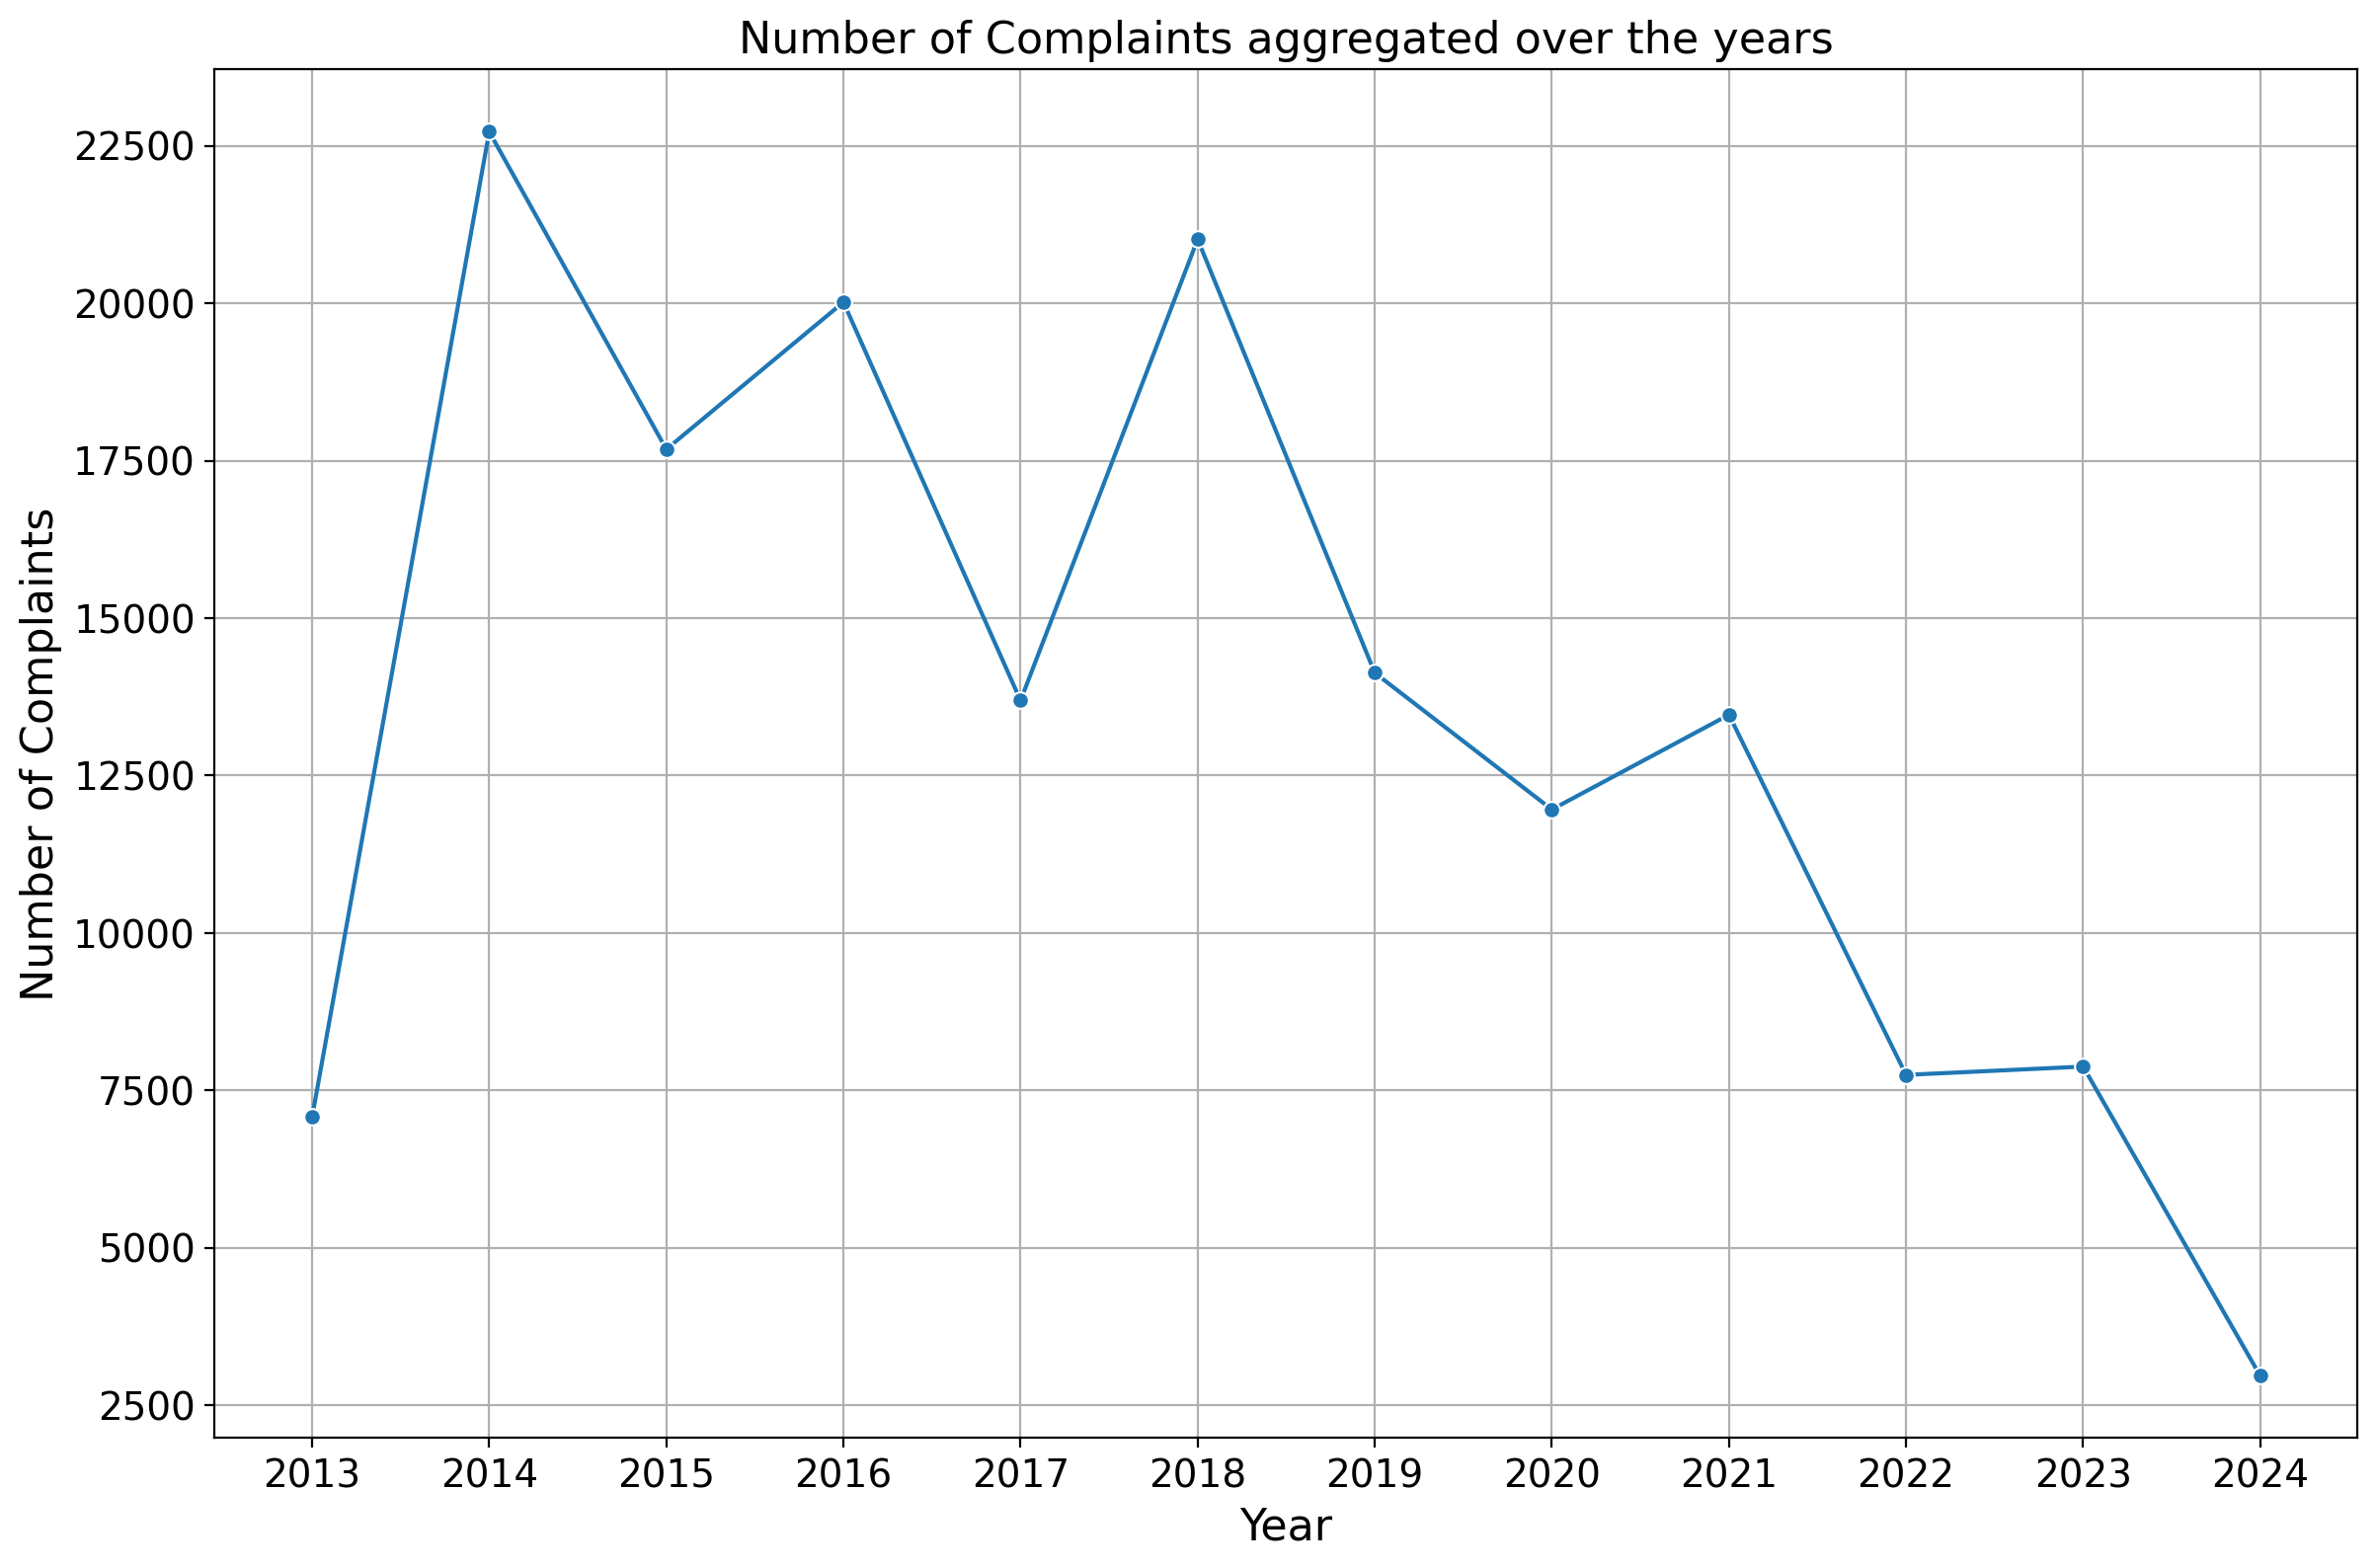

In [79]:
# Line plot depicting the aggregated complaints over the years present.
#  Corresponds to Figure 3 in the report.

complaints_per_year = new_df.groupby('year').size().reset_index(name='count')

plt.figure(figsize=(14,9), dpi = 200)
sns.lineplot(data=complaints_per_year, x='year', y='count', marker='o')
plt.title('Number of Complaints aggregated over the years',fontsize=16)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Number of Complaints',fontsize=16)
plt.grid(True)
plt.xticks(complaints_per_year['year'],fontsize=14)  # Ensure all years are shown on the x-axis
plt.yticks(fontsize = 14)
plt.show()

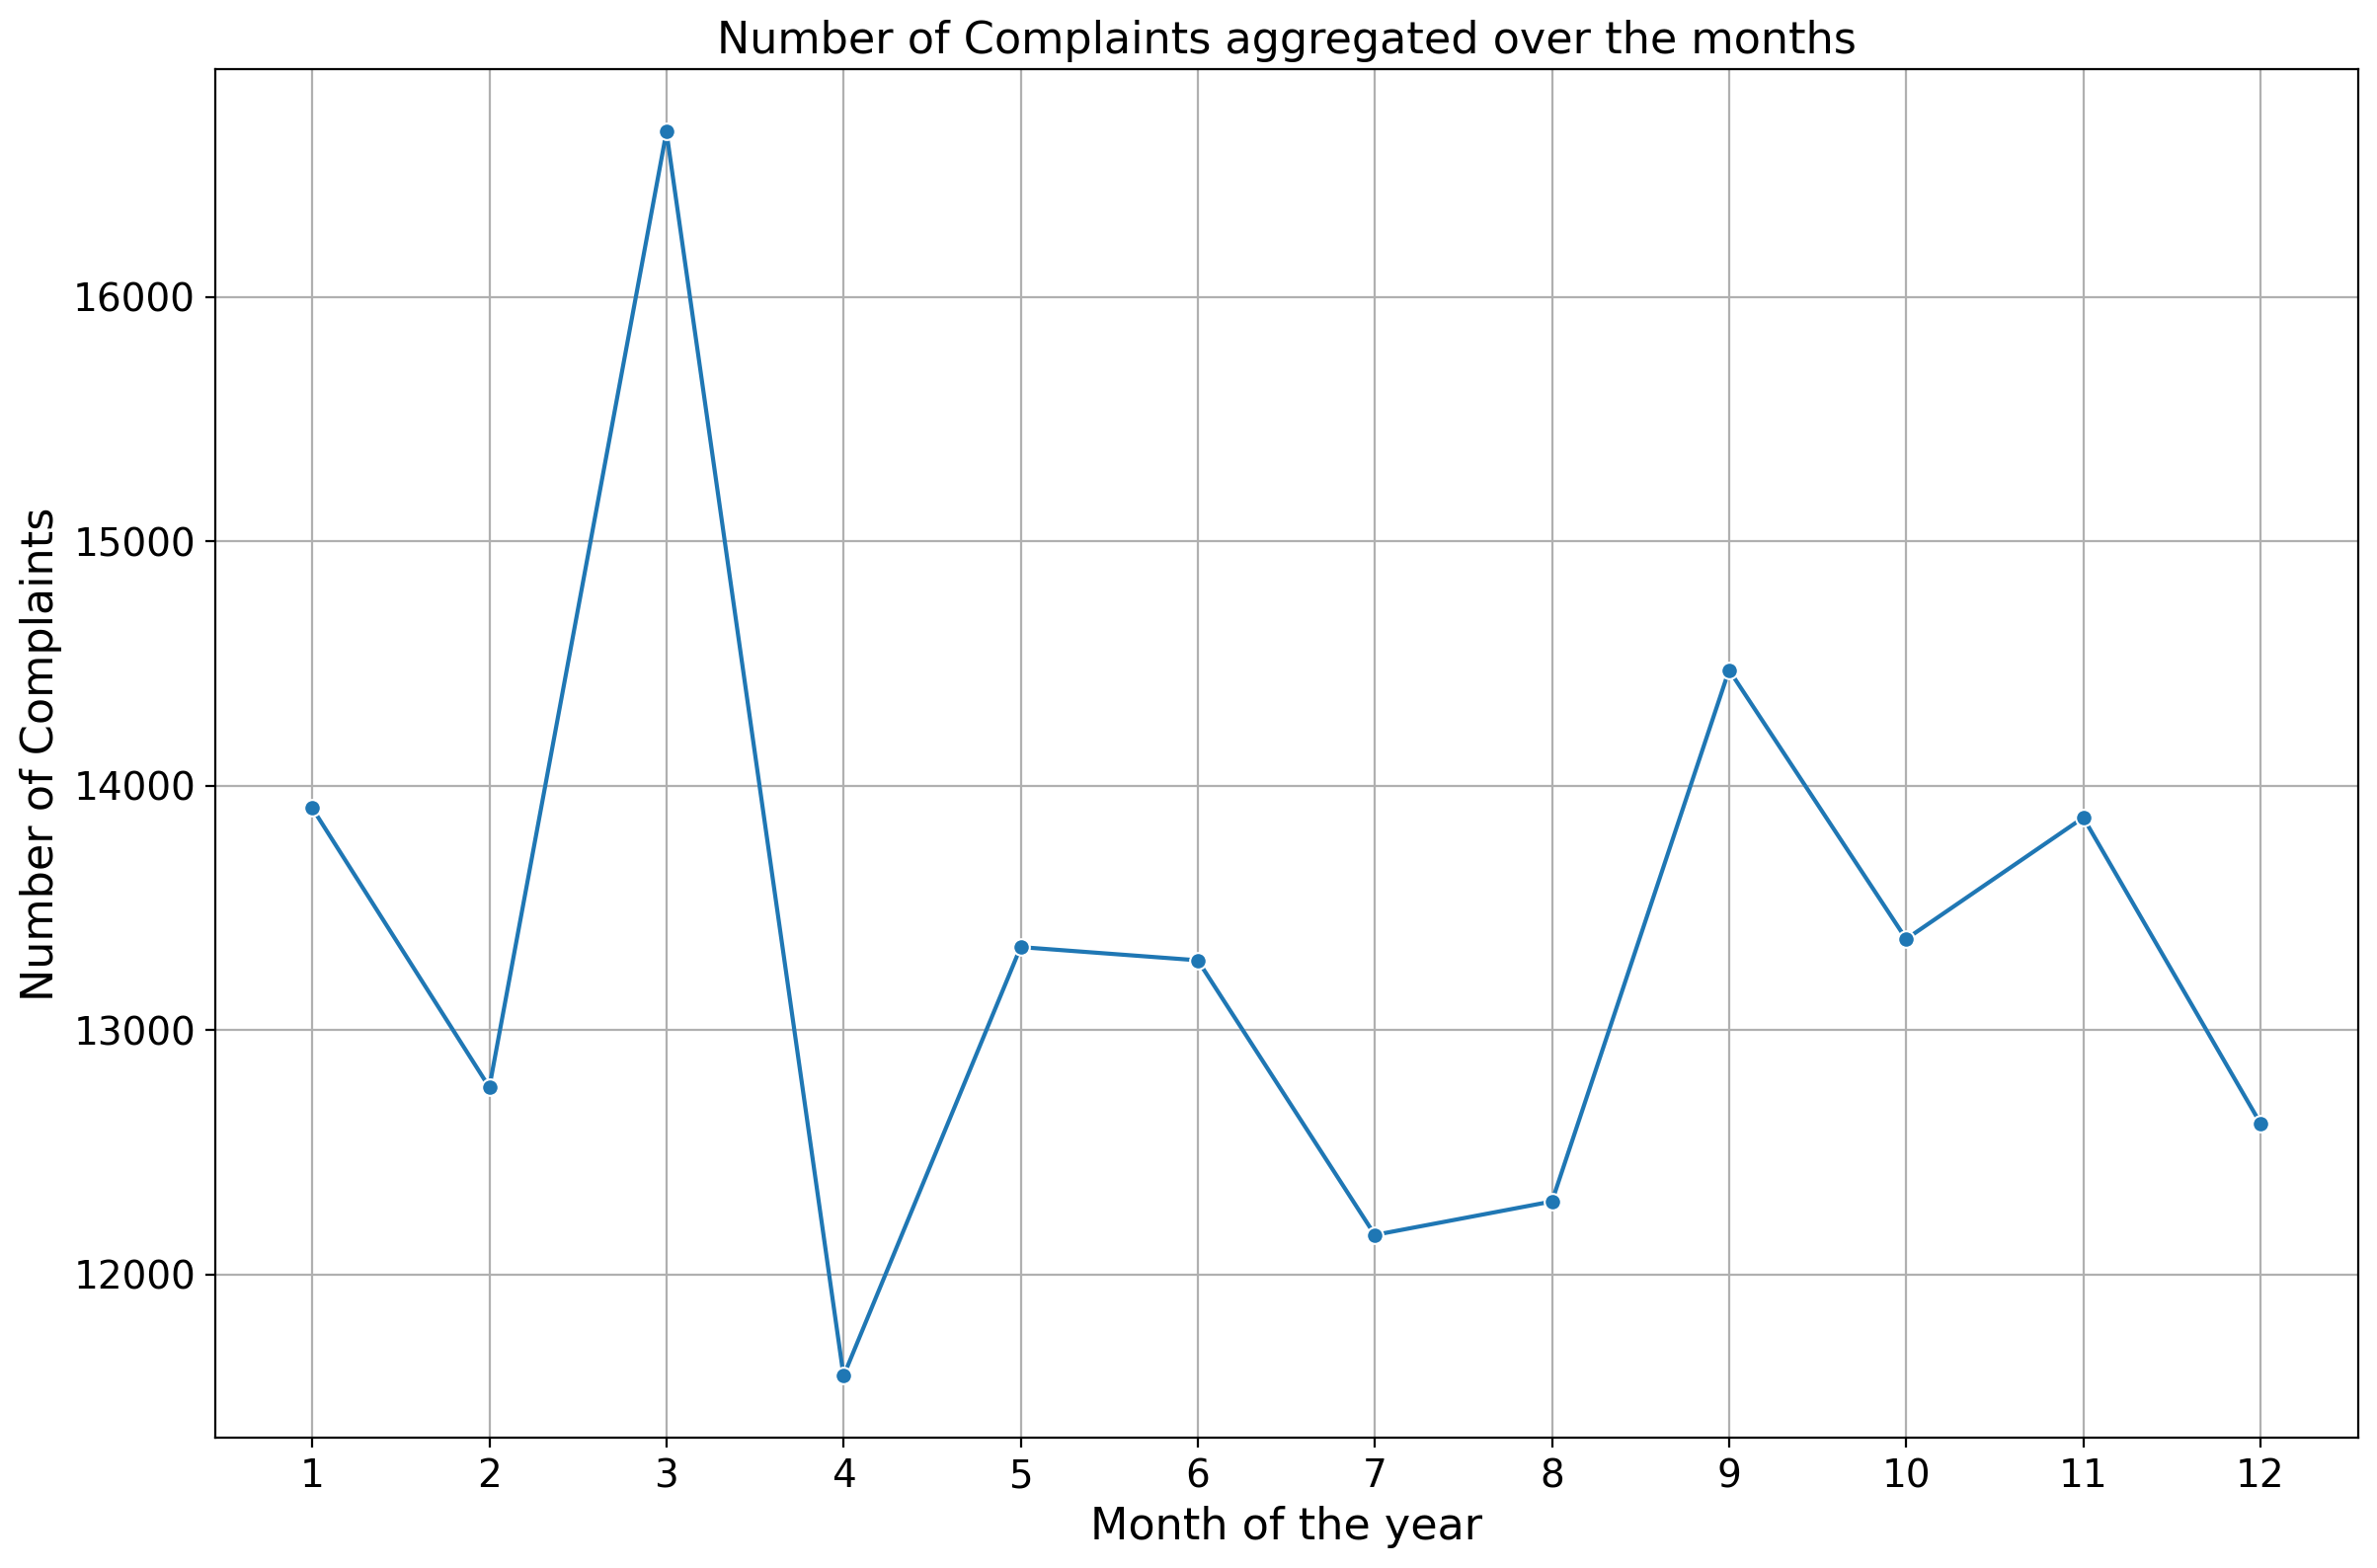

In [80]:
# Lineplot depicting the aggregated complaints over the different months present.
# Correspnds to Figure 7 in the report.

complaints_per_month = new_df.groupby('month').size().reset_index(name='count')

plt.figure(figsize=(14,9), dpi=200)
sns.lineplot(data=complaints_per_month, x='month', y='count', marker='o')
plt.title('Number of Complaints aggregated over the months',fontsize=16)
plt.xlabel('Month of the year',fontsize=16)
plt.ylabel('Number of Complaints',fontsize=16)
plt.grid(True)

plt.xticks(complaints_per_month['month'],fontsize=14)  # Ensure all months are shown on the x-axis
plt.yticks(fontsize = 14)

plt.show()

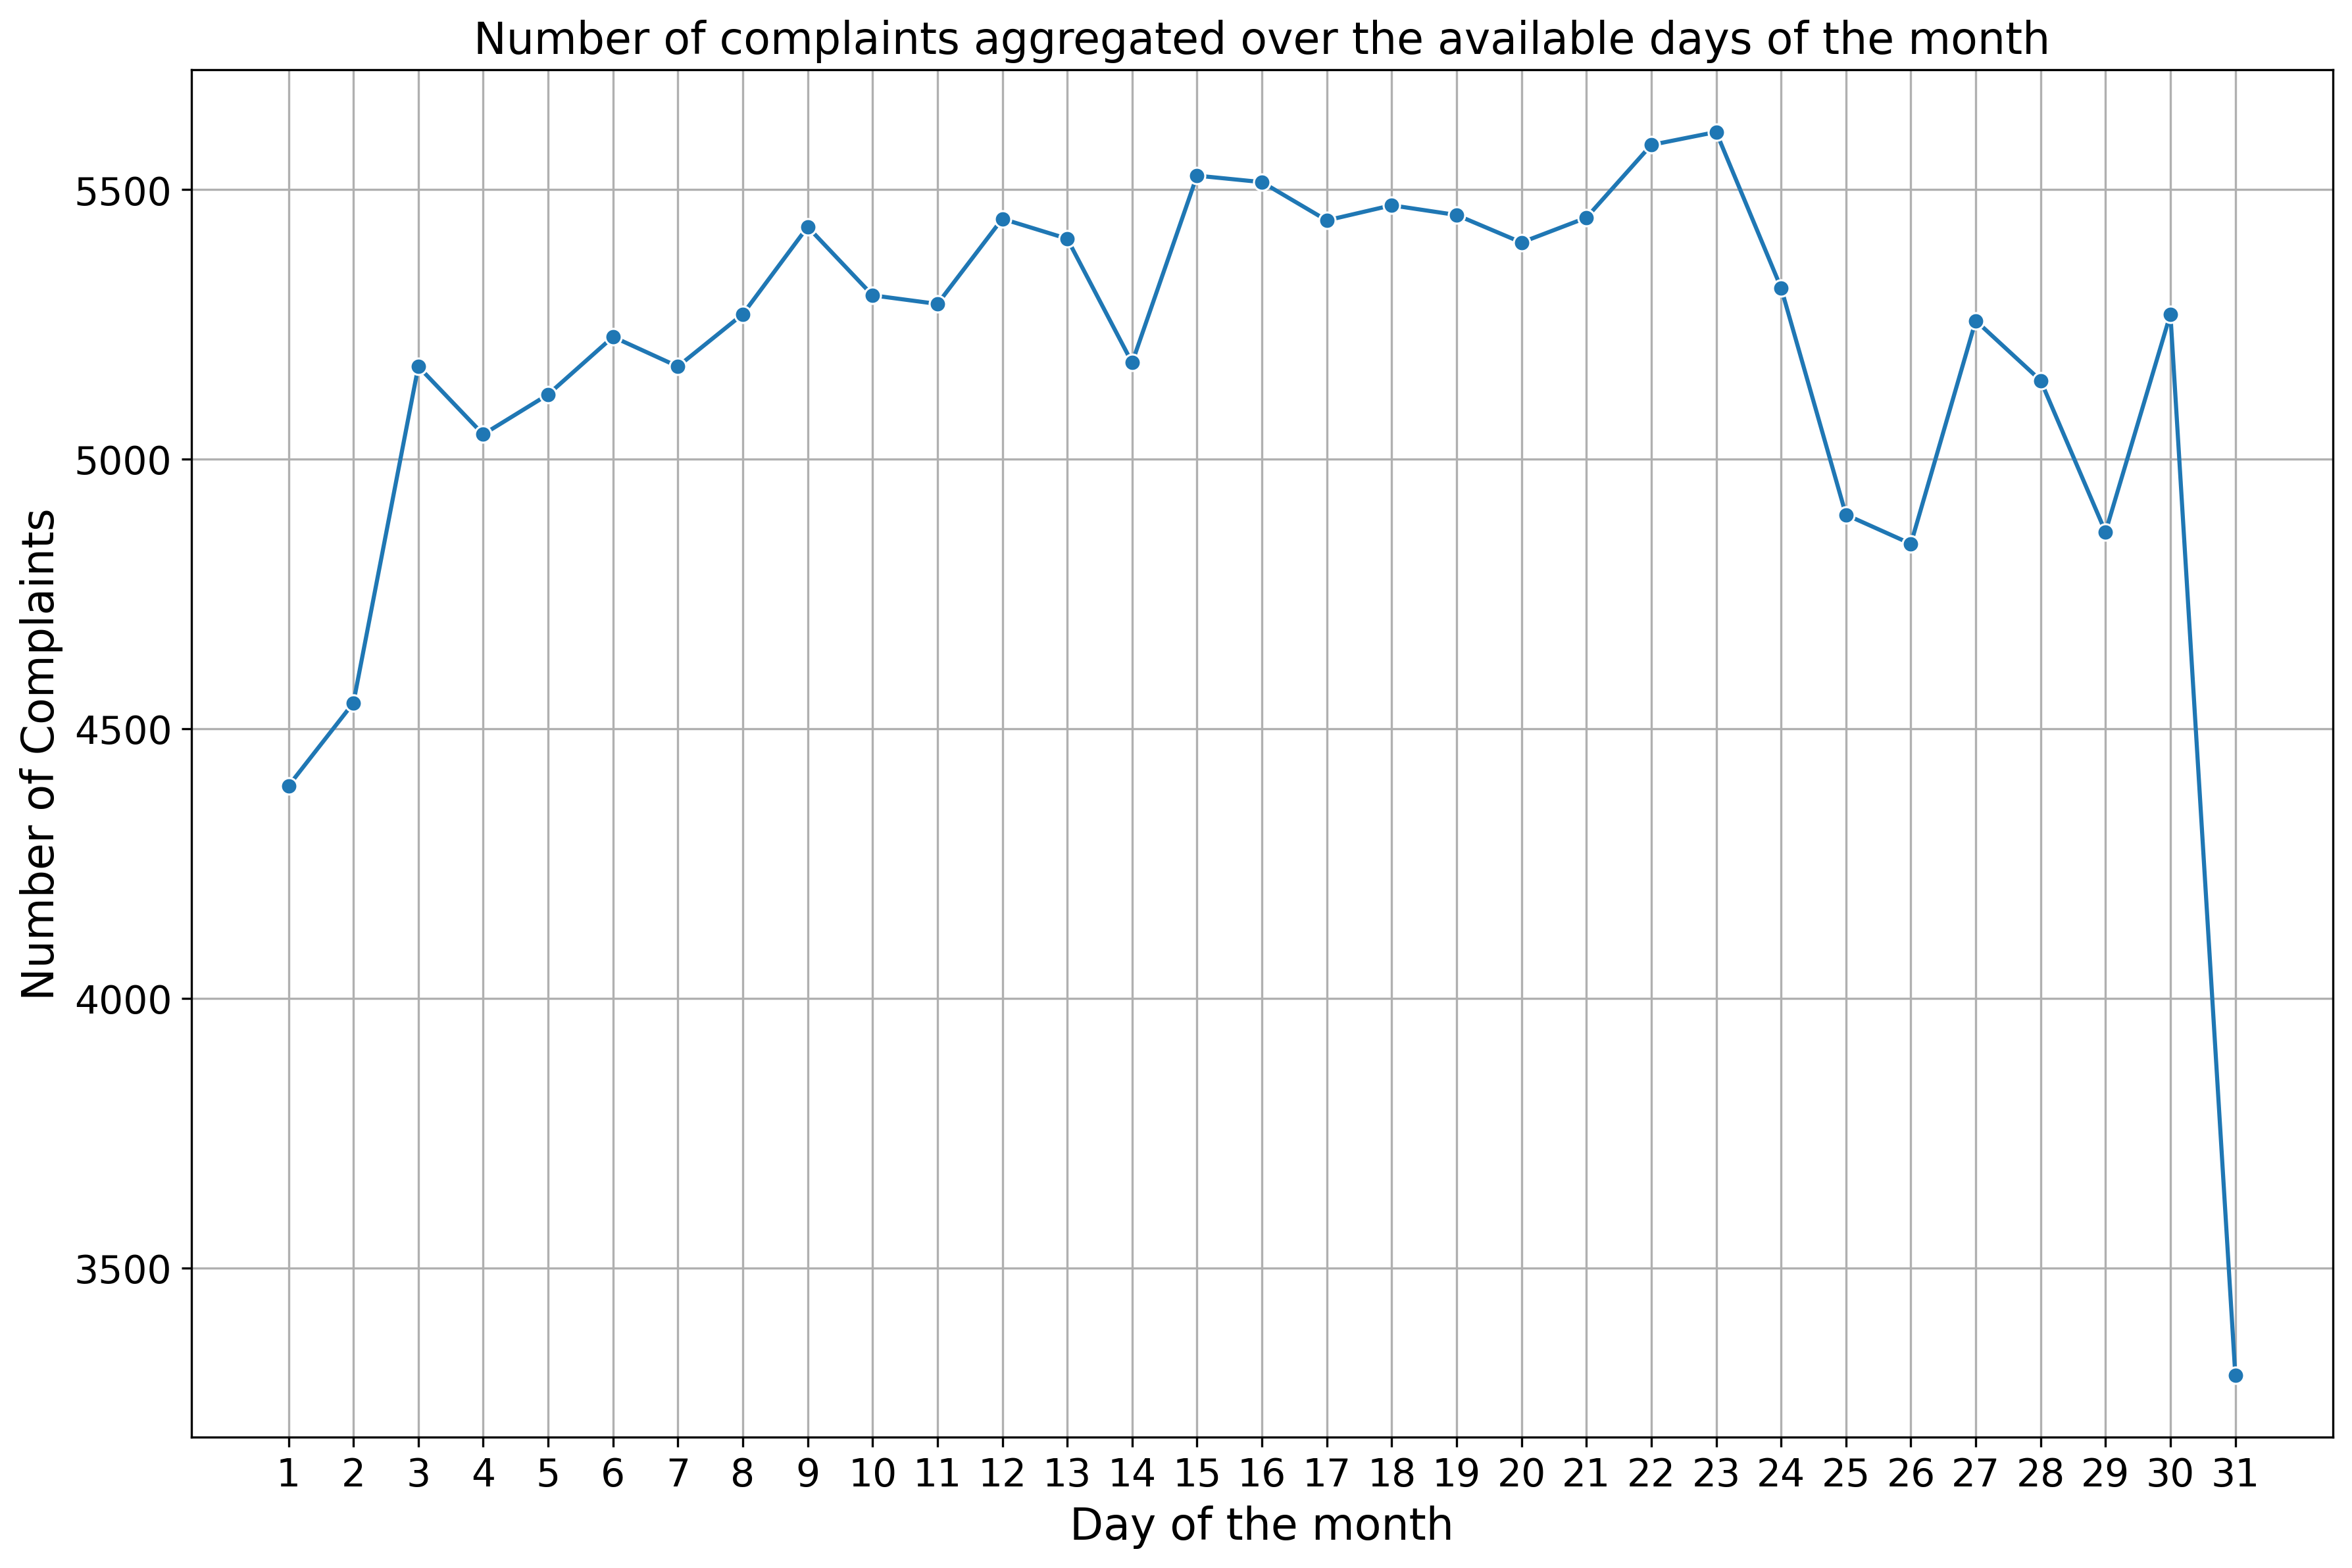

In [81]:
# Lineplot depicting the aggregated complaints over the available days of the month..
complaints_per_day = new_df.groupby('day').size().reset_index(name='count')

plt.figure(figsize=(14,9), dpi=300)
sns.lineplot(data=complaints_per_day, x='day', y='count', marker='o')
plt.title('Number of complaints aggregated over the available days of the month',fontsize=16)
plt.xlabel('Day of the month',fontsize=16)
plt.ylabel('Number of Complaints',fontsize=16)
plt.grid(True)


plt.xticks(complaints_per_day['day'],fontsize=14)  # Ensure all months are shown on the x-axis
plt.yticks(fontsize = 14)
plt.show()

### ***UPHELD CLAIM ANALYSIS***

In [82]:
upheld_df = new_df[new_df['decision'] == 'Upheld']

In [83]:
upheld_df.shape

(52482, 16)

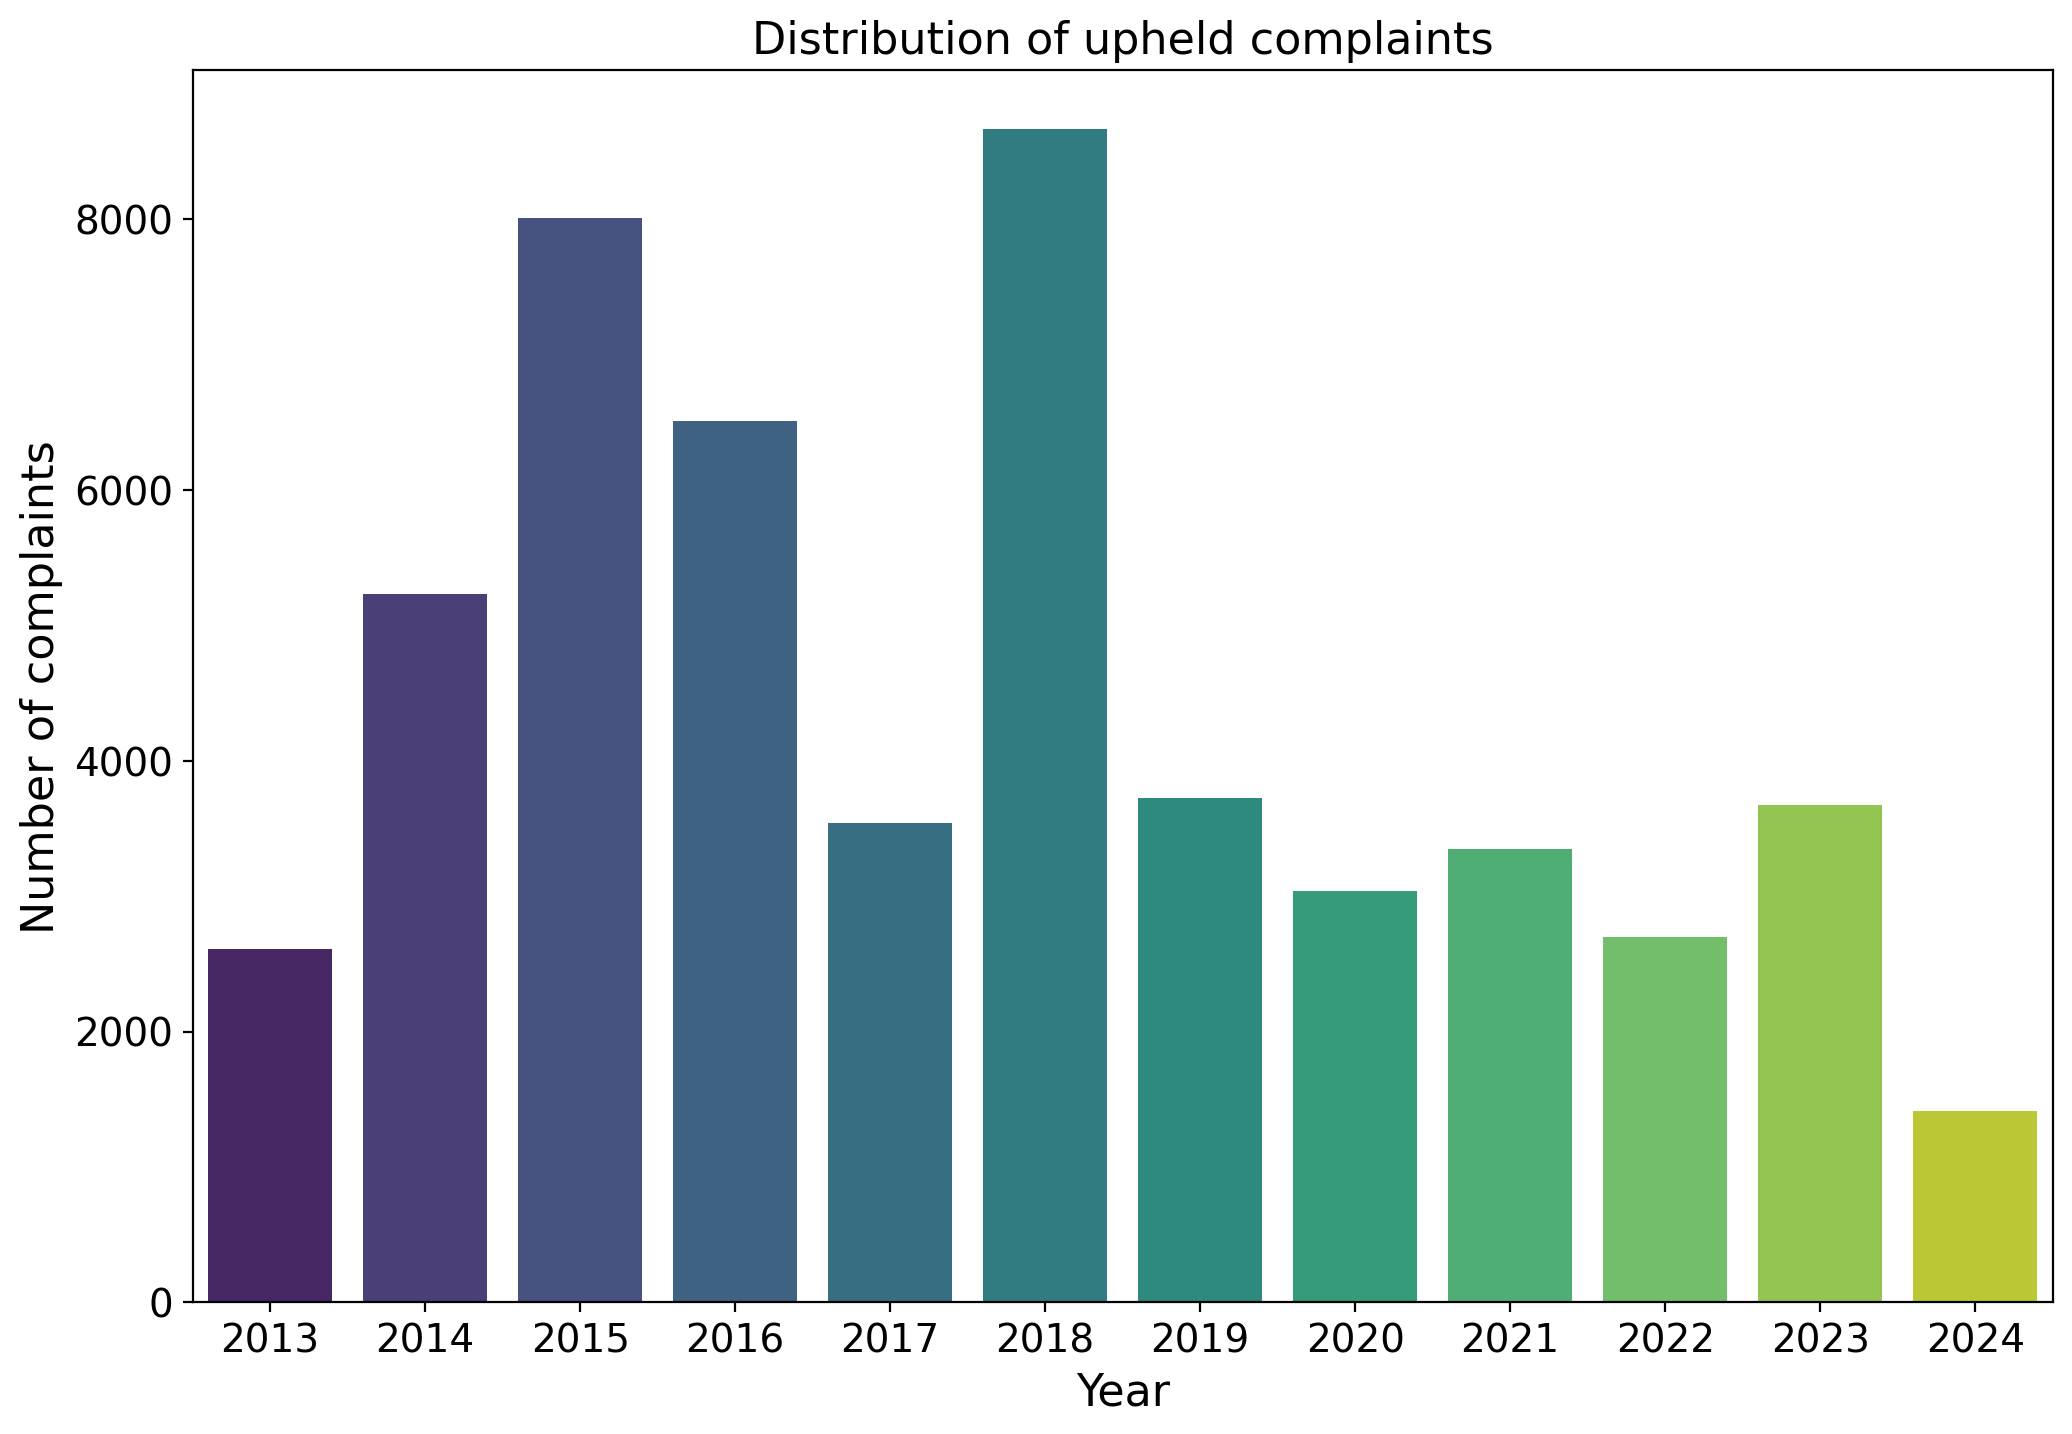

In [84]:
# Bar Plot indicatingthe yearly distribution using Seaborn package.
# Corresponds fo Figure 4 in the report.


plt.figure(figsize=(12, 8), dpi = 200)
sns.countplot(data=upheld_df, x='year', palette='viridis')
plt.title('Distribution of upheld complaints', fontsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Number of complaints', fontsize = 16)


plt.xticks(fontsize=14) # Describing the size of the X axis numeric values.
plt.yticks(fontsize=14) # Describing the size of the Y axis numeric values.
plt.show()

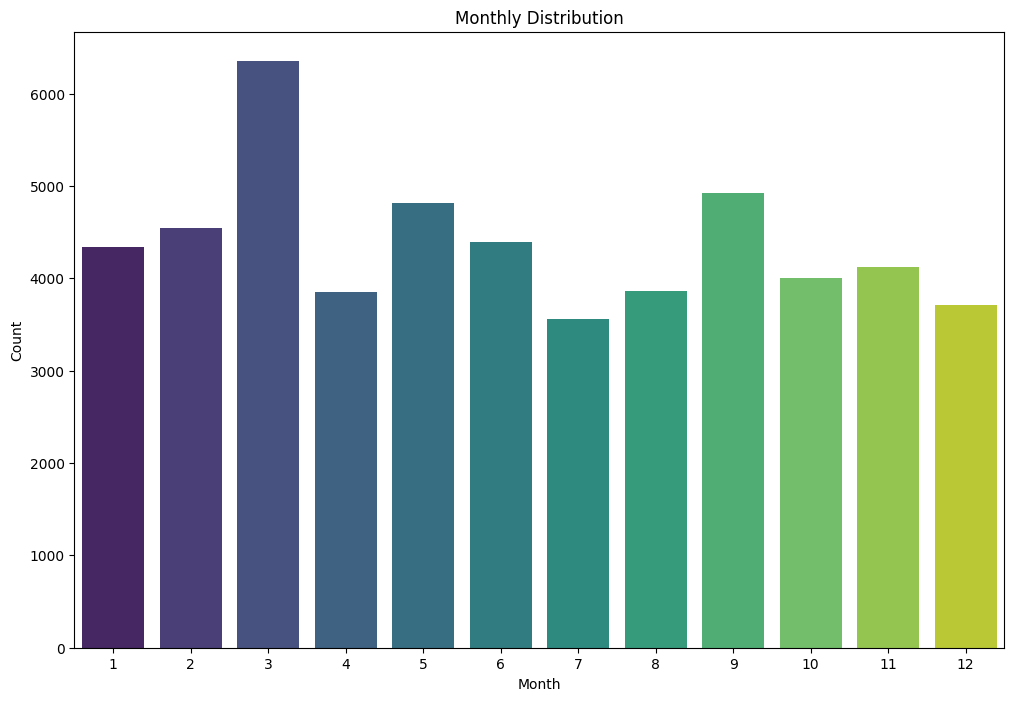

In [85]:

# Plot the monthly distribution using Seaborn
plt.figure(figsize=(12, 8))
sns.countplot(data=upheld_df, x='month', palette='viridis')
plt.title('Monthly Distribution')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

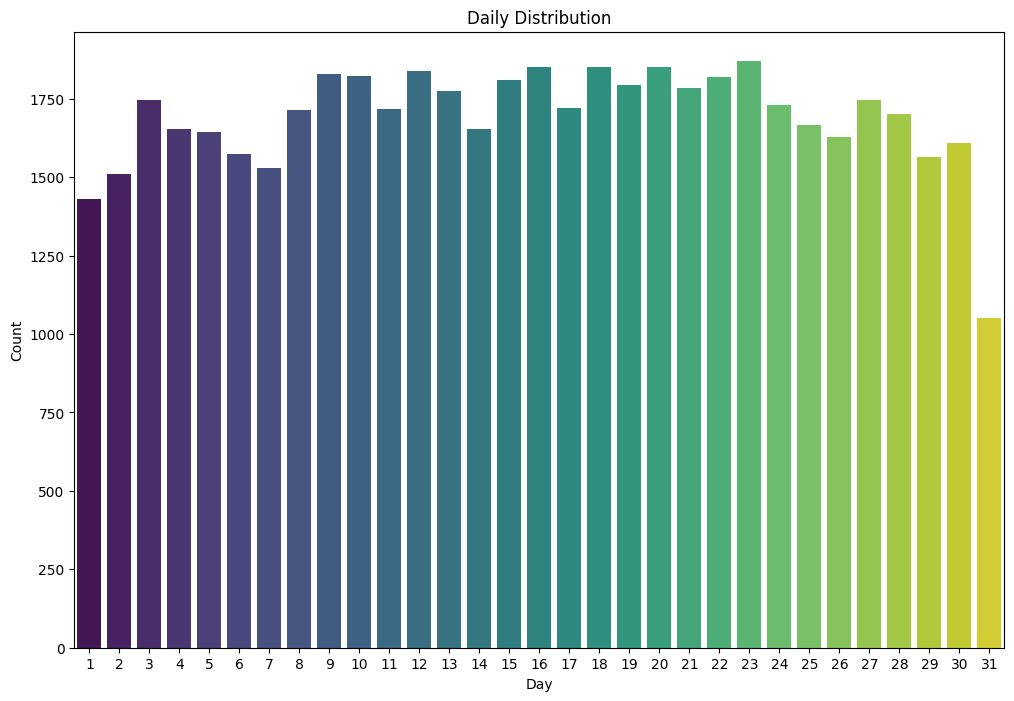

In [86]:
# Plot the daily distribution using Seaborn
plt.figure(figsize=(12, 8))
sns.countplot(data=upheld_df, x='day', palette='viridis')
plt.title('Daily Distribution')
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()

#### CALCULATING THE RATIO OF UPHELD CLAIMS

In [87]:
# Aggregated over the Year

In [88]:

# Calculate the total number of claims per year
total_claims_per_year = new_df.groupby('year').size()
# Calculate the number of upheld claims per year
upheld_claims_per_year = upheld_df.groupby('year').size()

In [89]:
# Calculate the ratio of upheld claims to total claims per year
ratio_per_year_1 = (upheld_claims_per_year / total_claims_per_year).reset_index()
ratio_per_year_1.columns = ['year', 'ratio']
ratio_per_year_1 = ratio_per_year_1.fillna(0)  # Fill NaN values with 0 if there are years with no upheld claims

In [90]:
ratio_per_year_1

year     ratio
0   2013  0.368763
1   2014  0.230339
2   2015  0.453085
3   2016  0.325373
4   2017  0.258856
5   2018  0.412420
6   2019  0.263676
7   2020  0.254348
8   2021  0.248719
9   2022  0.348567
10  2023  0.465981
11  2024  0.477411

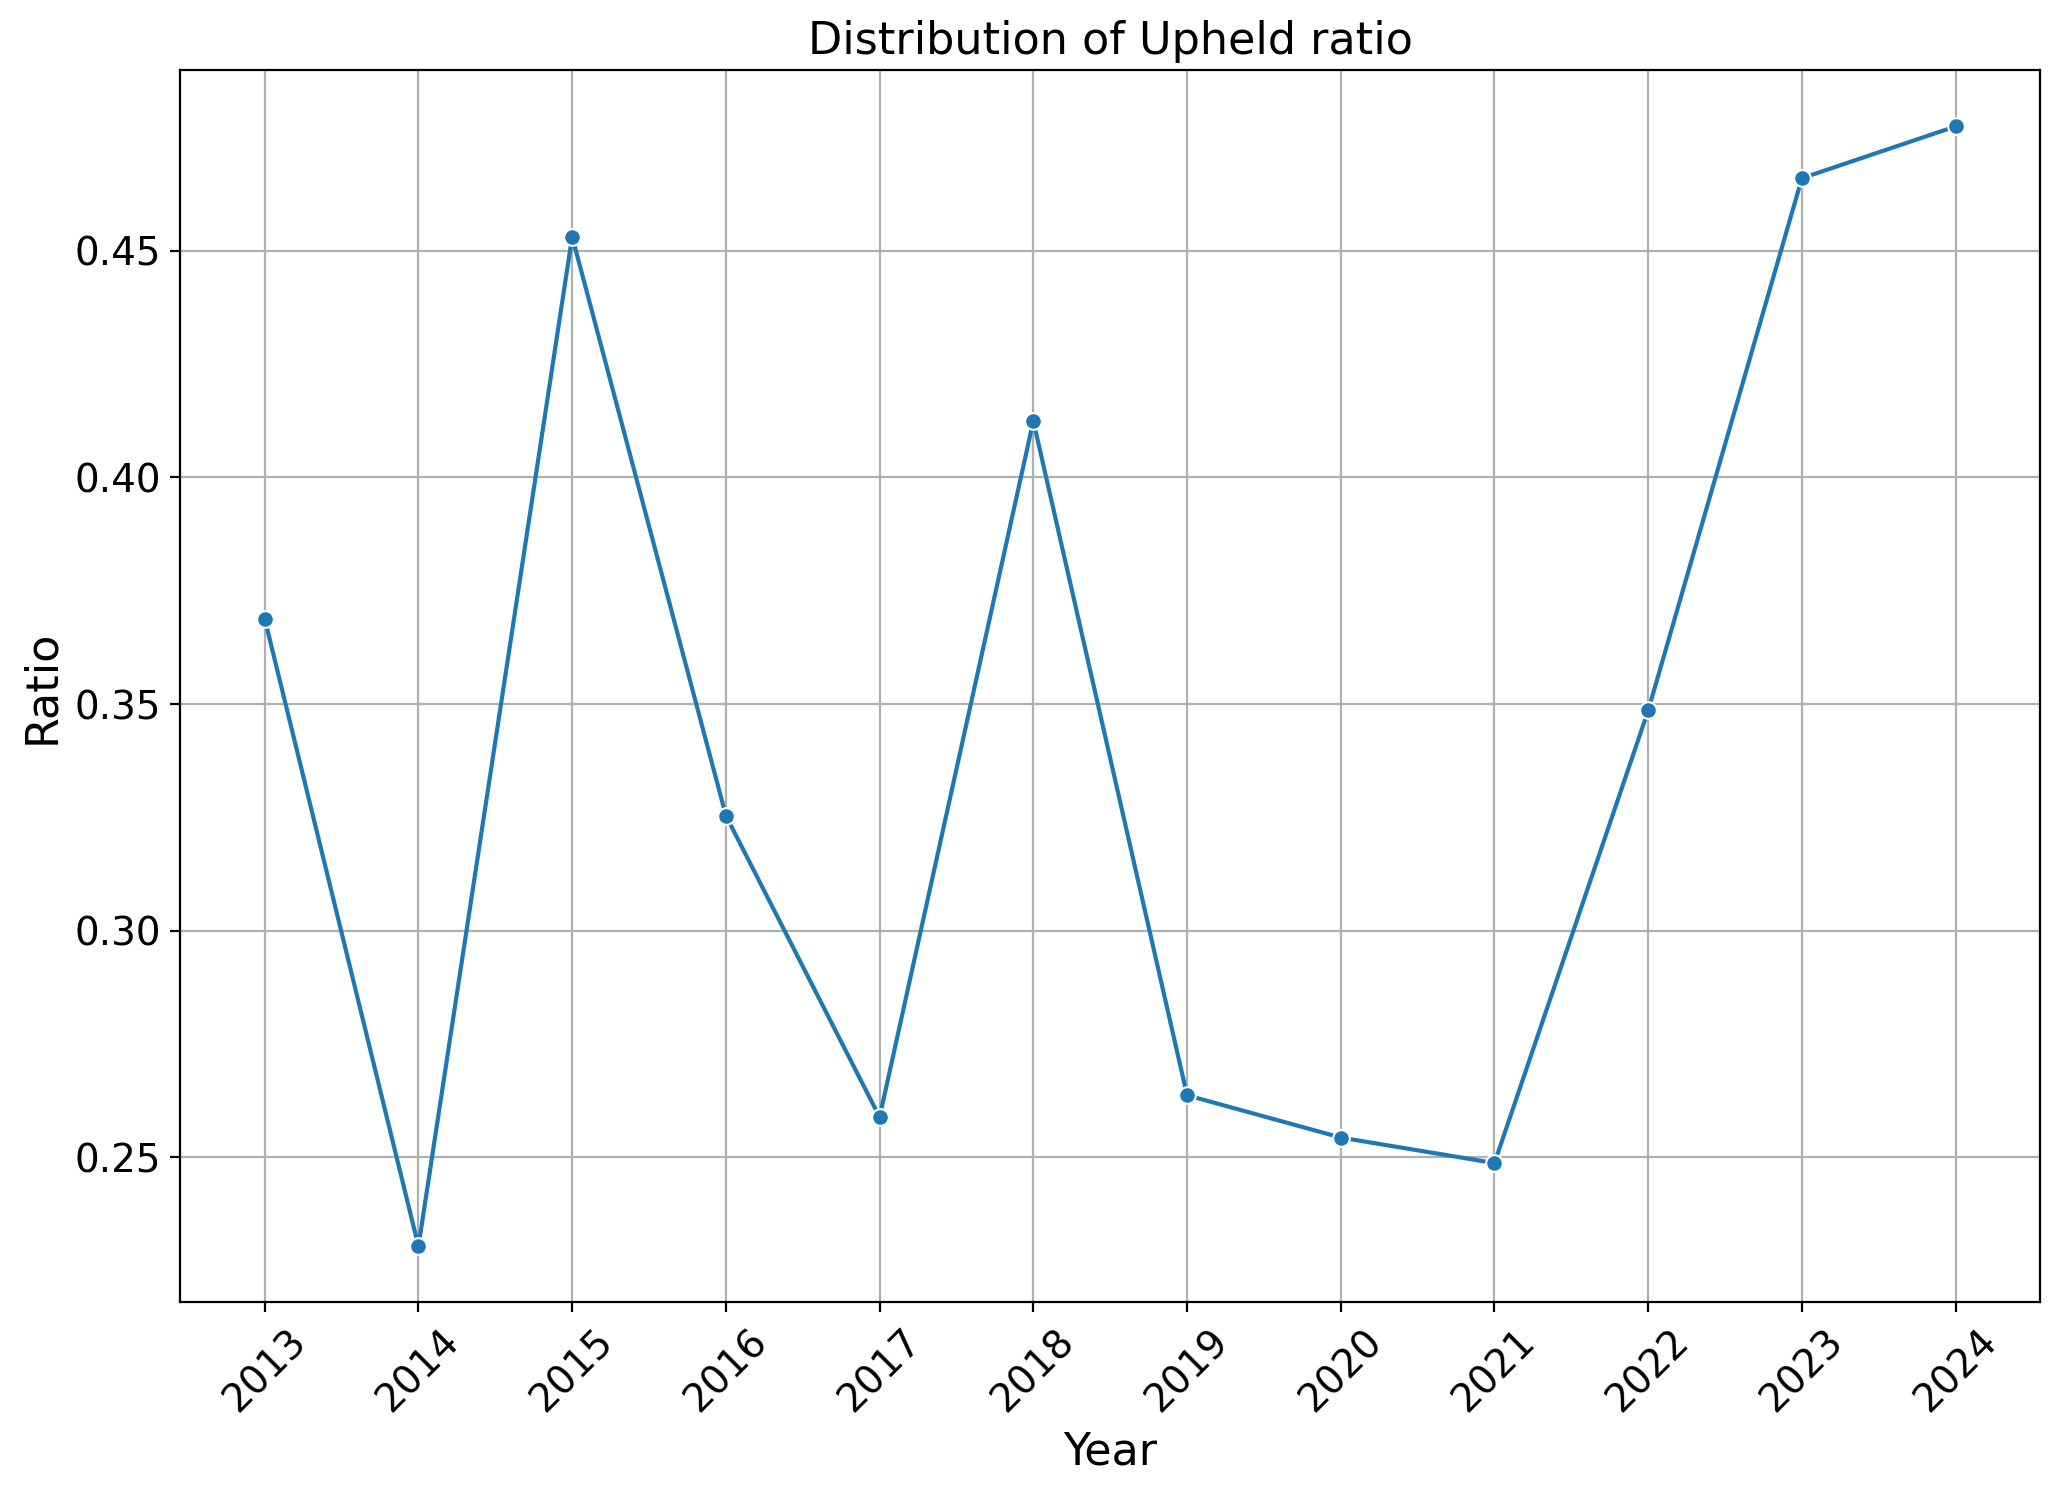

In [91]:

# Line Plot for the upheld ratio across years present.

plt.figure(figsize=(12, 8), dpi = 200)
sns.lineplot(data=ratio_per_year_1, x='year', y='ratio', marker='o')
plt.title('Distribution of Upheld ratio', fontsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Ratio', fontsize = 16)

plt.xticks(ratio_per_year_1['year'], rotation=45, fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)
plt.show()

In [92]:
# Aggregated over the Month

In [93]:
total_claims_per_month = new_df.groupby('month').size()
upheld_claims_per_month = upheld_df.groupby('month').size()

ratio_per_month_1 = (upheld_claims_per_month / total_claims_per_month).reset_index()
ratio_per_month_1.columns = ['month','ratio']
ratio_per_month_1 = ratio_per_month_1.fillna(0)

In [94]:
ratio_per_month_1

month     ratio
0       1  0.311835
1       2  0.355817
2       3  0.380967
3       4  0.332441
4       5  0.361122
5       6  0.330749
6       7  0.293068
7       8  0.314035
8       9  0.340220
9      10  0.299282
10     11  0.297642
11     12  0.293866

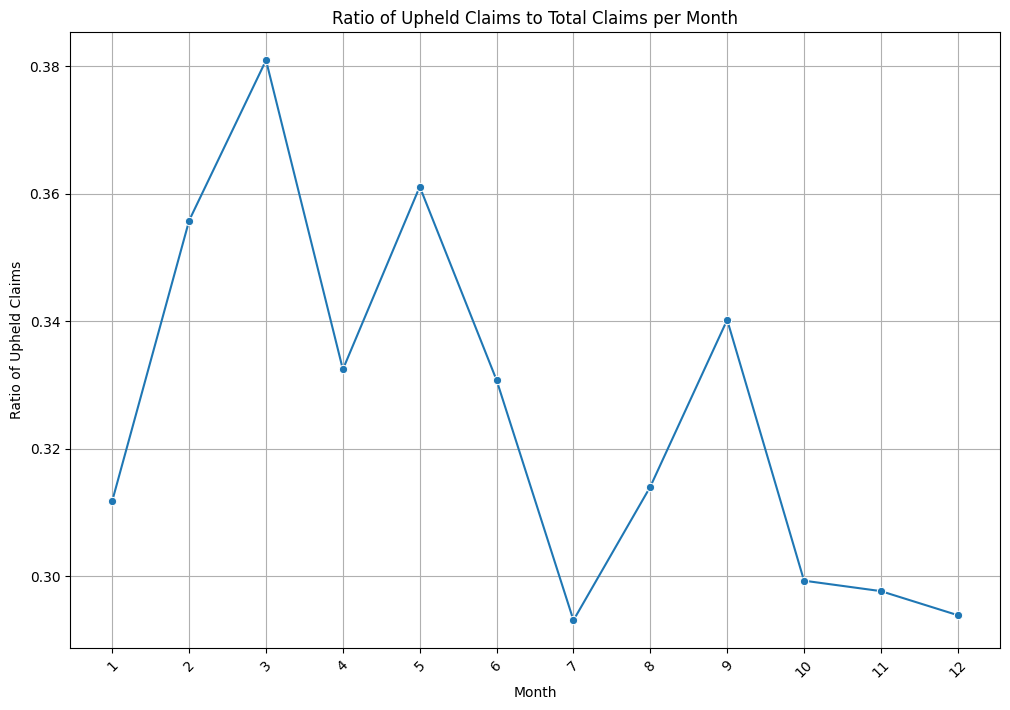

In [95]:
# Plot the ratio across months
plt.figure(figsize=(12, 8))
sns.lineplot(data=ratio_per_month_1, x='month', y='ratio', marker='o')
plt.title('Ratio of Upheld Claims to Total Claims per Month')
plt.xlabel('Month')
plt.ylabel('Ratio of Upheld Claims')
plt.xticks(ratio_per_month_1['month'], rotation=45)
plt.grid(True)
plt.show()

### ***NOT UPHELD DECISION ANALYSIS***

In [96]:
not_upheld_df = new_df[new_df['decision'] == 'Not upheld']

In [97]:
not_upheld_df.shape

(107866, 16)

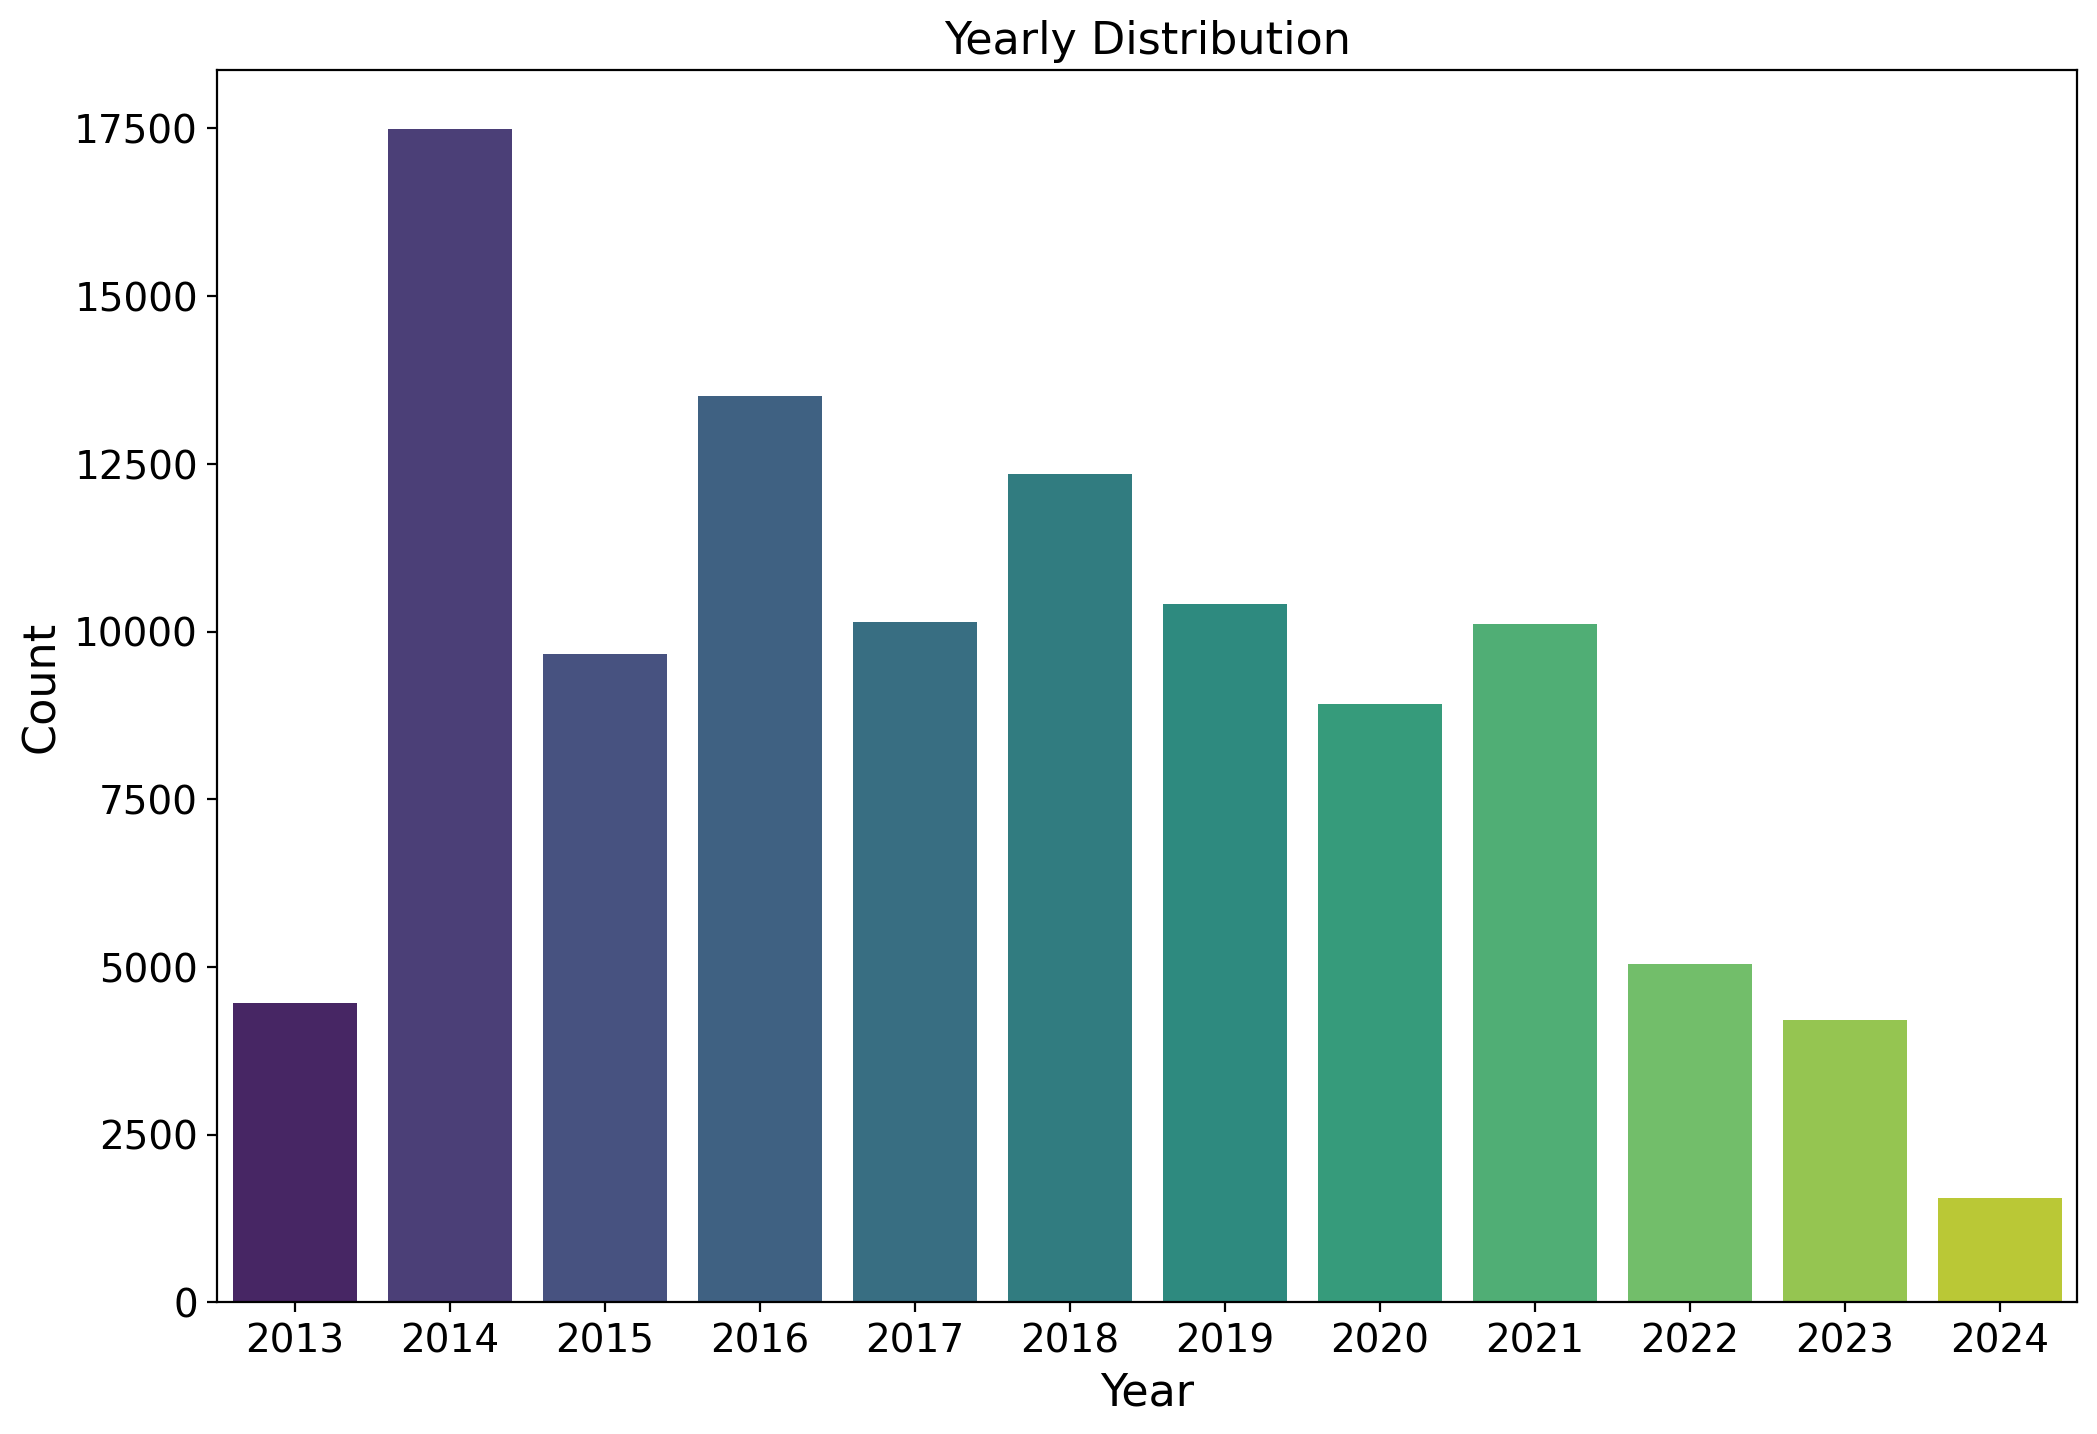

In [98]:
# Bar Plot indicating the yearly distribution using Seaborn package.
# Corresponds fo Figure 5 in the report.


plt.figure(figsize=(12, 8), dpi = 200)
sns.countplot(data=not_upheld_df, x='year', palette='viridis')
plt.title('Yearly Distribution', fontsize = 16)
plt.xlabel('Year', fontsize = 16)
plt.ylabel('Count', fontsize = 16)

plt.xticks(fontsize=14) # Describing the size of the X axis numeric values.
plt.yticks(fontsize=14) # Describing the size of the Y axis numeric values.
plt.show()

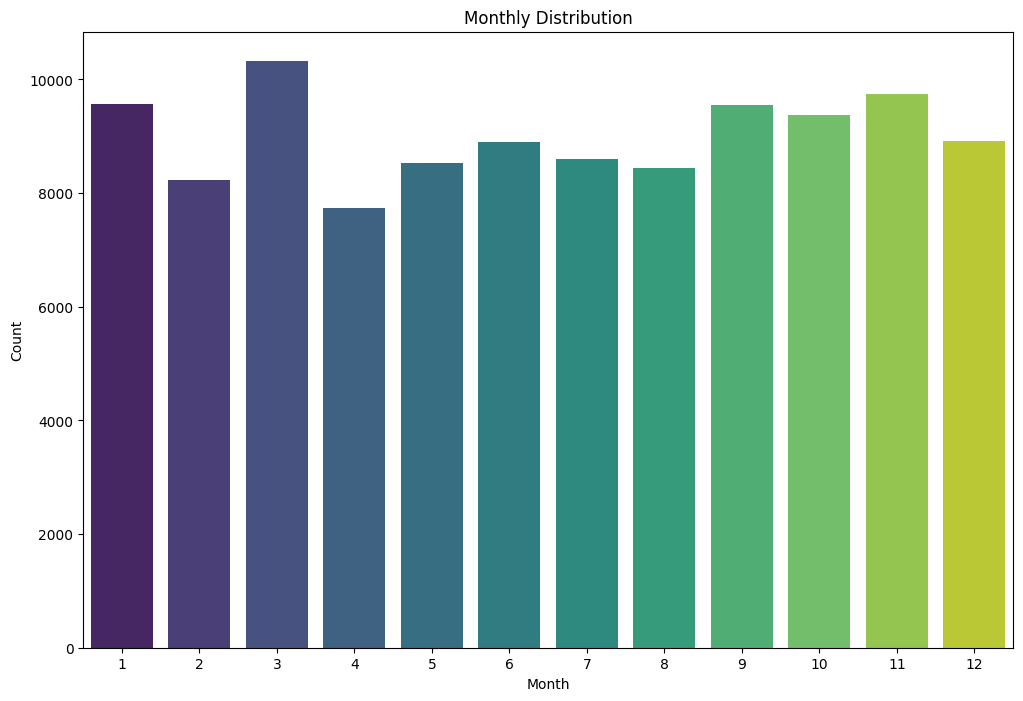

In [99]:
# Plot the monthly distribution using Seaborn
plt.figure(figsize=(12, 8))
sns.countplot(data=not_upheld_df, x='month', palette='viridis')
plt.title('Monthly Distribution')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

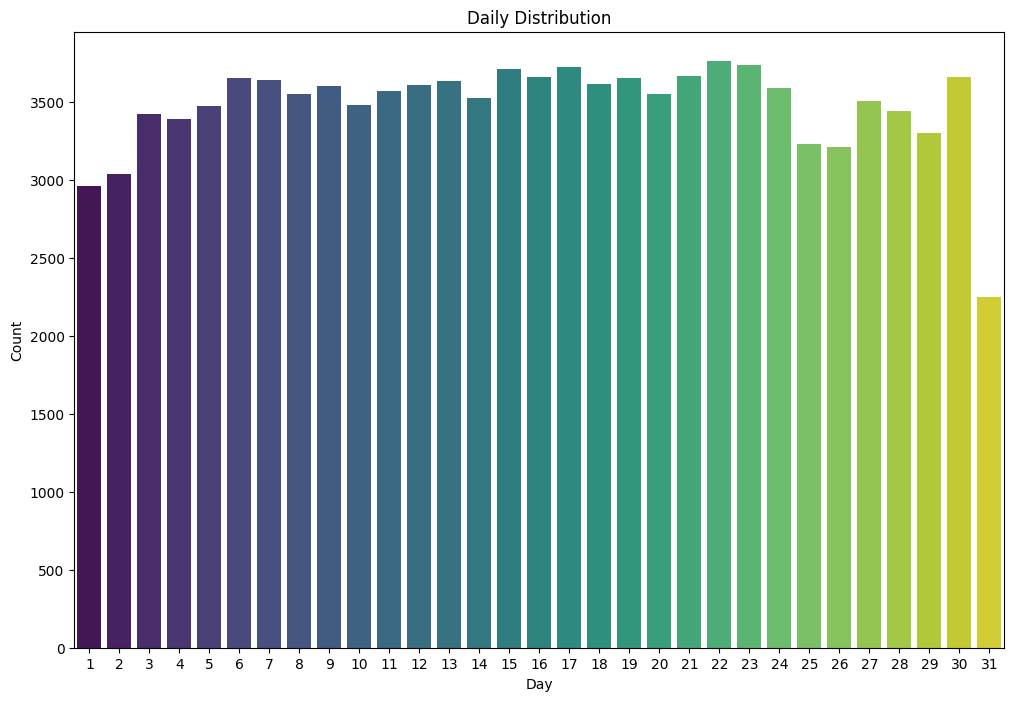

In [100]:
# Plot the daily distribution using Seaborn
plt.figure(figsize=(12, 8))
sns.countplot(data=not_upheld_df, x='day', palette='viridis')
plt.title('Daily Distribution')
plt.xlabel('Day')
plt.ylabel('Count')
plt.show()

#### CALCULATING THE RATIO

In [101]:
# Aggregated over the Year

In [102]:
# Calculate the total number of claims per year
total_claims_per_year = new_df.groupby('year').size()

# Calculate the number of upheld claims per year
not_upheld_claims_per_year = not_upheld_df.groupby('year').size()

In [103]:
# Calculate the ratio of upheld claims to total claims per year
ratio_per_year_2 = (not_upheld_claims_per_year / total_claims_per_year).reset_index()
ratio_per_year_2.columns = ['year', 'ratio']
ratio_per_year_2 = ratio_per_year_2.fillna(0)  # Fill NaN values with 0 if there are years with no upheld claims


In [104]:
ratio_per_year_2

year     ratio
0   2013  0.631237
1   2014  0.769661
2   2015  0.546915
3   2016  0.674627
4   2017  0.741144
5   2018  0.587580
6   2019  0.736324
7   2020  0.745652
8   2021  0.751281
9   2022  0.651433
10  2023  0.534019
11  2024  0.522589

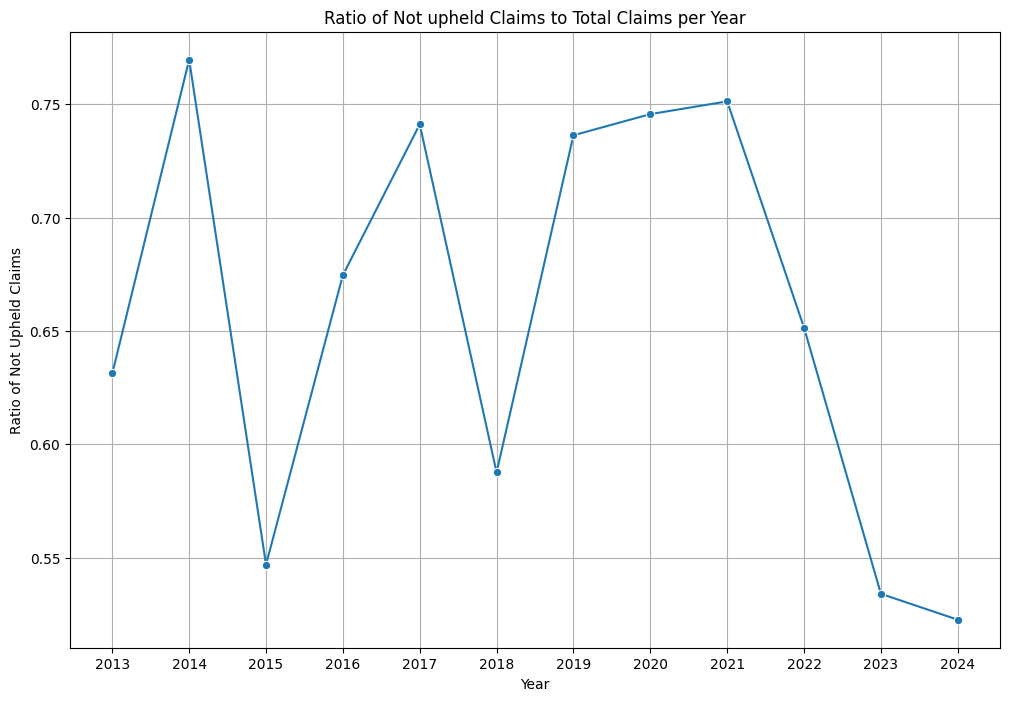

In [105]:
# Plot the ratio across years
plt.figure(figsize=(12, 8))
sns.lineplot(data=ratio_per_year_2, x='year', y='ratio', marker='o')
plt.title('Ratio of Not upheld Claims to Total Claims per Year')
plt.xlabel('Year')
plt.ylabel('Ratio of Not Upheld Claims')
plt.xticks(ratio_per_year_2['year'], rotation=0)
plt.grid(True)
plt.show()

In [106]:
# Aggregated over the Month

In [107]:
# Calculate the number of upheld claims per year
not_upheld_claims_per_month = not_upheld_df.groupby('month').size()

# Calculate the ratio of upheld claims to total claims per year
ratio_per_month_2 = (not_upheld_claims_per_month / total_claims_per_month).reset_index()
ratio_per_month_2.columns = ['month', 'ratio']
ratio_per_month_2 = ratio_per_month_2.fillna(0)  # Fill NaN values with 0 if there are years with no upheld claims

In [108]:
ratio_per_month_2

month     ratio
0       1  0.688165
1       2  0.644183
2       3  0.619033
3       4  0.667559
4       5  0.638878
5       6  0.669251
6       7  0.706932
7       8  0.685965
8       9  0.659780
9      10  0.700718
10     11  0.702358
11     12  0.706134

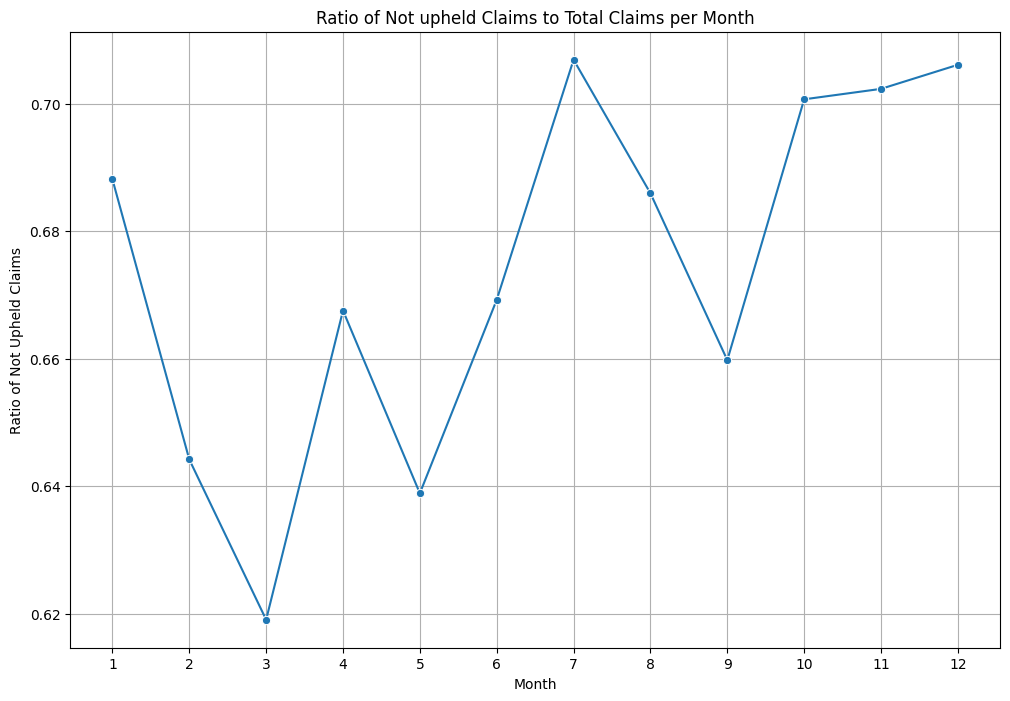

In [109]:
# Plot the ratio across years
plt.figure(figsize=(12, 8))
sns.lineplot(data=ratio_per_month_2, x='month', y='ratio', marker='o')
plt.title('Ratio of Not upheld Claims to Total Claims per Month')
plt.xlabel('Month')
plt.ylabel('Ratio of Not Upheld Claims')
plt.xticks(ratio_per_month_2['month'], rotation=0)
plt.grid(True)
plt.show()

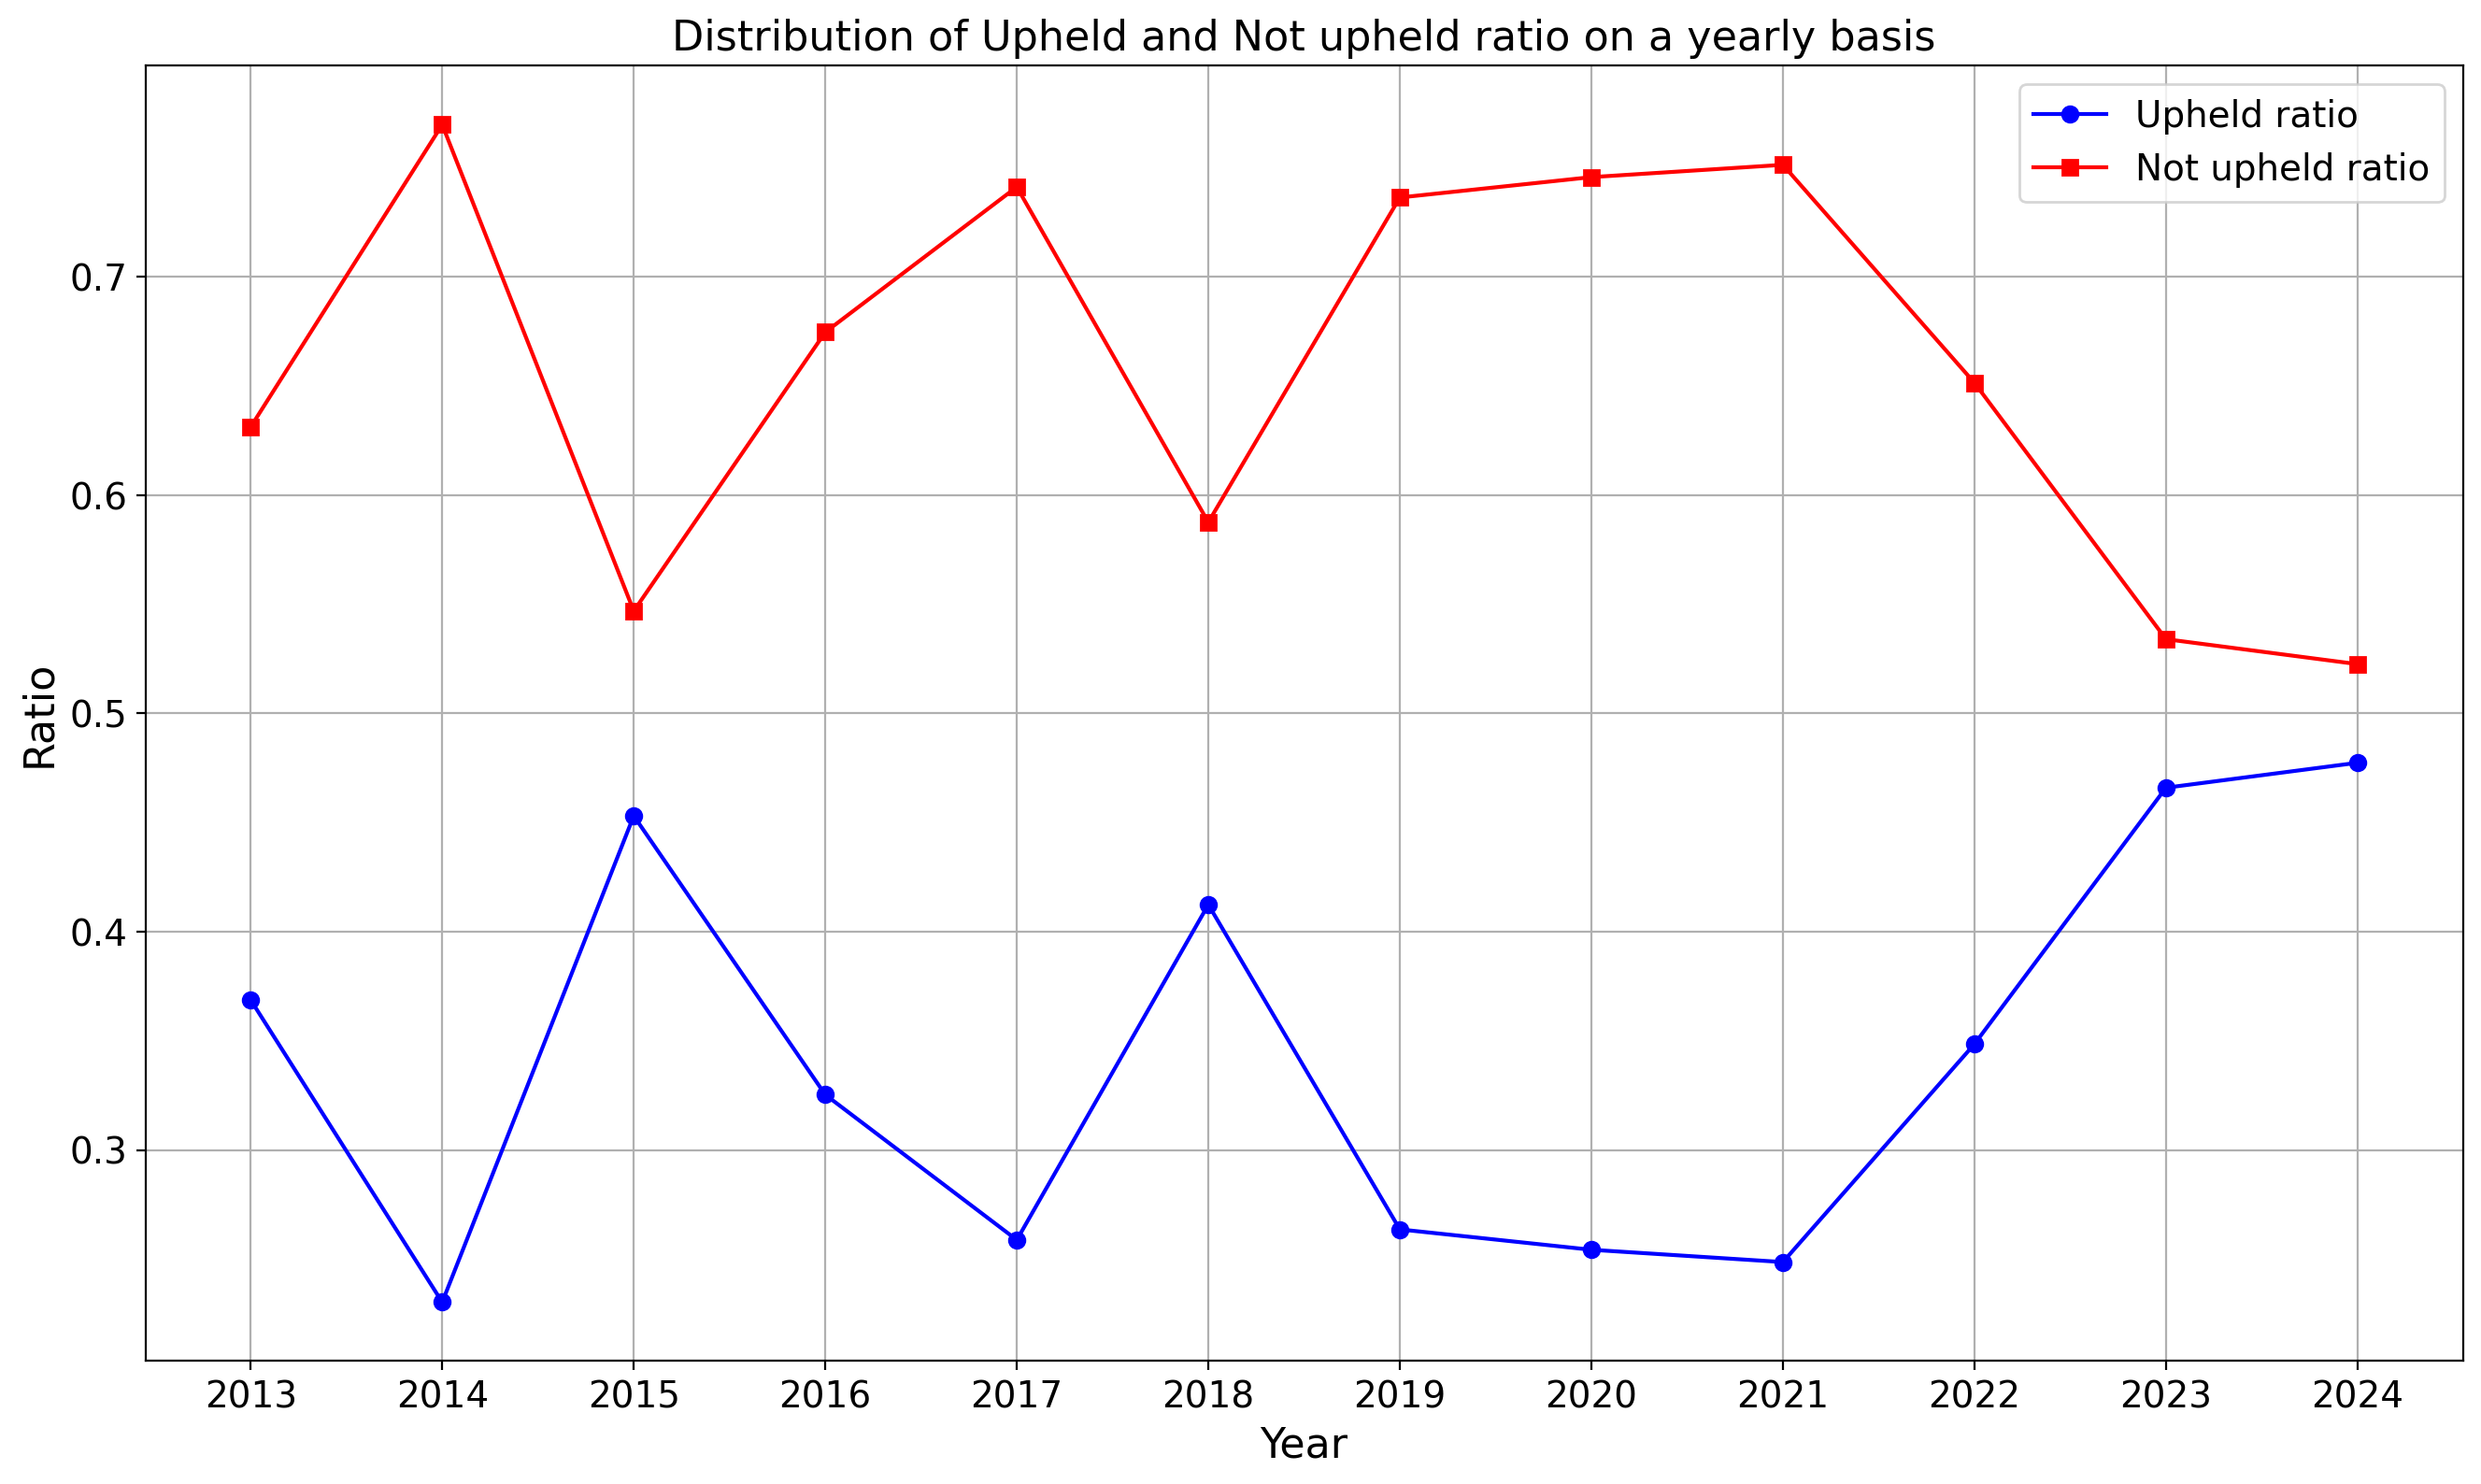

In [110]:
# Two lineplots on a single workspace depicting upheld and not upheld ratio respectively..
# Corresponding to Figure 6 in the report

fig, ax = plt.subplots(figsize=(16, 9), dpi=200)

# Plotting upheld ratio
ax.plot(ratio_per_year_1['year'], ratio_per_year_1['ratio'], marker='o', linestyle='-', color='b', label='Upheld ratio')

# Plotting not upheld ratio
ax.plot(ratio_per_year_2['year'], ratio_per_year_2['ratio'], marker='s', linestyle='-', color='r', label='Not upheld ratio')

# Labels and title
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Ratio', fontsize=16)
ax.set_title('Distribution of Upheld and Not upheld ratio on a yearly basis', fontsize=16)


ax.set_xticks(ratio_per_year_1['year'])
# Tick parameters
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# Grid
ax.grid(True)


# Legend
ax.legend(loc='upper right', fontsize=14)
# Show plot
plt.show()

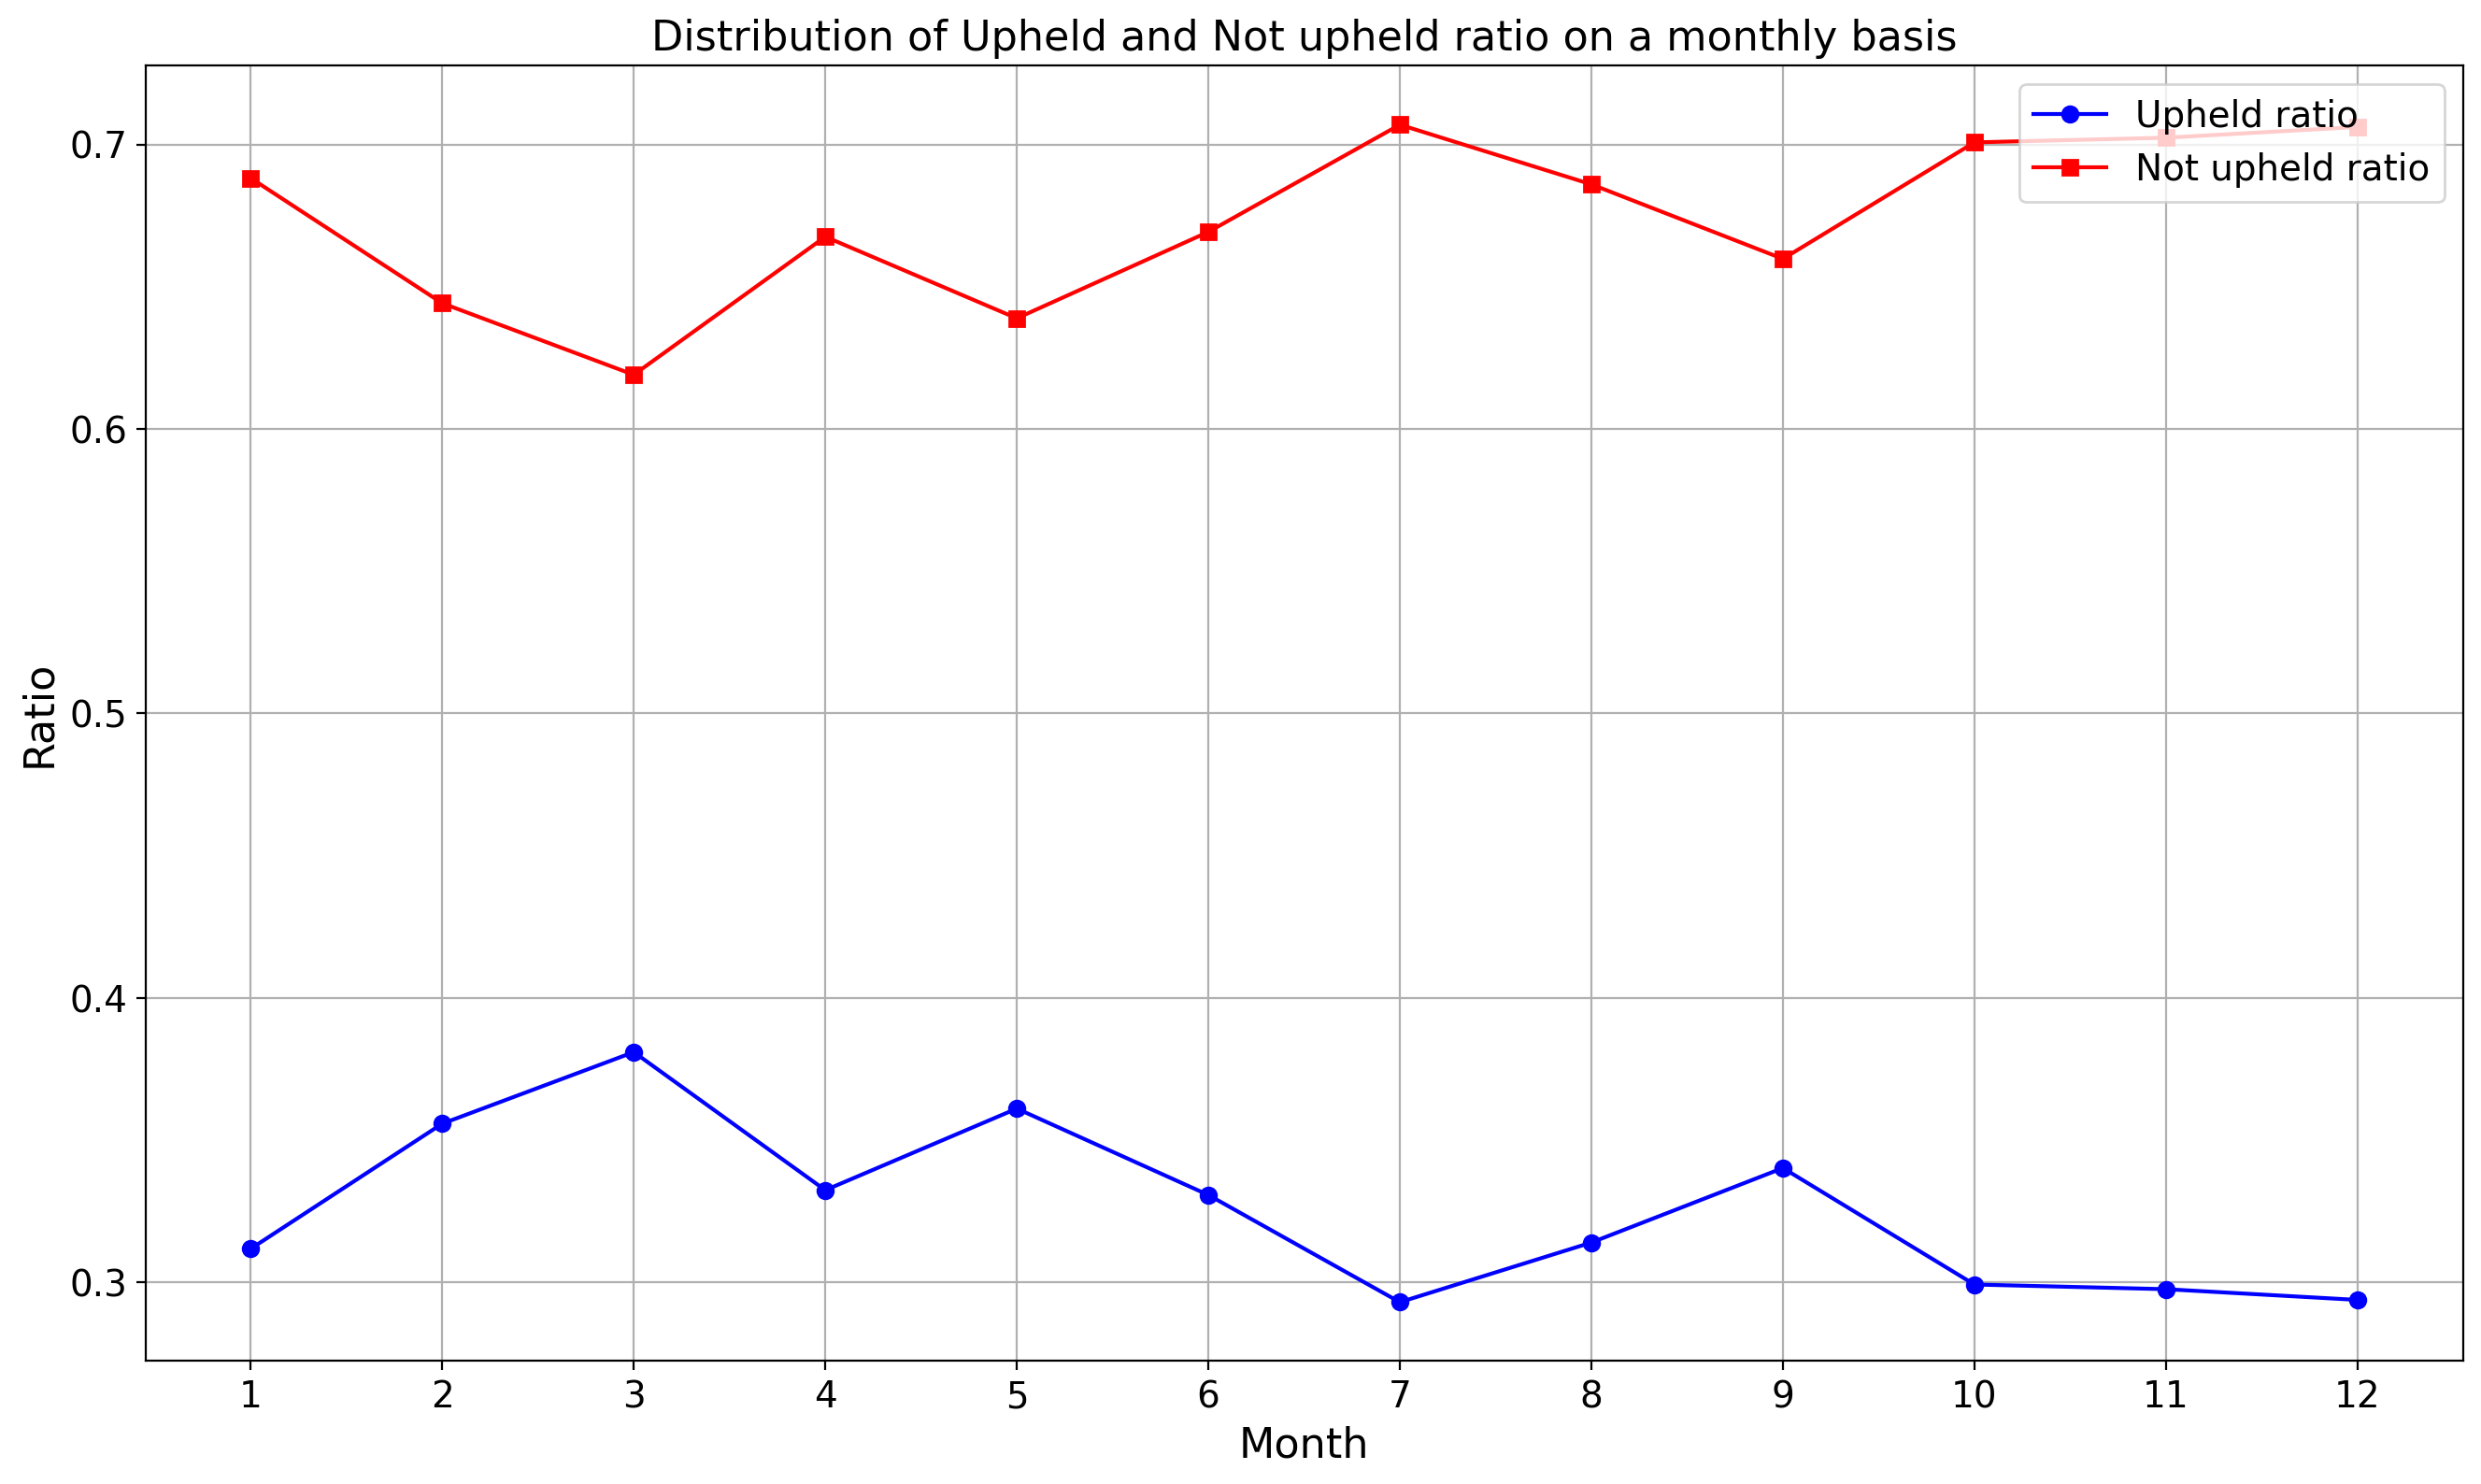

In [111]:
# Corresponds to Figure 8 in the report..

# Plotting two line plots of upheld and not upheld ratio aggregated over the months present in a single workspace.

fig, ax = plt.subplots(figsize=(16, 9), dpi=200)

# Plotting upheld ratio
ax.plot(ratio_per_month_1['month'], ratio_per_month_1['ratio'], marker='o', linestyle='-', color='b', label='Upheld ratio')

# Plotting not upheld ratio
ax.plot(ratio_per_month_2['month'], ratio_per_month_2['ratio'], marker='s', linestyle='-', color='r', label='Not upheld ratio')

# Labels and title
ax.set_xlabel('Month', fontsize=16)
ax.set_ylabel('Ratio', fontsize=16)
ax.set_title('Distribution of Upheld and Not upheld ratio on a monthly basis', fontsize=16)

ax.set_xticks(ratio_per_month_1['month'])
# Tick parameters
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# Grid
ax.grid(True)


# Legend
ax.legend(loc='upper right', fontsize=14)
# Show plot
plt.show()


## ***TEXT DATA ANALYSIS***

### ***WORD AND CHARACTER COUNT***

In [112]:

# Define the text_statistics function
def text_statistics(text):
    # Remove punctuation and convert text to lowercase
    cleaned_text = re.sub(r'[^\w\s]', '', text.lower())

    # Tokenize text into words
    words = cleaned_text.split()

    # Total word count
    total_word_count = len(words)

    # Unique word count
    unique_word_count = len(set(words))

    # Frequency distribution of words
    word_frequencies = Counter(words)

    # Most common words
    most_common_words = word_frequencies.most_common(10)

    # Average word length
    avg_word_length = sum(len(word) for word in words) / total_word_count


    # Compile statistics into a dictionary
    stats = {
        'Total Word Count': total_word_count,
        'Unique Word Count': unique_word_count,
        'Most Common Words': most_common_words,
        'Average Word Length': avg_word_length
    }

    return stats


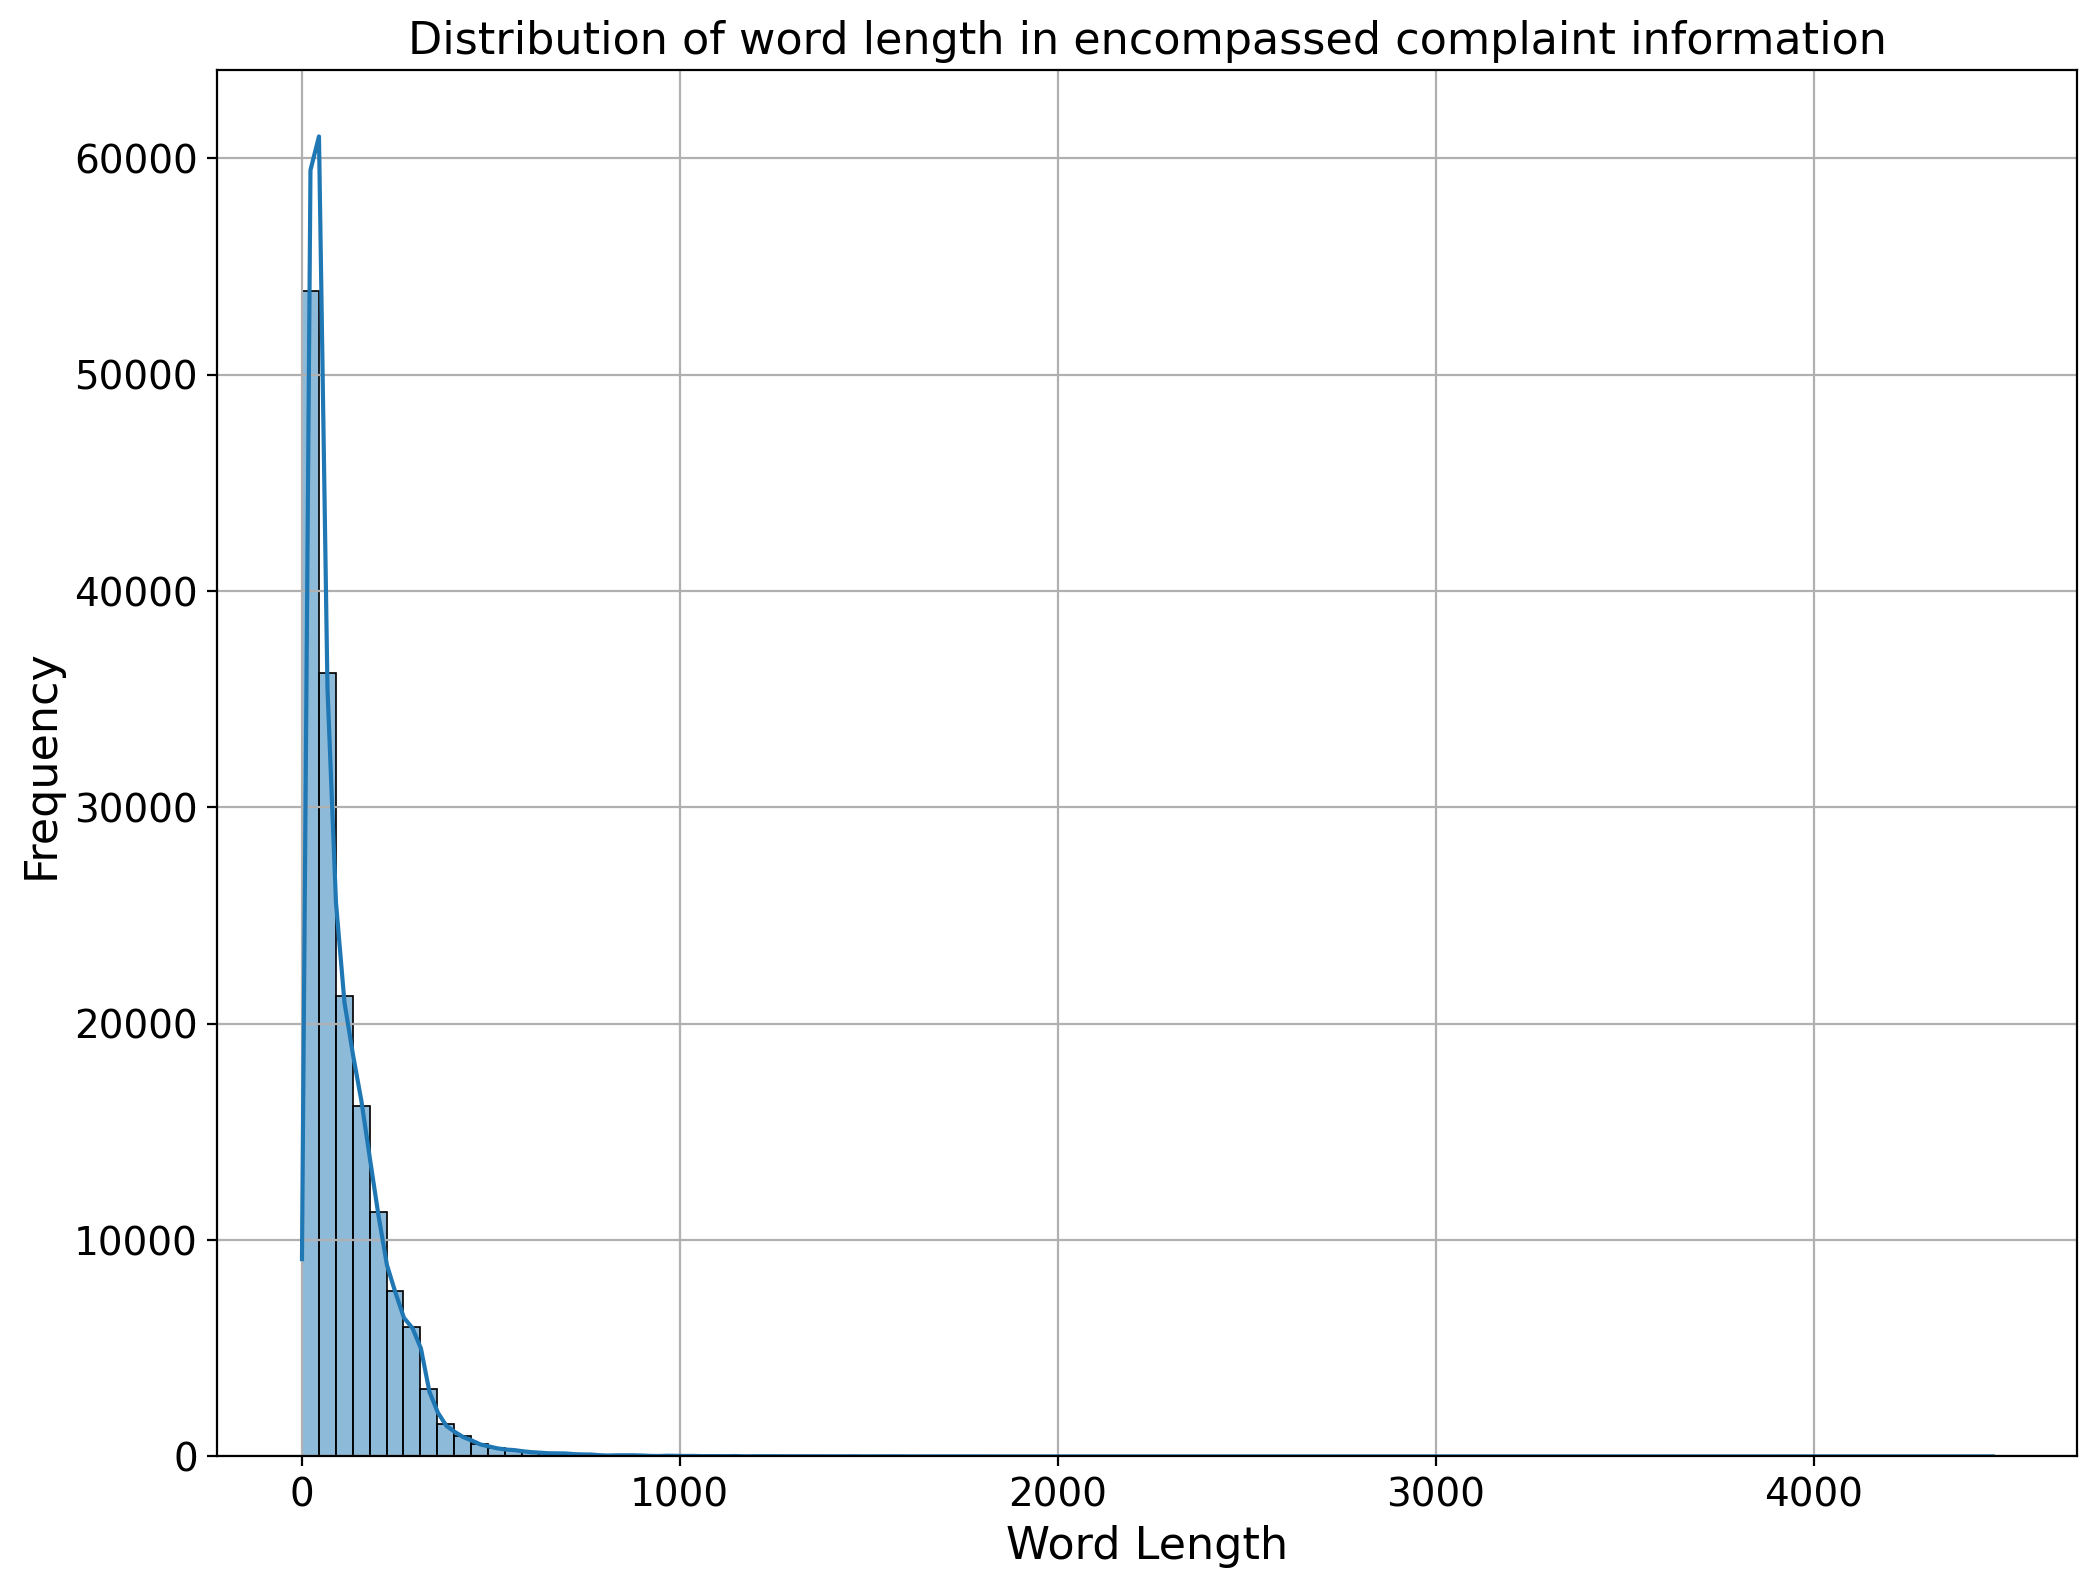

In [113]:
# Emulating the distribution histogram plot on the word length present over every complaint record present..
# Corresponding to Figure 9 in the report

new_df['word_length_complaint'] = new_df['complaint_data'].apply(lambda x: len(str(x).split()))

# Distribution of word lengths
plt.figure(figsize=(12,9), dpi = 200)
sns.histplot(new_df['word_length_complaint'], bins=100, kde=True)
plt.title('Distribution of word length in encompassed complaint information',fontsize = 16)
plt.xlabel('Word Length', fontsize = 16)
plt.ylabel('Frequency',fontsize = 16)


plt.xticks(rotation=0, fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True)
plt.show()

In [114]:
# Concatenate all text from the 'combined_data' column
all_text = ' '.join(new_df['complaint_data'])

# Get text statistics for the concatenated text
stats = text_statistics(all_text)

# Print the results
print(f"Total Word Count: {stats['Total Word Count']}")
print(f"Unique Word Count: {stats['Unique Word Count']}")
print(f"Most Common Words: {stats['Most Common Words']}")
print(f"Average Word Length: {stats['Average Word Length']:.2f}")

Total Word Count: 18263563
Unique Word Count: 33629
Most Common Words: [('policy', 569088), ('complaint', 352729), ('claim', 327392), ('insurance', 275116), ('said', 254023), ('ppi', 197639), ('adjudicator', 165067), ('say', 145249), ('would', 137056), ('b', 126213)]
Average Word Length: 6.12


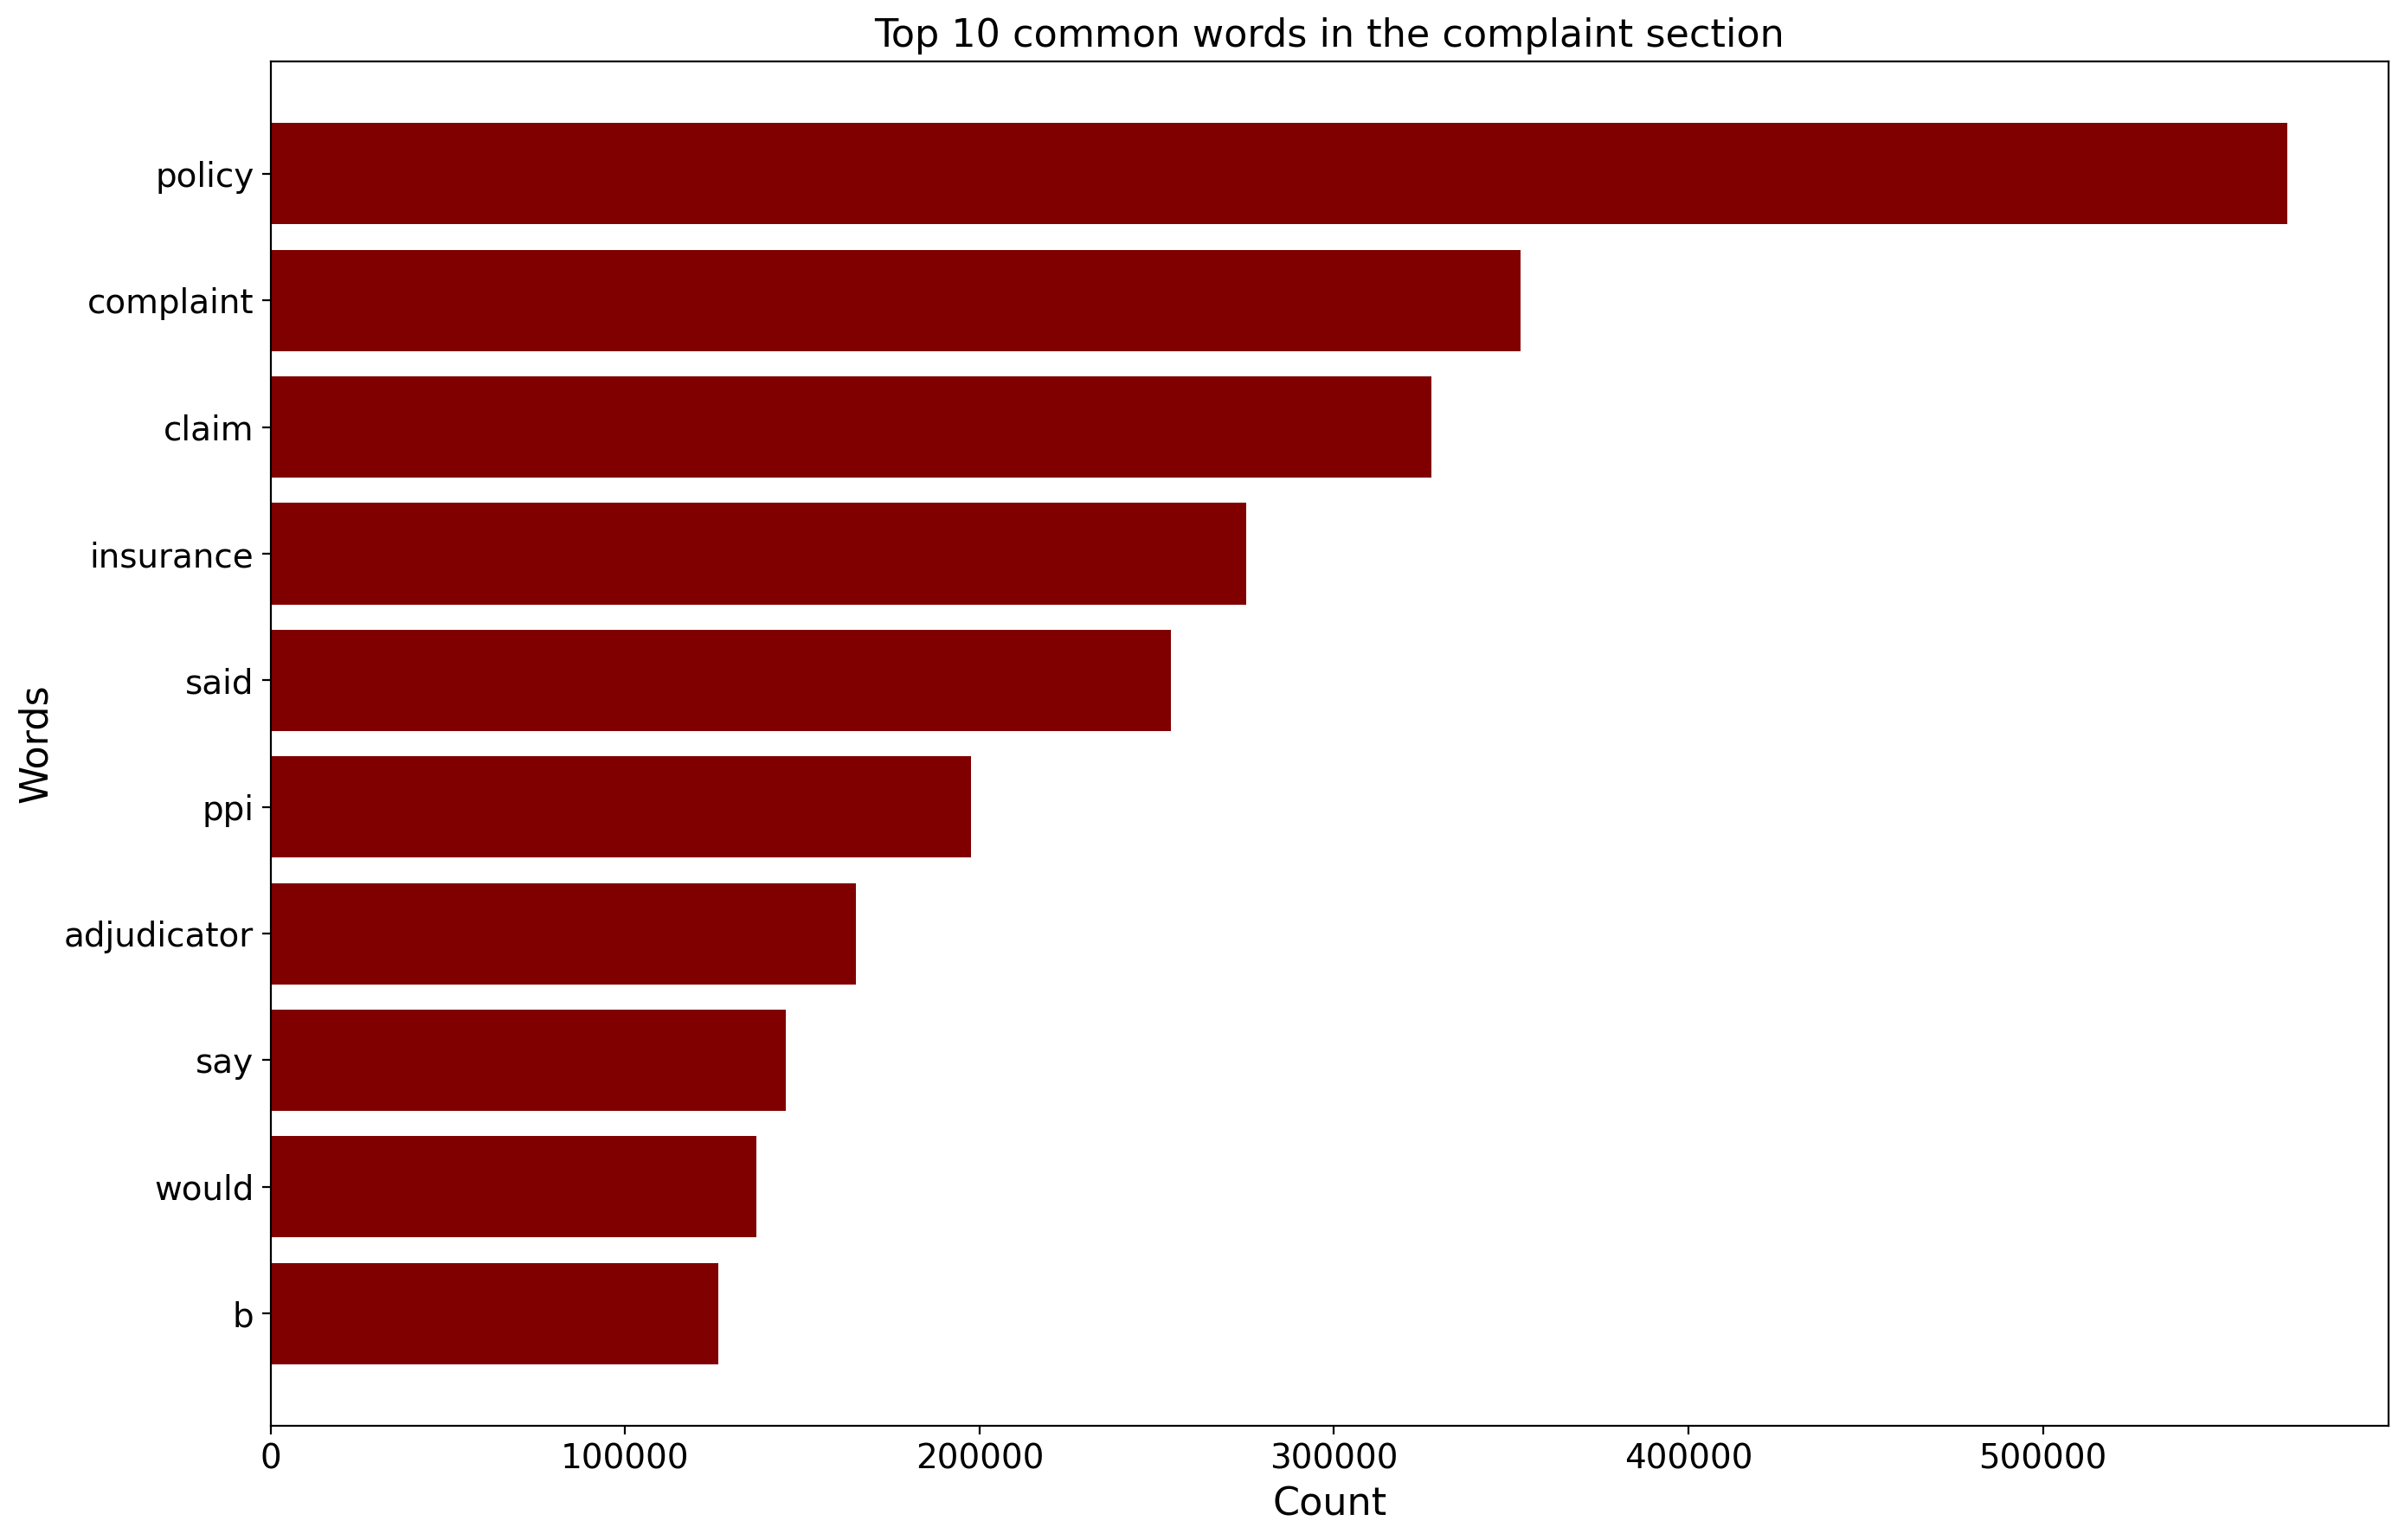

In [115]:
# Ploting the top 10 common words
#Corresponding to Figure 10 in the report..


# Separate words and their corresponding scores
words, scores = zip(*stats['Most Common Words'])

# Plotting
plt.figure(figsize=(14,9), dpi = 200)
plt.barh(words, scores, color='maroon')
plt.xlabel('Count',fontsize = 16)
plt.ylabel('Words',fontsize = 16)
plt.title('Top 10 common words in the complaint section', fontsize = 16)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest scores at the top


plt.xticks(fontsize=14) # Setting the size of the X axis values.
plt.yticks(fontsize=14) # Setting the size of the Y axis values.
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

### ***WORDCLOUD ANALYSIS***

In [117]:
# User defined function to generate the wordcloud for the text data present in the dataframe.

def generate_word_cloud(corpus_data: str, cmap: str, title: str):

    wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                          colormap = cmap, max_words = 156, contour_width = 3,
                          max_font_size = 80, contour_color = 'blue',
                          random_state = 0)

    wordcloud.generate(corpus_data)

    plt.figure(figsize=(12,8))
    plt.title(f'Word Cloud for {title}', fontsize=10)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figure()

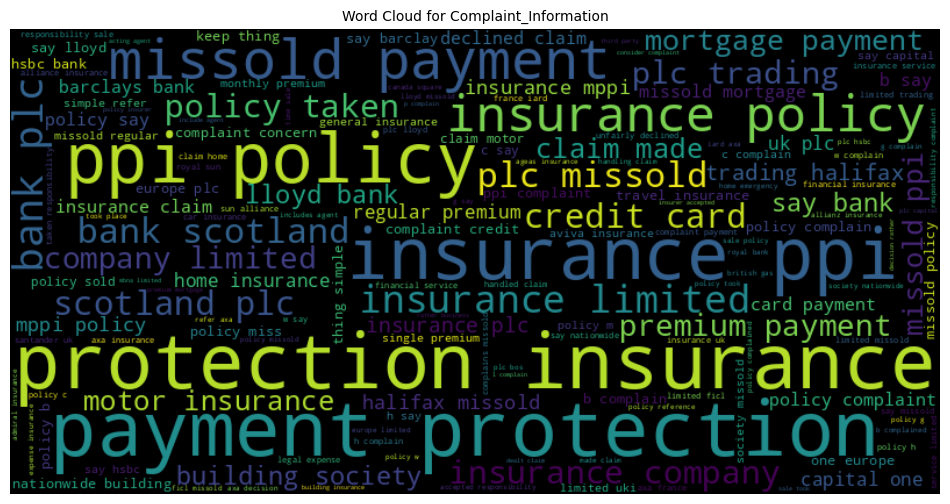

<Figure size 640x480 with 0 Axes>

In [118]:
text = ' '.join(new_df['Complaint_Info'].dropna().values)
generate_word_cloud(text, cmap = 'viridis',title = 'Complaint_Information')


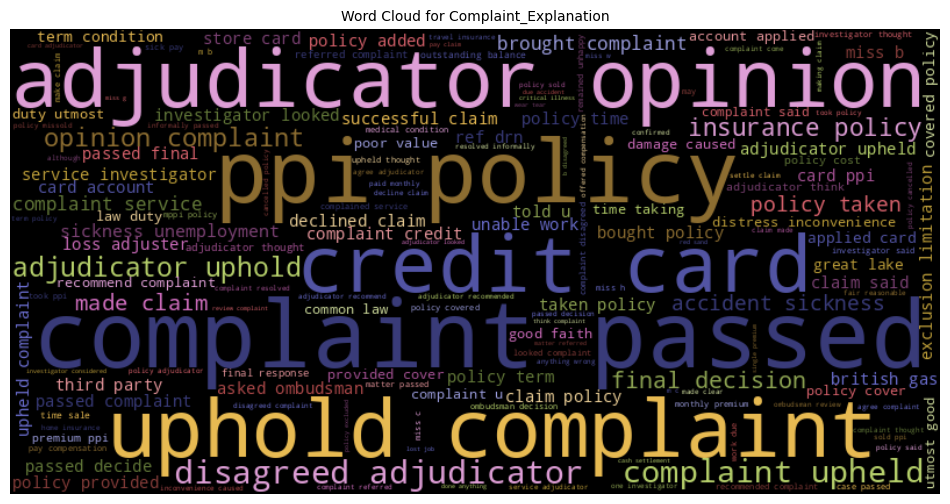

<Figure size 640x480 with 0 Axes>

In [119]:
text = ' '.join(new_df['Complaint_Explanation'].dropna().values)
generate_word_cloud(text, cmap = 'tab20b', title = 'Complaint_Explanation')


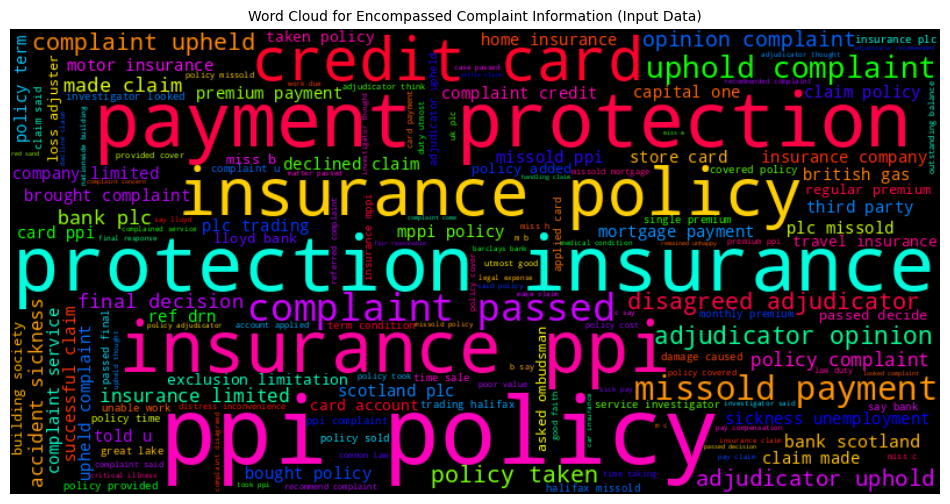

<Figure size 640x480 with 0 Axes>

In [120]:
# Wordcloud is generated for the encompassed complaint information (Input data)...
## Corresponds to Figure 11 in the report..

text = ' '.join(new_df['complaint_data'].dropna().values)
generate_word_cloud(text, cmap = 'hsv', title = 'Encompassed Complaint Information (Input Data)')

### ***FETCHING THE TOP 10 WORDS***

In [122]:
# Compute TF-IDF scores for each category
vectorizer = TfidfVectorizer(max_features=1000)

In [123]:
upheld_tfidf_matrix = vectorizer.fit_transform(upheld_df['complaint_data'])

# Extract the TF-IDF feature names
feature_names = vectorizer.get_feature_names_out()

In [124]:
# Compute mean TF-IDF scores for each decision category
upheld_tfidf_mean = upheld_tfidf_matrix.mean(axis=0).A1

In [125]:
# Get the top 10 words for each category
top_15_upheld_indices = upheld_tfidf_mean.argsort()[-15:][::-1]
top_15_upheld_words = [(feature_names[i], upheld_tfidf_mean[i]) for i in top_15_upheld_indices]

print("Top 10 words contributing to Upheld decisions:\n")
for word, score in top_15_upheld_words:
    print(f"{word}: {score}")

Top 10 words contributing to Upheld decisions:

ppi: 0.10200730472290721
policy: 0.0908806374043925
complaint: 0.06992743775242119
card: 0.062170603384583176
insurance: 0.05289360148905667
claim: 0.052534888370683853
missold: 0.05188032647240697
credit: 0.05073737479003508
protection: 0.050181620769710764
adjudicator: 0.04953421312632153
payment: 0.049239395511257784
say: 0.048393567749436185
plc: 0.04191583752767691
taken: 0.04151633524597941
bank: 0.040644828604036114


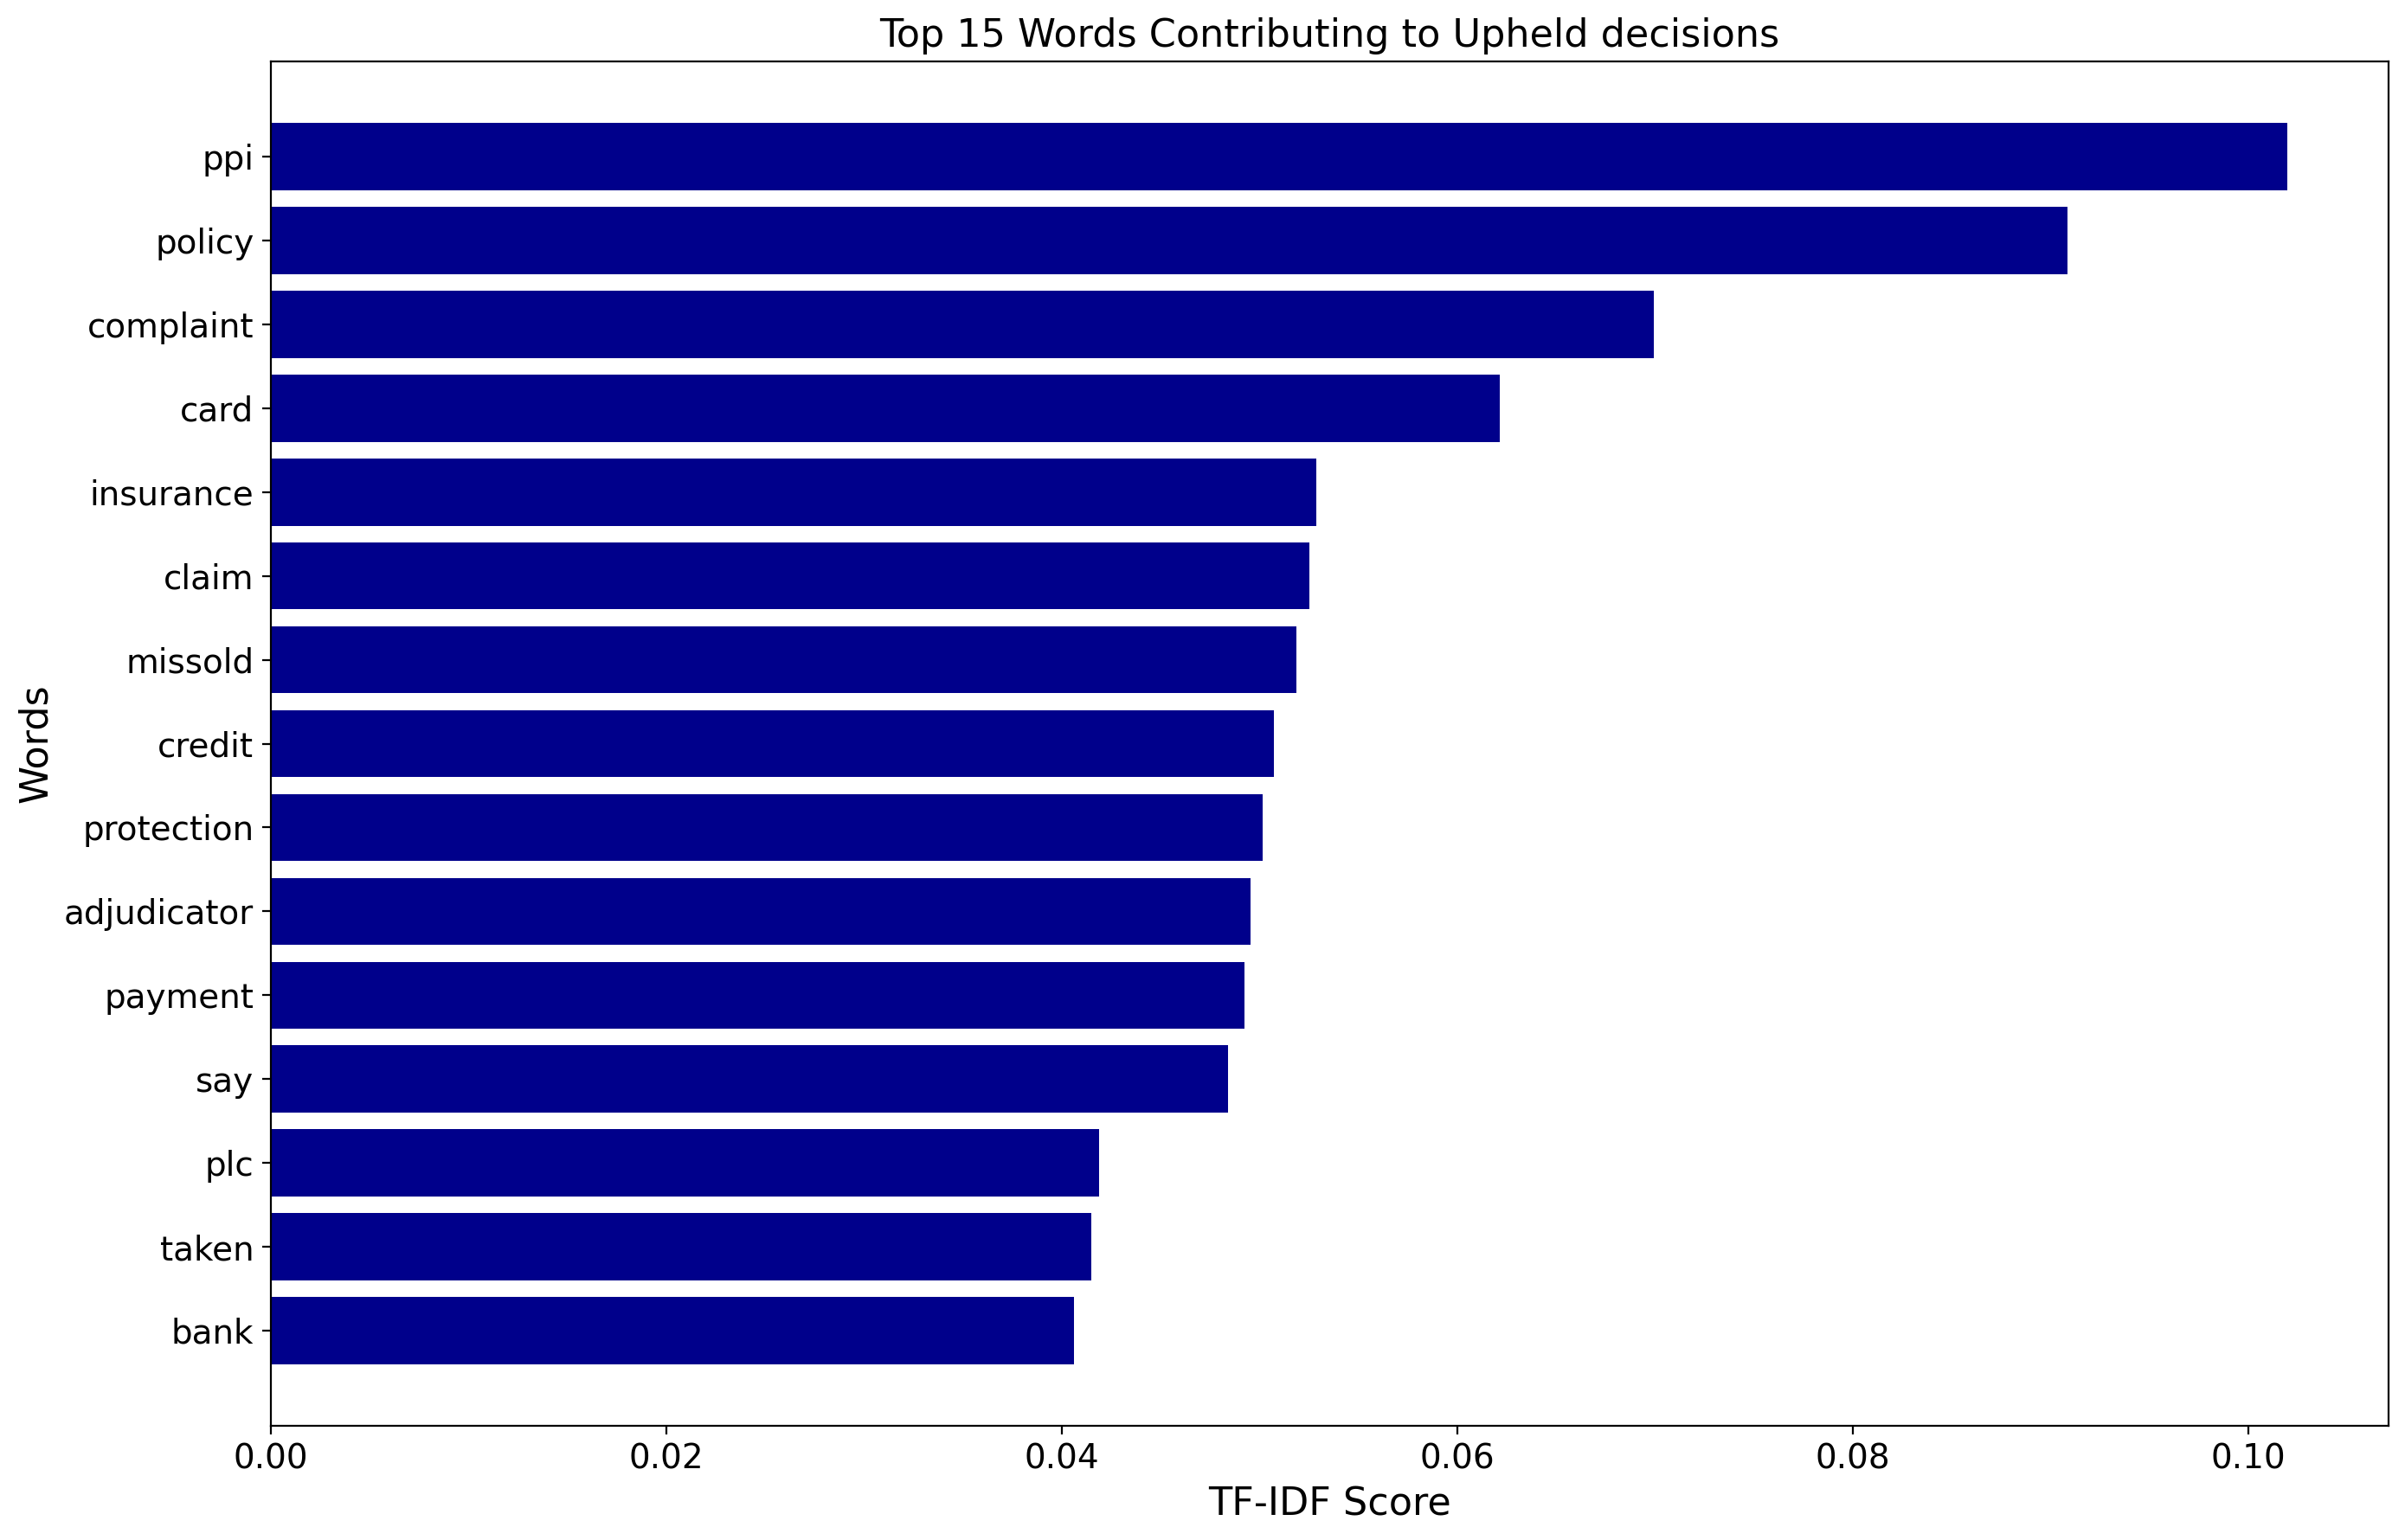

In [126]:
# Emulating the barplot which depicts the top 15 words contributing to the upheld decisions.
## Corresponds to Figure 12 in the report.

import matplotlib.pyplot as plt

# Separate words and their corresponding scores
words, scores = zip(*top_15_upheld_words)

# Plotting
plt.figure(figsize=(14,9), dpi = 200)
plt.barh(words, scores, color='darkblue')
plt.xlabel('TF-IDF Score',fontsize = 16)
plt.ylabel('Words',fontsize = 16)
plt.title('Top 15 Words Contributing to Upheld decisions', fontsize = 16)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest scores at the top


plt.xticks(fontsize=14) # Setting the size of the X axis values.
plt.yticks(fontsize=14) # Setting the size of the Y axis values.
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [127]:
not_upheld_tfidf_matrix = vectorizer.fit_transform(not_upheld_df['complaint_data'])
not_upheld_tfidf_mean = not_upheld_tfidf_matrix.mean(axis=0).A1

In [128]:
top_15_not_upheld_indices = not_upheld_tfidf_mean.argsort()[-15:][::-1]
top_15_not_upheld_words = [(feature_names[i], not_upheld_tfidf_mean[i]) for i in top_15_not_upheld_indices]

In [129]:
print("\nTop 15 words contributing to Not Upheld decisions:\n")
for word, score in top_15_not_upheld_words:
    print(f"{word}: {score}")


Top 15 words contributing to Not Upheld decisions:

point: 0.10859326716303638
position: 0.09372590024117623
company: 0.08274922662979263
adjudicator: 0.06513118877688817
cancel: 0.060509885773922426
installed: 0.053085142825934274
checked: 0.05298834981736842
mobile: 0.05170523940137591
mind: 0.05063268222997333
provided: 0.048931370676792756
passed: 0.04830605565248321
see: 0.04808549786320863
covea: 0.04619413113473383
met: 0.04408747168133762
balance: 0.044015965968254314


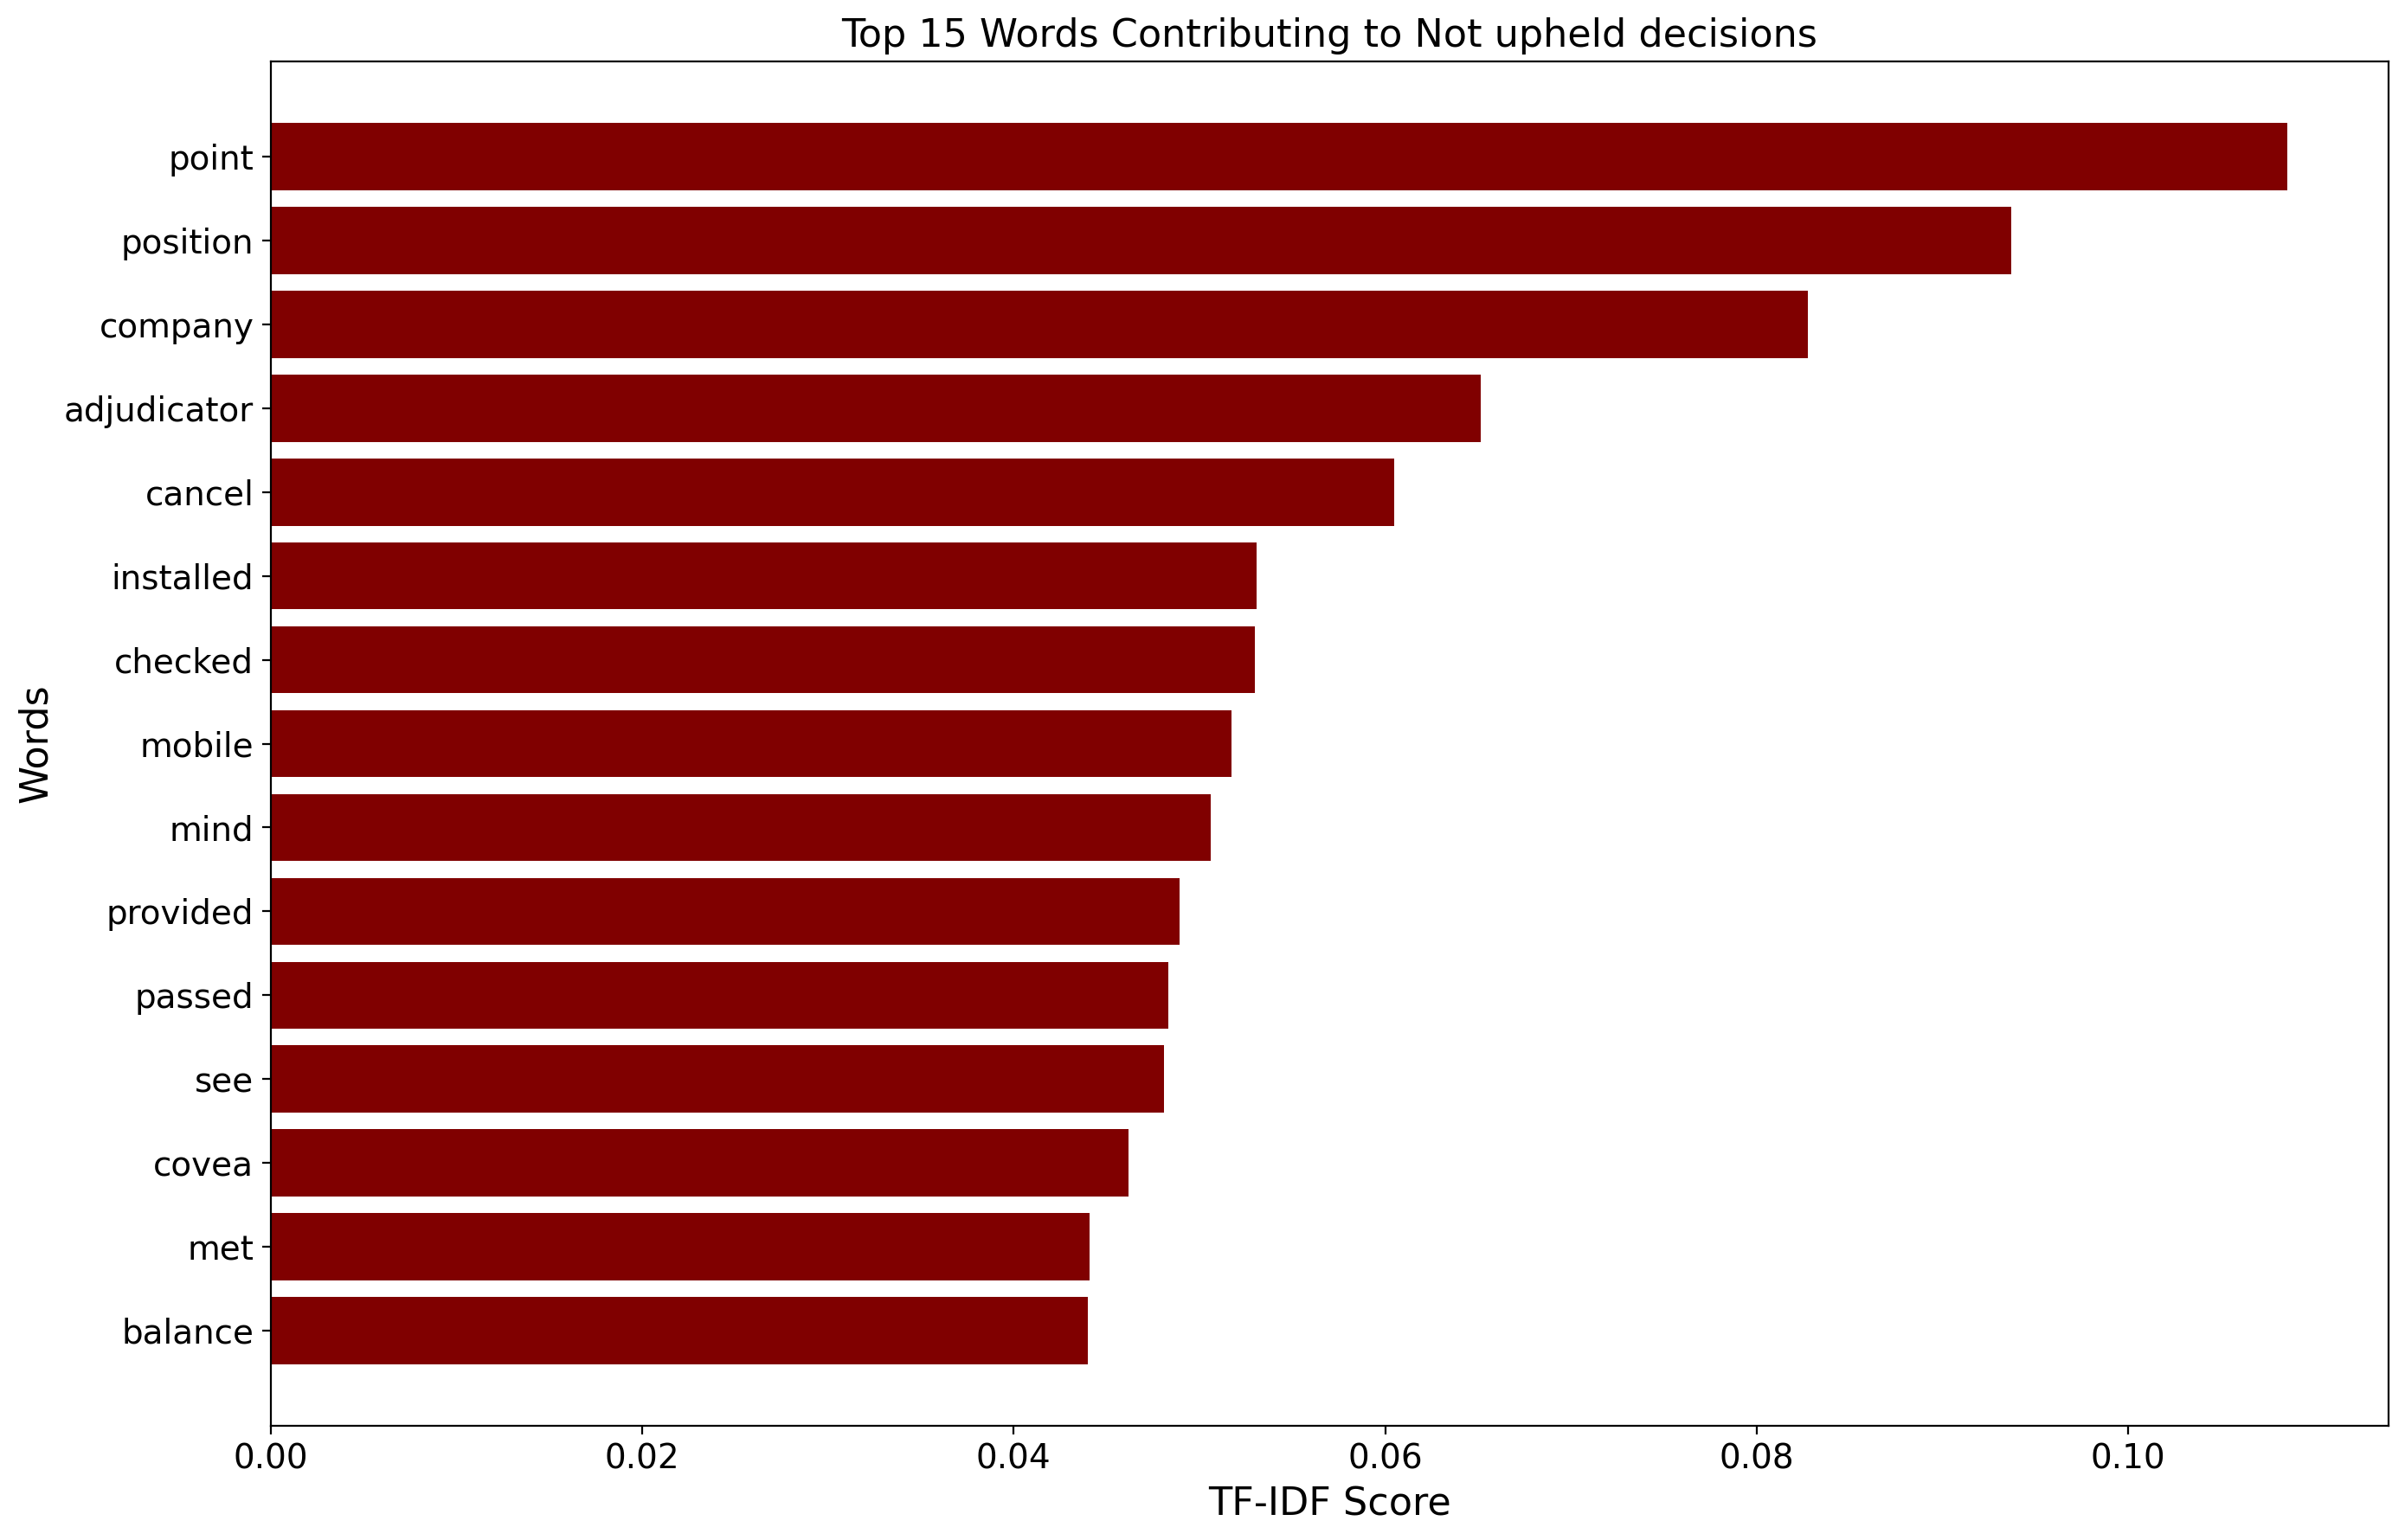

In [130]:
# Barplot for indicating the top 15 words which are more prominent in the Not upheld decisions..
# Corresponds to Figure 13 in the report.

import matplotlib.pyplot as plt



# Separate words and their corresponding scores
words, scores = zip(*top_15_not_upheld_words)

# Plotting
plt.figure(figsize=(14,9), dpi = 200)
plt.barh(words, scores, color='maroon')
plt.xlabel('TF-IDF Score',fontsize = 16)
plt.ylabel('Words',fontsize = 16)
plt.title('Top 15 Words Contributing to Not upheld decisions', fontsize = 16)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest scores at the top


plt.xticks(fontsize=14) # Setting the size of the X axis values.
plt.yticks(fontsize=14) # Setting the size of the Y axis values.
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

### ***SENTIMENT ANALYSIS***

In [131]:
from textblob import TextBlob

In [132]:
# Sentiment Analysis
new_df['sentiment'] = new_df['complaint_data'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [133]:
new_df[['sentiment']]

sentiment
0       -0.225000
1       -0.150000
2       -0.150000
3       -0.129499
4       -0.134286
...           ...
160792  -0.117450
160793   0.039107
160794  -0.136667
160795   0.034921
160796   0.031868

[160348 rows x 1 columns]

In [134]:
new_df.sentiment.value_counts()

sentiment
-0.300000    25833
-0.150000     4128
 0.000000     2341
-0.200000     2300
-0.242857     2226
             ...  
-0.022982        1
 0.084702        1
 0.017331        1
-0.135062        1
 0.173636        1
Name: count, Length: 58068, dtype: int64

In [135]:
new_df[new_df['sentiment']>0].shape , new_df[new_df['decision'] == 'Upheld'].shape

((38650, 18), (52482, 18))

In [136]:
new_df[new_df['sentiment']<0].shape , new_df[new_df['decision'] == 'Not upheld'].shape

((119357, 18), (107866, 18))

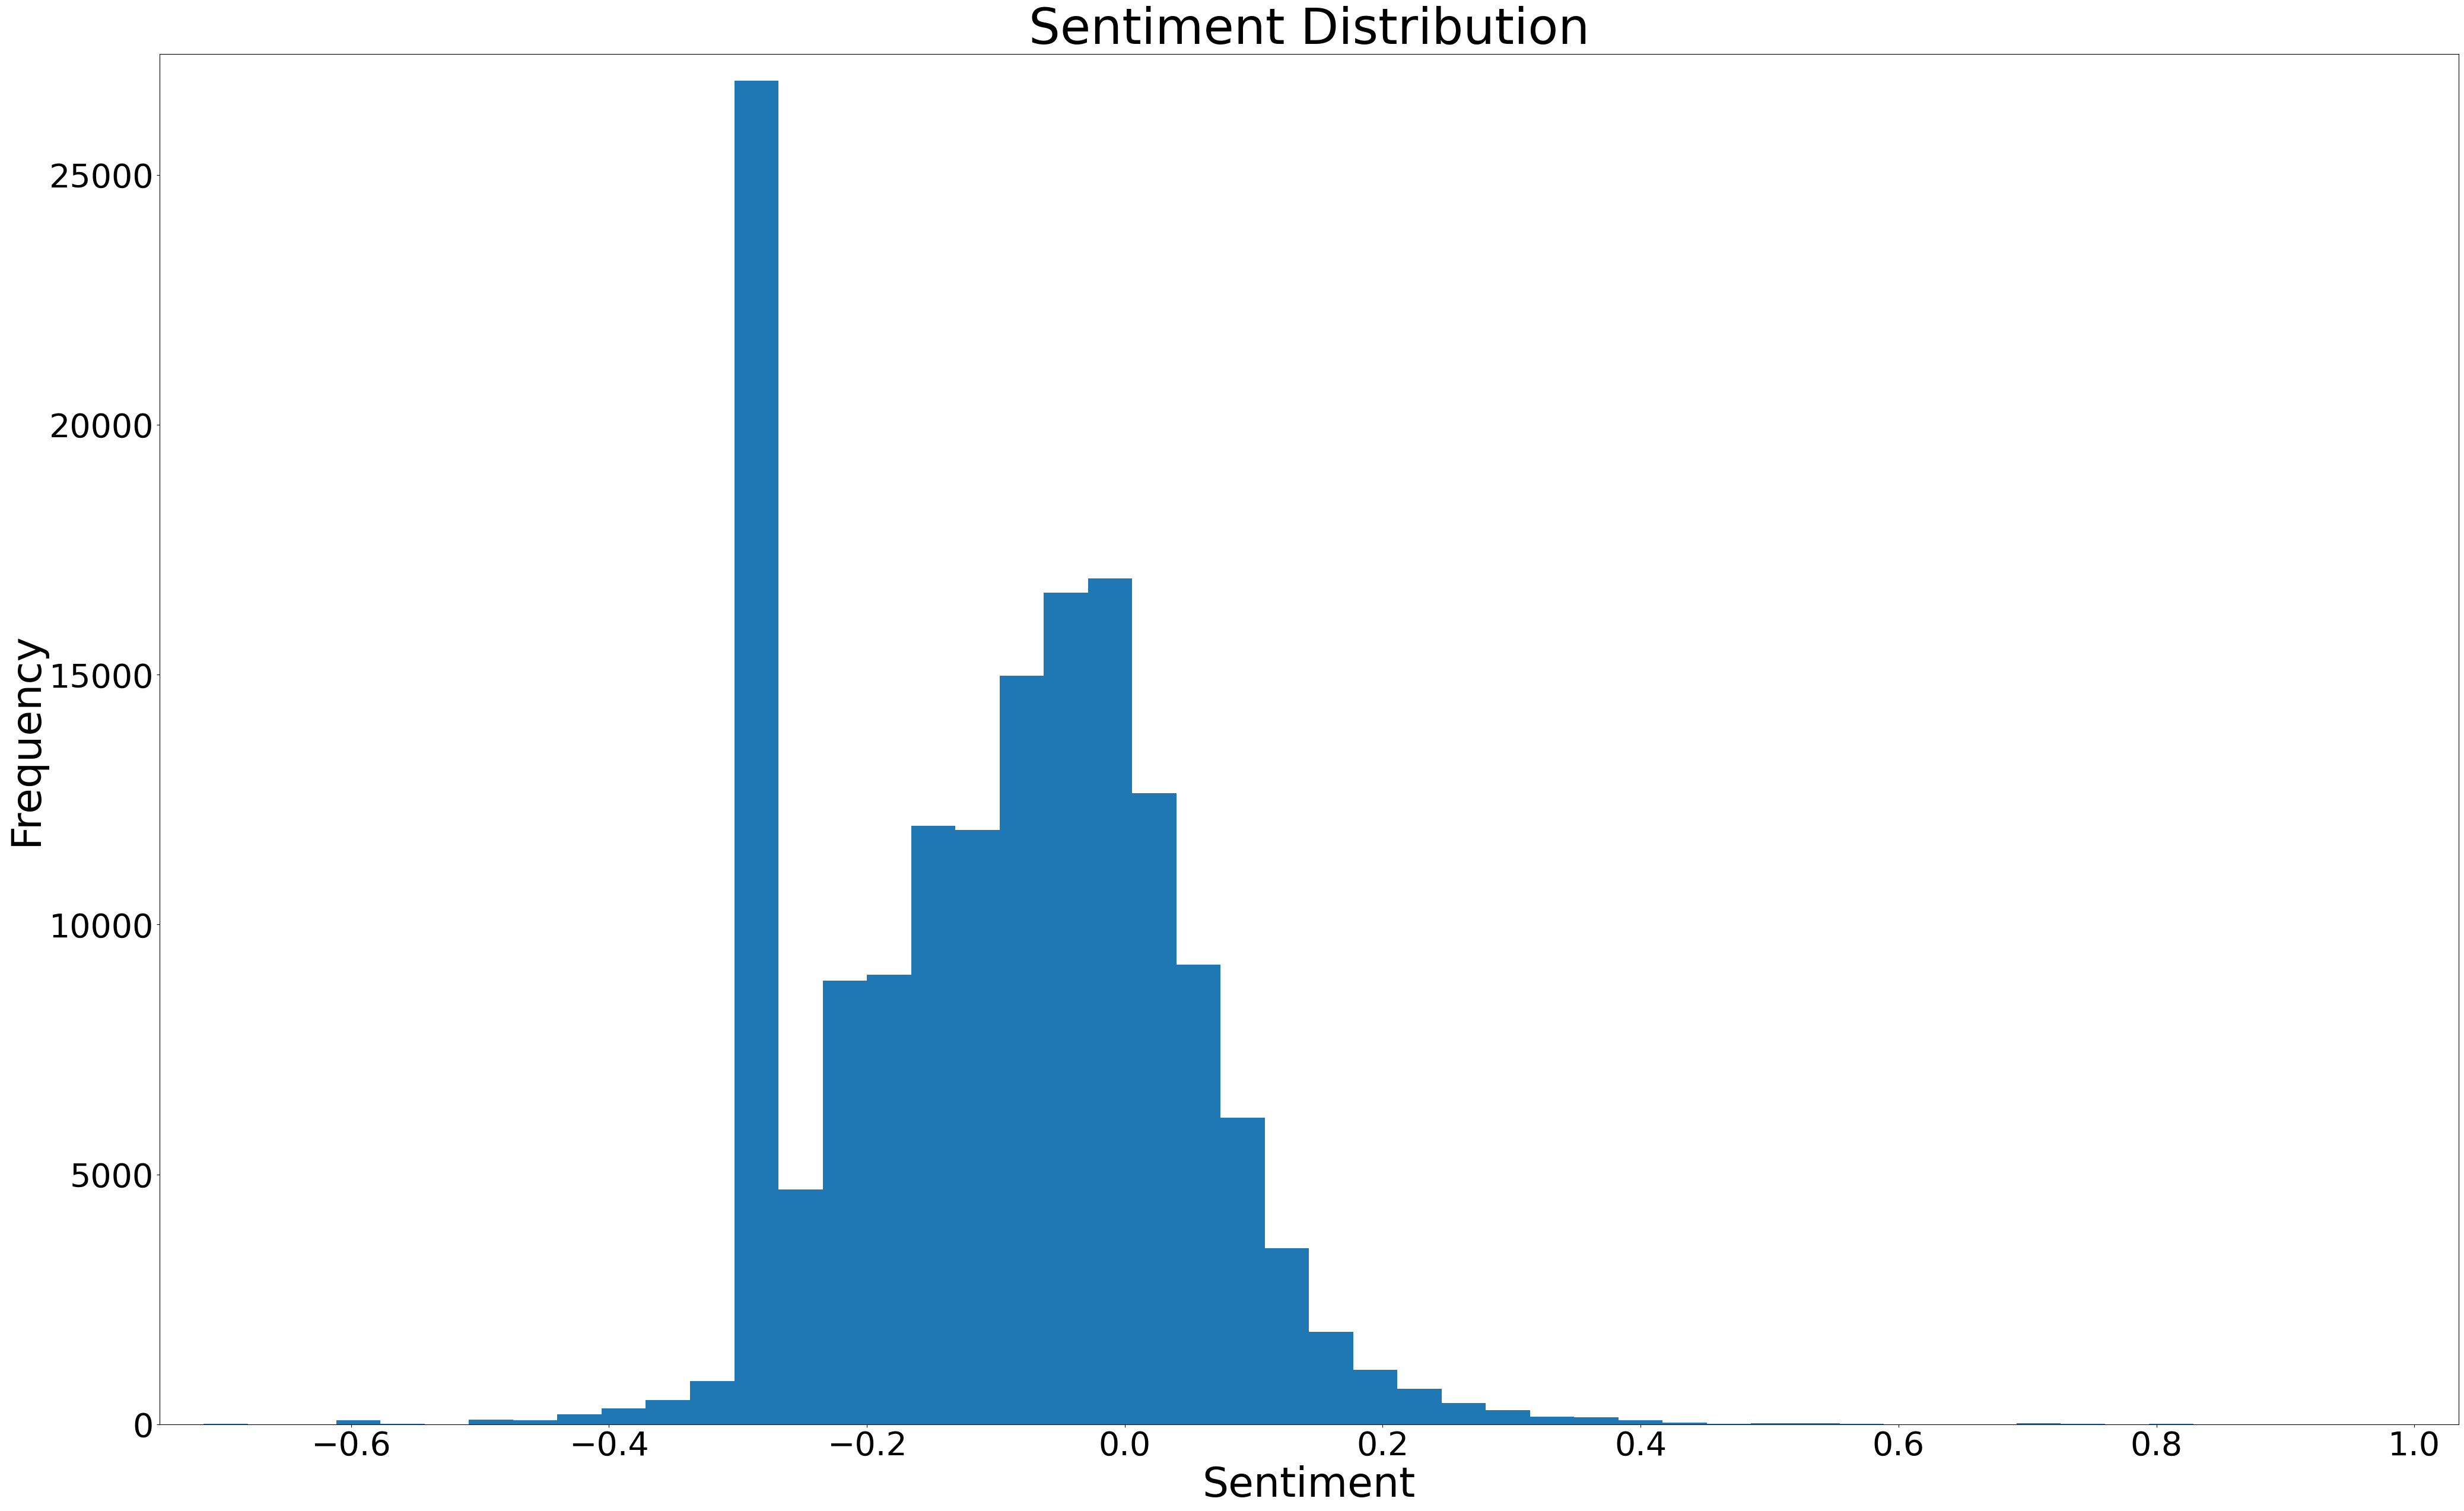

In [137]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.xlabel('Sentiment', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.hist(new_df['sentiment'], bins=50)
plt.title('Sentiment Distribution', fontsize=60)
plt.show()

## ***CATEGORY EVALUATION (TOPIC MODELLING) ----- LDA IMPLEMENTATION***

In [ ]:
# Since LDA model is a bit stochastic in nature, the plots do tend to alter since the number of topics change sometimes..
# Figures 14 and 15 are taken from this section after fitting the LDA model..

# The process of implementation is as follows :
# A dictionary is created with the corpus of data given , in our case it is the complaint data.
# Then a series of topics are generated within a range specified..
# For every number, a coherence score is calculated which is evaluated amongst other coherence scores computed
# The corresponding number with the best coherence score is taken out..
# The top 15 words are printed out on every topic , where on manually observing , we create a dictionary with appropriate label names..
# Create a column in the dataframe and assign the dominant topic's label name
# We therefore get the appropriate category after which we carry on further analysis.

In [141]:
# Prepare data for LDA
texts = new_df['complaint_data'].apply(lambda x: x.lower().split()).tolist()
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=1, no_above=0.85, keep_n=5000)

corpus = [dictionary.doc2bow(text) for text in texts]

# List of topic numbers to try
topic_nums = list(np.arange(7, 10, 1))

# Store coherence scores
coherence_scores = []

coherence_type = 'c_v'

In [142]:
for num in topic_nums:
    print(num)
    lda = LdaModel(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        alpha='auto',
        random_state=42
    )

    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=lda,
        texts=texts,
        dictionary=dictionary,
        coherence=coherence_type
    )

    coherence_score = round(cm.get_coherence(), 5)
    coherence_scores.append((num, coherence_score))
    print(f"Coherence Score for {num} topics: {coherence_score}")


7
Coherence Score for 7 topics: 0.48127
8
Coherence Score for 8 topics: 0.45786
9
Coherence Score for 9 topics: 0.4253


In [143]:
# Display the coherence scores
print("Coherence Scores for different numbers of topics:")
for num, score in coherence_scores:
    print(f"{num} topics: {score}")

# Find the best number of topics based on the highest coherence score
optim_num_topics = sorted(coherence_scores, key=lambda x: x[1], reverse=True)[0][0]

print(f"Best number of topics: {optim_num_topics}")

Coherence Scores for different numbers of topics:
7 topics: 0.48127
8 topics: 0.45786
9 topics: 0.4253
Best number of topics: 7


In [144]:
# Fit LDA model with the optimal topics which had the best coherence score..
lda_model = LdaModel(
    corpus=corpus,
    num_topics=optim_num_topics,
    id2word=dictionary,
    chunksize=2000,
    passes=5,
    alpha='auto',
    random_state=42
)

In [145]:
# Display the topics
for i, topic in lda_model.show_topics(formatted=False, num_words=15):
    print(f"Topic {i}: {[word for word, _ in topic]}")

Topic 0: ['premium', 'cover', 'said', 'time', 'told', 'would', 'information', 'value', 'pay', 'renewal', 'representative', 'u', 'say', 'circumstance', 'limitation']
Topic 1: ['ppi', 'mortgage', 'missold', 'protection', 'adjudicator', 'payment', 'loan', 'say', 'cover', 'passed', 'took', 'plc', 'disagreed', 'sold', 'cg']
Topic 2: ['p', 'claim', 'work', 'time', 'would', 'month', 'successful', 'cover', 'allianz', 'ppi', 'cost', 'accident', 'good', 'balance', 'provided']
Topic 3: ['h', 'f', 'e', 'decision', 'store', 'limited', 'refer', 'seller', 'miss', 'responsibility', 'company', 'financial', 'insurer', 'thing', 'opinion']
Topic 4: ['lloyd', 'ppi', 'card', 'credit', 'payment', 'adjudicator', 'west', 'bank', 'say', 'missold', 'protection', 'taken', 'plc', 'opinion', 'disagreed']
Topic 5: ['claim', 'said', 'axa', 'investigator', 'cover', 'made', 'm', 'would', 'b', 'condition', 'miss', 'decision', 'c', 'also', 'declined']
Topic 6: ['claim', 'said', 'car', 'damage', 'investigator', 'repair', 

In [146]:
'''
# Map topics to labels
topic_labels = {
    0: 'Legal / Business Insurance',
    1: 'Mortgage PPI',
    2: 'Loan repayment PPI',
    3: 'Medical Insurance',
    4: 'Others',
    5: 'Home Insurance',
    6: 'Vehicle Insurance',
    7: 'Credit Card PPI'
}

'''


topic_labels = {
    0: 'Legal / Business Insurance',
    1: 'Mortgage PPI',
    2: 'Loan repayment PPI',
    3: 'Medical Insurance',
    4: 'Credit Card PPI',
    5: 'Home Insurance',
    6: 'Vehicle Insurance'
}

In [147]:
# Assign the dominant topic to each document
topics = lda_model[corpus]
dominant_topics = [max(t, key=lambda x: x[1])[0] for t in topics]

new_df['Topic_Cluster'] = dominant_topics

In [148]:
# Create a new column in the DataFrame with the corresponding topic labels
new_df['complaint_category'] = new_df['Topic_Cluster'].map(topic_labels)

In [150]:
new_df.complaint_category.value_counts()

complaint_category
Mortgage PPI                  45041
Vehicle Insurance             43892
Credit Card PPI               28400
Home Insurance                26086
Legal / Business Insurance    10911
Loan repayment PPI             3460
Medical Insurance              2558
Name: count, dtype: int64

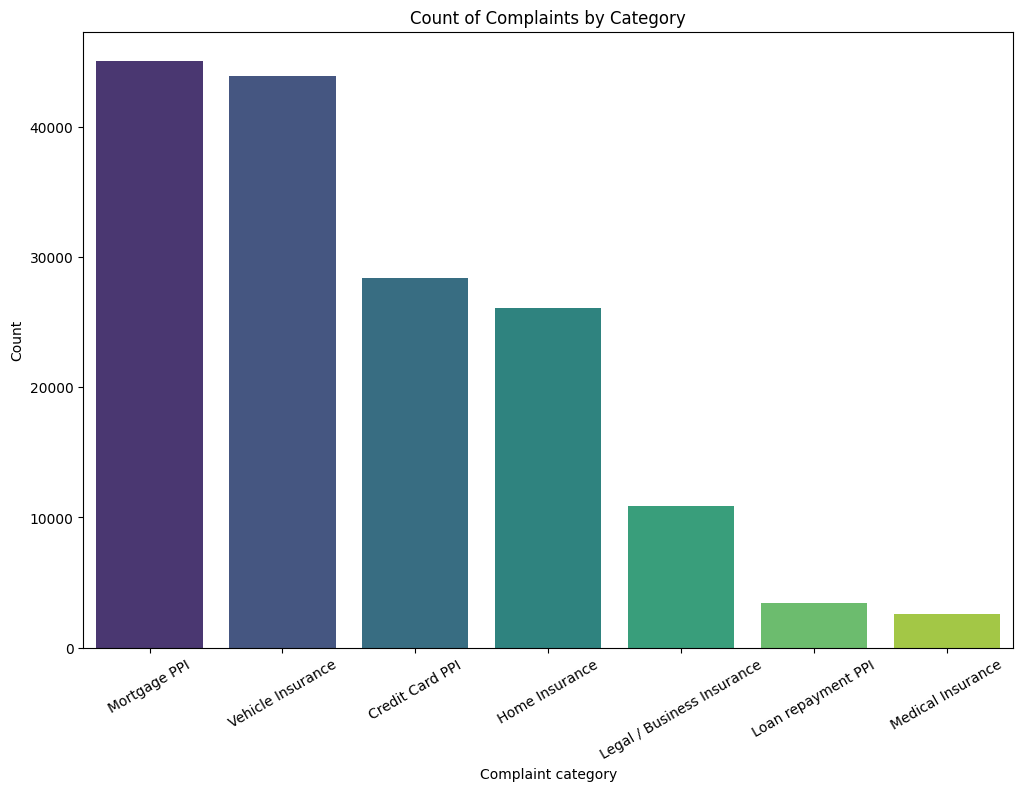

In [151]:
# Countplot using Seaborn
plt.figure(figsize=(12,8))
sns.countplot(data=new_df, x='complaint_category', order=new_df['complaint_category'].value_counts().index,palette='viridis')
plt.title('Count of Complaints by Category')
plt.xlabel('Complaint category')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

In [152]:
upheld_df = new_df[new_df['decision'] == 'Upheld']
not_upheld_df = new_df[new_df['decision'] == 'Not upheld']

In [154]:
upheld_df.shape , not_upheld_df.shape

((52482, 20), (107866, 20))

In [153]:
# Calculate the total number of claims per category present
total_claims_per_category = new_df.groupby('complaint_category').size()

# Calculate the number of upheld claims per category
upheld_claims_per_category = upheld_df.groupby('complaint_category').size()


# Calculate the ratio of upheld claims to total claims per year
upheld_ratio = (upheld_claims_per_category / total_claims_per_category).reset_index()
upheld_ratio.columns = ['category', 'ratio']
upheld_ratio = upheld_ratio.fillna(0)  # Fill NaN values with 0 if there are years with no upheld claims


In [155]:
new_df[(new_df['complaint_category'] == 'Home Insurance') & (new_df['decision'] == 'Upheld')].shape

(8638, 20)

In [156]:
upheld_claims_per_category , total_claims_per_category

(complaint_category
 Credit Card PPI               10902
 Home Insurance                 8638
 Legal / Business Insurance     2306
 Loan repayment PPI             1051
 Medical Insurance               563
 Mortgage PPI                  11745
 Vehicle Insurance             17277
 dtype: int64,
 complaint_category
 Credit Card PPI               28400
 Home Insurance                26086
 Legal / Business Insurance    10911
 Loan repayment PPI             3460
 Medical Insurance              2558
 Mortgage PPI                  45041
 Vehicle Insurance             43892
 dtype: int64)

In [157]:
upheld_ratio

category     ratio
0             Credit Card PPI  0.383873
1              Home Insurance  0.331135
2  Legal / Business Insurance  0.211346
3          Loan repayment PPI  0.303757
4           Medical Insurance  0.220094
5                Mortgage PPI  0.260762
6           Vehicle Insurance  0.393625

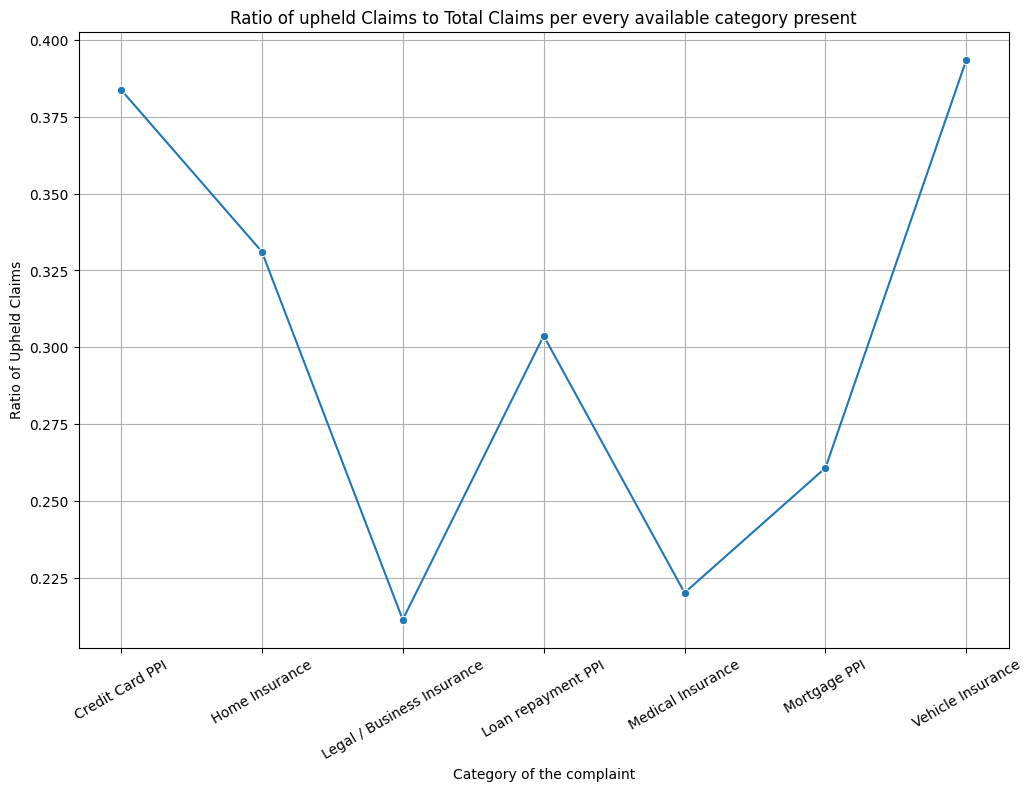

In [158]:
# Plot the ratio across years
plt.figure(figsize=(12, 8))
sns.lineplot(data=upheld_ratio, x='category', y='ratio', marker='o')
plt.title('Ratio of upheld Claims to Total Claims per every available category present')
plt.xlabel('Category of the complaint')
plt.ylabel('Ratio of Upheld Claims')
plt.xticks(upheld_ratio['category'], rotation = 30)
plt.grid(True)
plt.show()

In [159]:

# Calculate the total number of claims per category present
total_claims_per_category = new_df.groupby('complaint_category').size()

# Calculate the number of upheld claims per category
not_upheld_claims_per_category = not_upheld_df.groupby('complaint_category').size()


# Calculate the ratio of upheld claims to total claims per year
not_upheld_ratio = (not_upheld_claims_per_category / total_claims_per_category).reset_index()
not_upheld_ratio.columns = ['category', 'ratio']
not_upheld_ratio = not_upheld_ratio.fillna(0)  # Fill NaN values with 0 if there are years with no upheld claims



In [160]:
not_upheld_claims_per_category

complaint_category
Credit Card PPI               17498
Home Insurance                17448
Legal / Business Insurance     8605
Loan repayment PPI             2409
Medical Insurance              1995
Mortgage PPI                  33296
Vehicle Insurance             26615
dtype: int64

In [161]:
not_upheld_ratio

category     ratio
0             Credit Card PPI  0.616127
1              Home Insurance  0.668865
2  Legal / Business Insurance  0.788654
3          Loan repayment PPI  0.696243
4           Medical Insurance  0.779906
5                Mortgage PPI  0.739238
6           Vehicle Insurance  0.606375

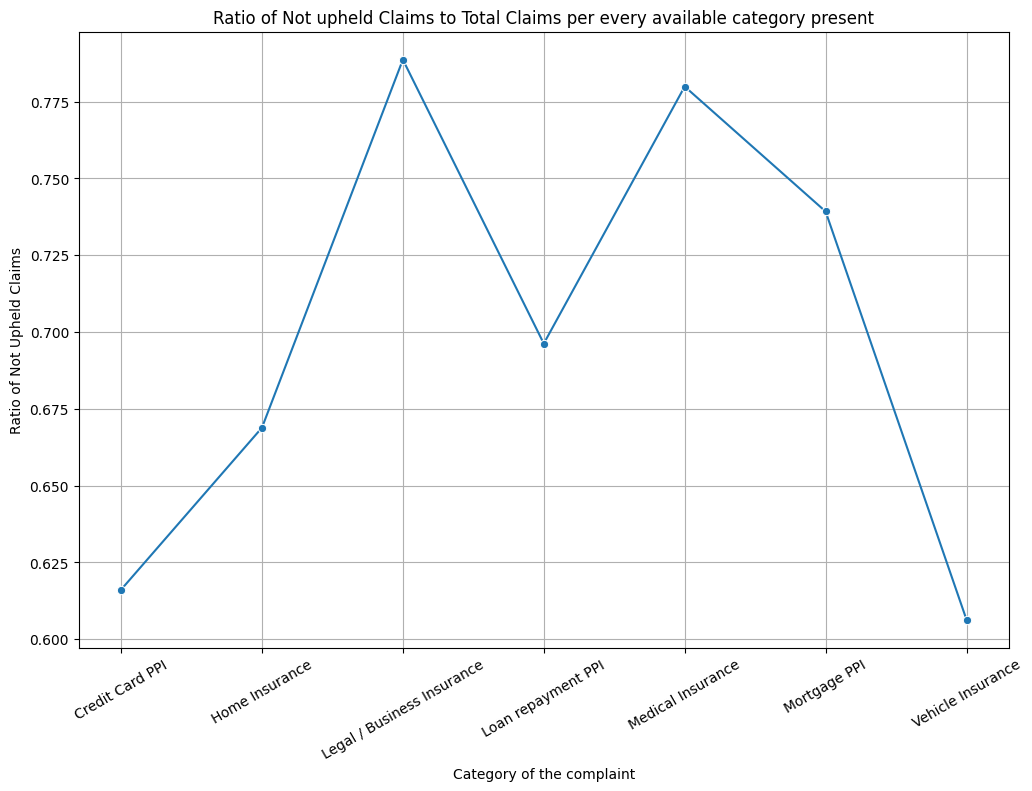

In [162]:
# Plot the ratio across years
plt.figure(figsize=(12, 8))
sns.lineplot(data=not_upheld_ratio, x='category', y='ratio', marker='o')
plt.title('Ratio of Not upheld Claims to Total Claims per every available category present')
plt.xlabel('Category of the complaint')
plt.ylabel('Ratio of Not Upheld Claims')
plt.xticks(not_upheld_ratio['category'], rotation = 30)
plt.grid(True)
plt.show()

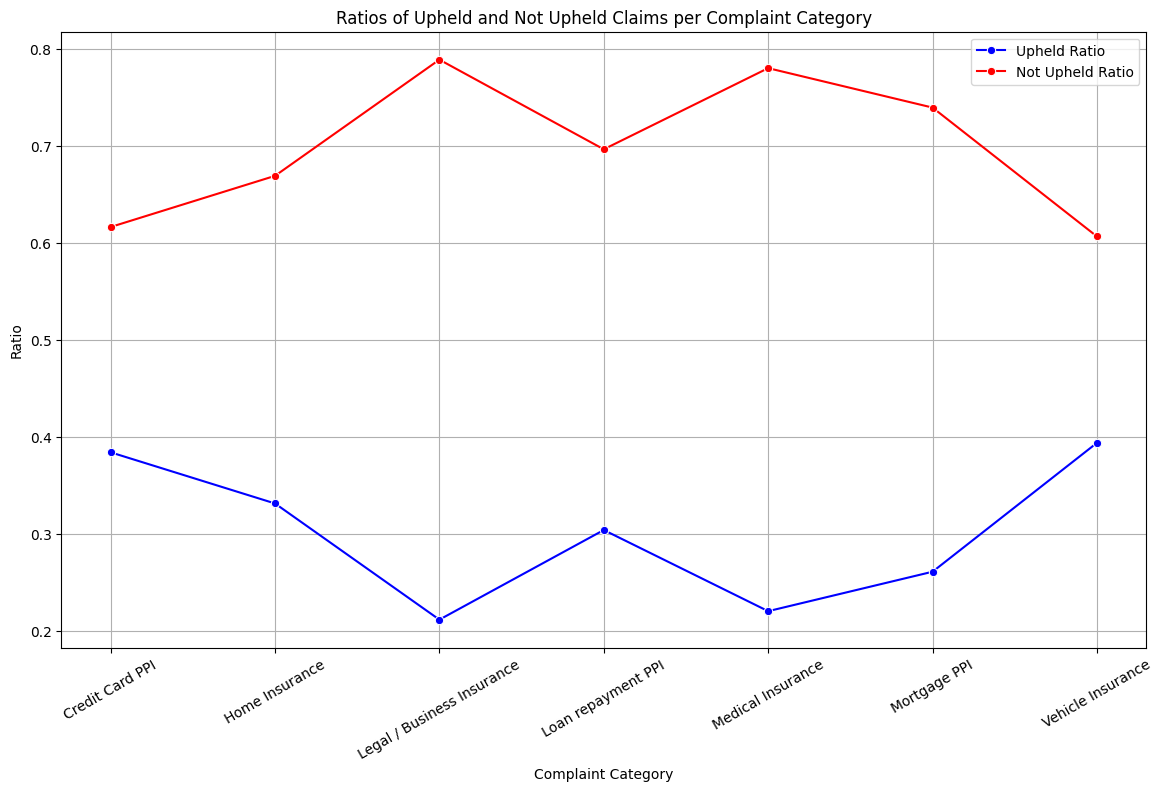

In [163]:
# Plot the ratios
plt.figure(figsize=(14, 8))

sns.lineplot(data=upheld_ratio, x='category', y='ratio', marker='o', label='Upheld Ratio', color='b')
sns.lineplot(data=not_upheld_ratio, x='category', y='ratio', marker='o', label='Not Upheld Ratio', color='r')

plt.title('Ratios of Upheld and Not Upheld Claims per Complaint Category')
plt.xlabel('Complaint Category')
plt.ylabel('Ratio')
plt.xticks(rotation=30)
plt.legend()
plt.grid(True)
plt.show()

## ***INSIGHTS ON THE OMBUDSMAN DECISION MAKING***

In [164]:
# We will be taking the ombudsman decisions into consideration (extracted third and fourth sections are into consideration)...

In [165]:
new_df.columns

Index(['decision_id', 'location', 'title', 'date', 'company', 'decision',
       'tag', 'Complaint_Info', 'Complaint_Explanation',
       'Decision_Taken_And_Reason', 'Final_Decision', 'provisional_decision',
       'complaint_data', 'year', 'month', 'day', 'word_length_complaint',
       'sentiment', 'Topic_Cluster', 'complaint_category'],
      dtype='object')

In [166]:
new_df.isnull().sum()

decision_id                  0
location                     0
title                        0
date                         0
company                      0
decision                     0
tag                          0
Complaint_Info               0
Complaint_Explanation        0
Decision_Taken_And_Reason    0
Final_Decision               0
provisional_decision         0
complaint_data               0
year                         0
month                        0
day                          0
word_length_complaint        0
sentiment                    0
Topic_Cluster                0
complaint_category           0
dtype: int64

In [167]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt, seaborn as sb

In [168]:
def generate_word_cloud(corpus_data: str, cmap: str, title: str):

    wordcloud = WordCloud(background_color = 'black', width = 800, height = 400,
                          colormap = cmap, max_words = 156, contour_width = 3,
                          max_font_size = 80, contour_color = 'blue',
                          random_state = 0)

    wordcloud.generate(corpus_data)

    plt.figure(figsize=(12,8))
    plt.title(f'Word Cloud for {title}', fontsize=10)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figure()

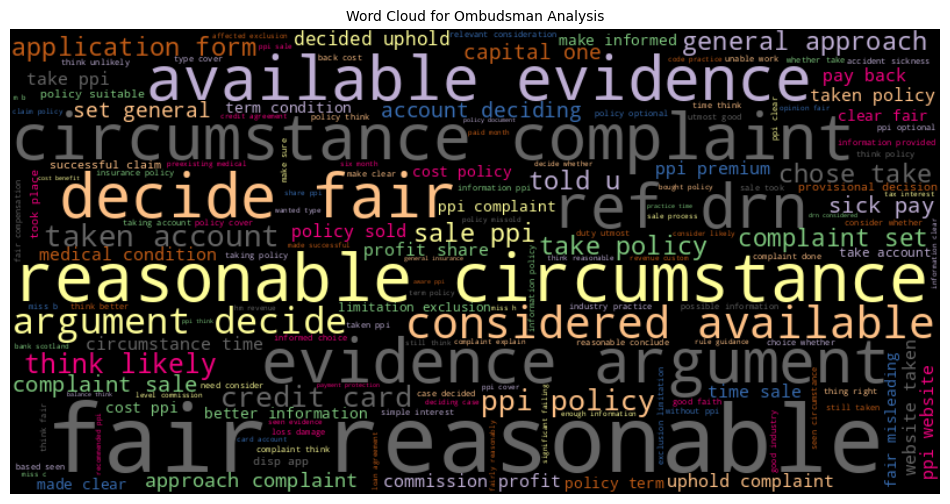

<Figure size 640x480 with 0 Axes>

In [169]:
## Corresponds to Figure 16 in the report..
# Wordcloud generated for rthe ombudsman findings (Section 3 from the decision file).

text = ' '.join(new_df['Decision_Taken_And_Reason'].dropna().values)
generate_word_cloud(text, cmap = 'Accent', title = 'Ombudsman Analysis')

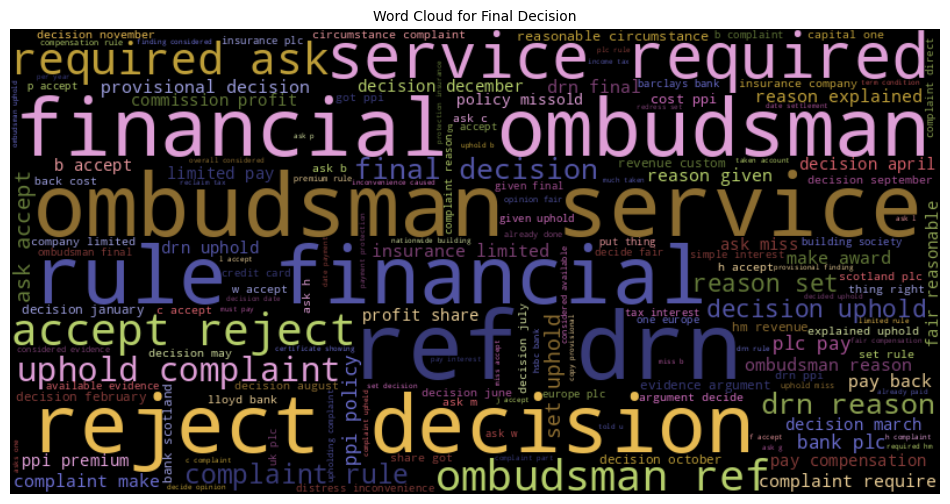

<Figure size 640x480 with 0 Axes>

In [170]:
## wordcoloud for the final decision undertaken by the ombudsman.

text = ' '.join(new_df['Final_Decision'].dropna().values)
generate_word_cloud(text, cmap = 'tab20b', title = 'Final Decision')

In [171]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_ngrams(corpus, n=2, num_ngrams=10):
    vectorizer = CountVectorizer(ngram_range=(n, n))
    ngrams = vectorizer.fit_transform(corpus)
    ngrams_freq = ngrams.sum(axis=0).A1
    ngrams_freq = sorted([(freq, ngram) for ngram, freq in zip(vectorizer.get_feature_names_out(), ngrams_freq)], reverse=True)
    return ngrams_freq[:num_ngrams]

In [172]:
bigrams = get_top_n_ngrams(new_df['Decision_Taken_And_Reason'].dropna().values, n=2)
trigrams = get_top_n_ngrams(new_df['Decision_Taken_And_Reason'].dropna().values, n=3)

print("Top Bigrams:", bigrams)

Top Bigrams: [(244852, 'fair reasonable'), (187794, 'reasonable circumstance'), (178678, 'circumstance complaint'), (163632, 'evidence argument'), (161698, 'available evidence'), (154532, 'ref drn'), (153585, 'decide fair'), (147897, 'considered available'), (147410, 'argument decide'), (93594, 'taken account')]


In [173]:
print("Top Trigrams:", trigrams)

Top Trigrams: [(185974, 'fair reasonable circumstance'), (167840, 'reasonable circumstance complaint'), (153341, 'decide fair reasonable'), (151501, 'available evidence argument'), (147519, 'considered available evidence'), (147395, 'evidence argument decide'), (147325, 'argument decide fair'), (55370, 'set general approach'), (52289, 'general approach complaint'), (52139, 'approach complaint sale')]


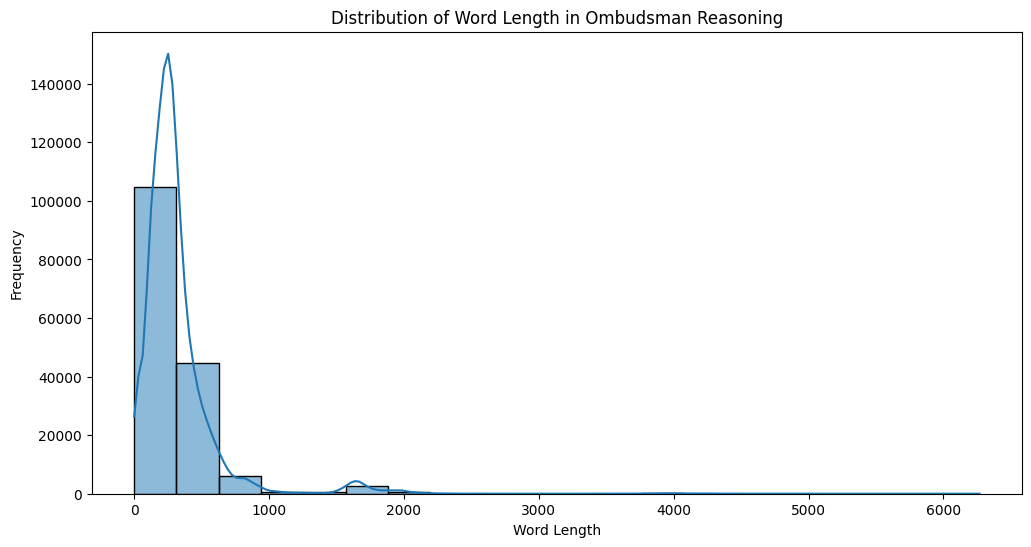

In [174]:
new_df['word_length'] = new_df['Decision_Taken_And_Reason'].apply(lambda x: len(str(x).split()))

# Distribution of word lengths
plt.figure(figsize=(12, 6))
sns.histplot(new_df['word_length'], bins=20, kde=True)
plt.title('Distribution of Word Length in Ombudsman Reasoning')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()

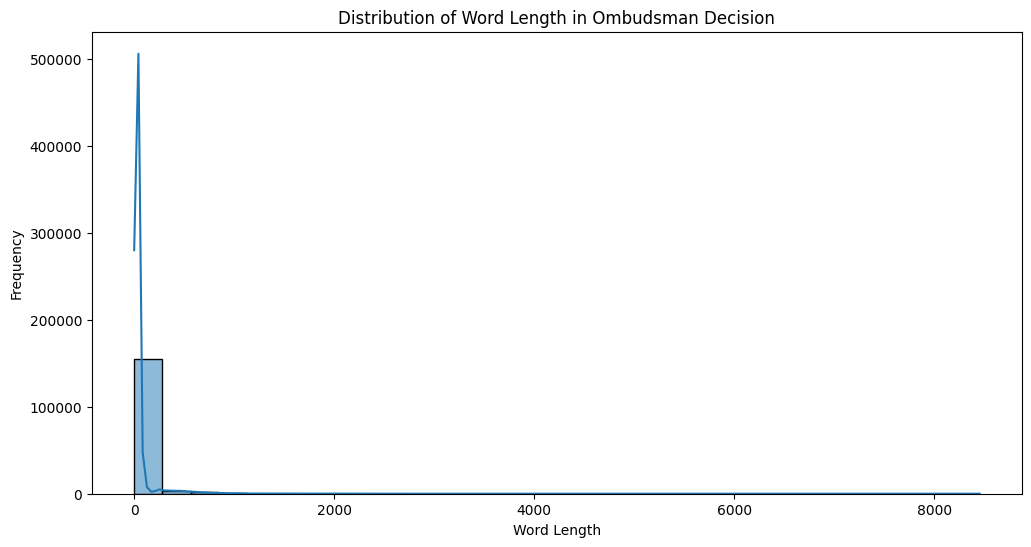

In [175]:
new_df['word_length_final_decision'] = new_df['Final_Decision'].apply(lambda x: len(str(x).split()))

# Distribution of word lengths
plt.figure(figsize=(12, 6))
sns.histplot(new_df['word_length_final_decision'], bins=30, kde=True)
plt.title('Distribution of Word Length in Ombudsman Decision')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()

In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Compute TF-IDF scores for each category
vectorizer = TfidfVectorizer(max_features=1000)

omb_matrix = vectorizer.fit_transform(new_df['Decision_Taken_And_Reason'])


In [177]:
# Extract the TF-IDF feature names
feature_names = vectorizer.get_feature_names_out()

# Compute mean TF-IDF scores for each decision category
omb_matrix_mean = omb_matrix.mean(axis=0).A1

In [178]:
# Get the top 10 words for each category
top_15_omb_indices = omb_matrix_mean.argsort()[-15:][::-1]
top_15_omb_words = [(feature_names[i], omb_matrix_mean[i]) for i in top_15_omb_indices]

print("Top 15 words used in Ombudsman analysis:\n")
for word, score in top_15_omb_words:
    print(f"{word}: {score}")

Top 15 words used in Ombudsman analysis:

ppi: 0.11695638372009846
policy: 0.11018581286878863
think: 0.07621278194684353
would: 0.07564239181409298
miss: 0.05247055995186824
complaint: 0.05047183157096006
claim: 0.04638847388870175
information: 0.0432399087361275
cover: 0.041367713727408
take: 0.038446563165215684
say: 0.03669955427731697
time: 0.03572159423438065
sale: 0.03520119948776654
circumstance: 0.034708151199009024
evidence: 0.034255561166470626


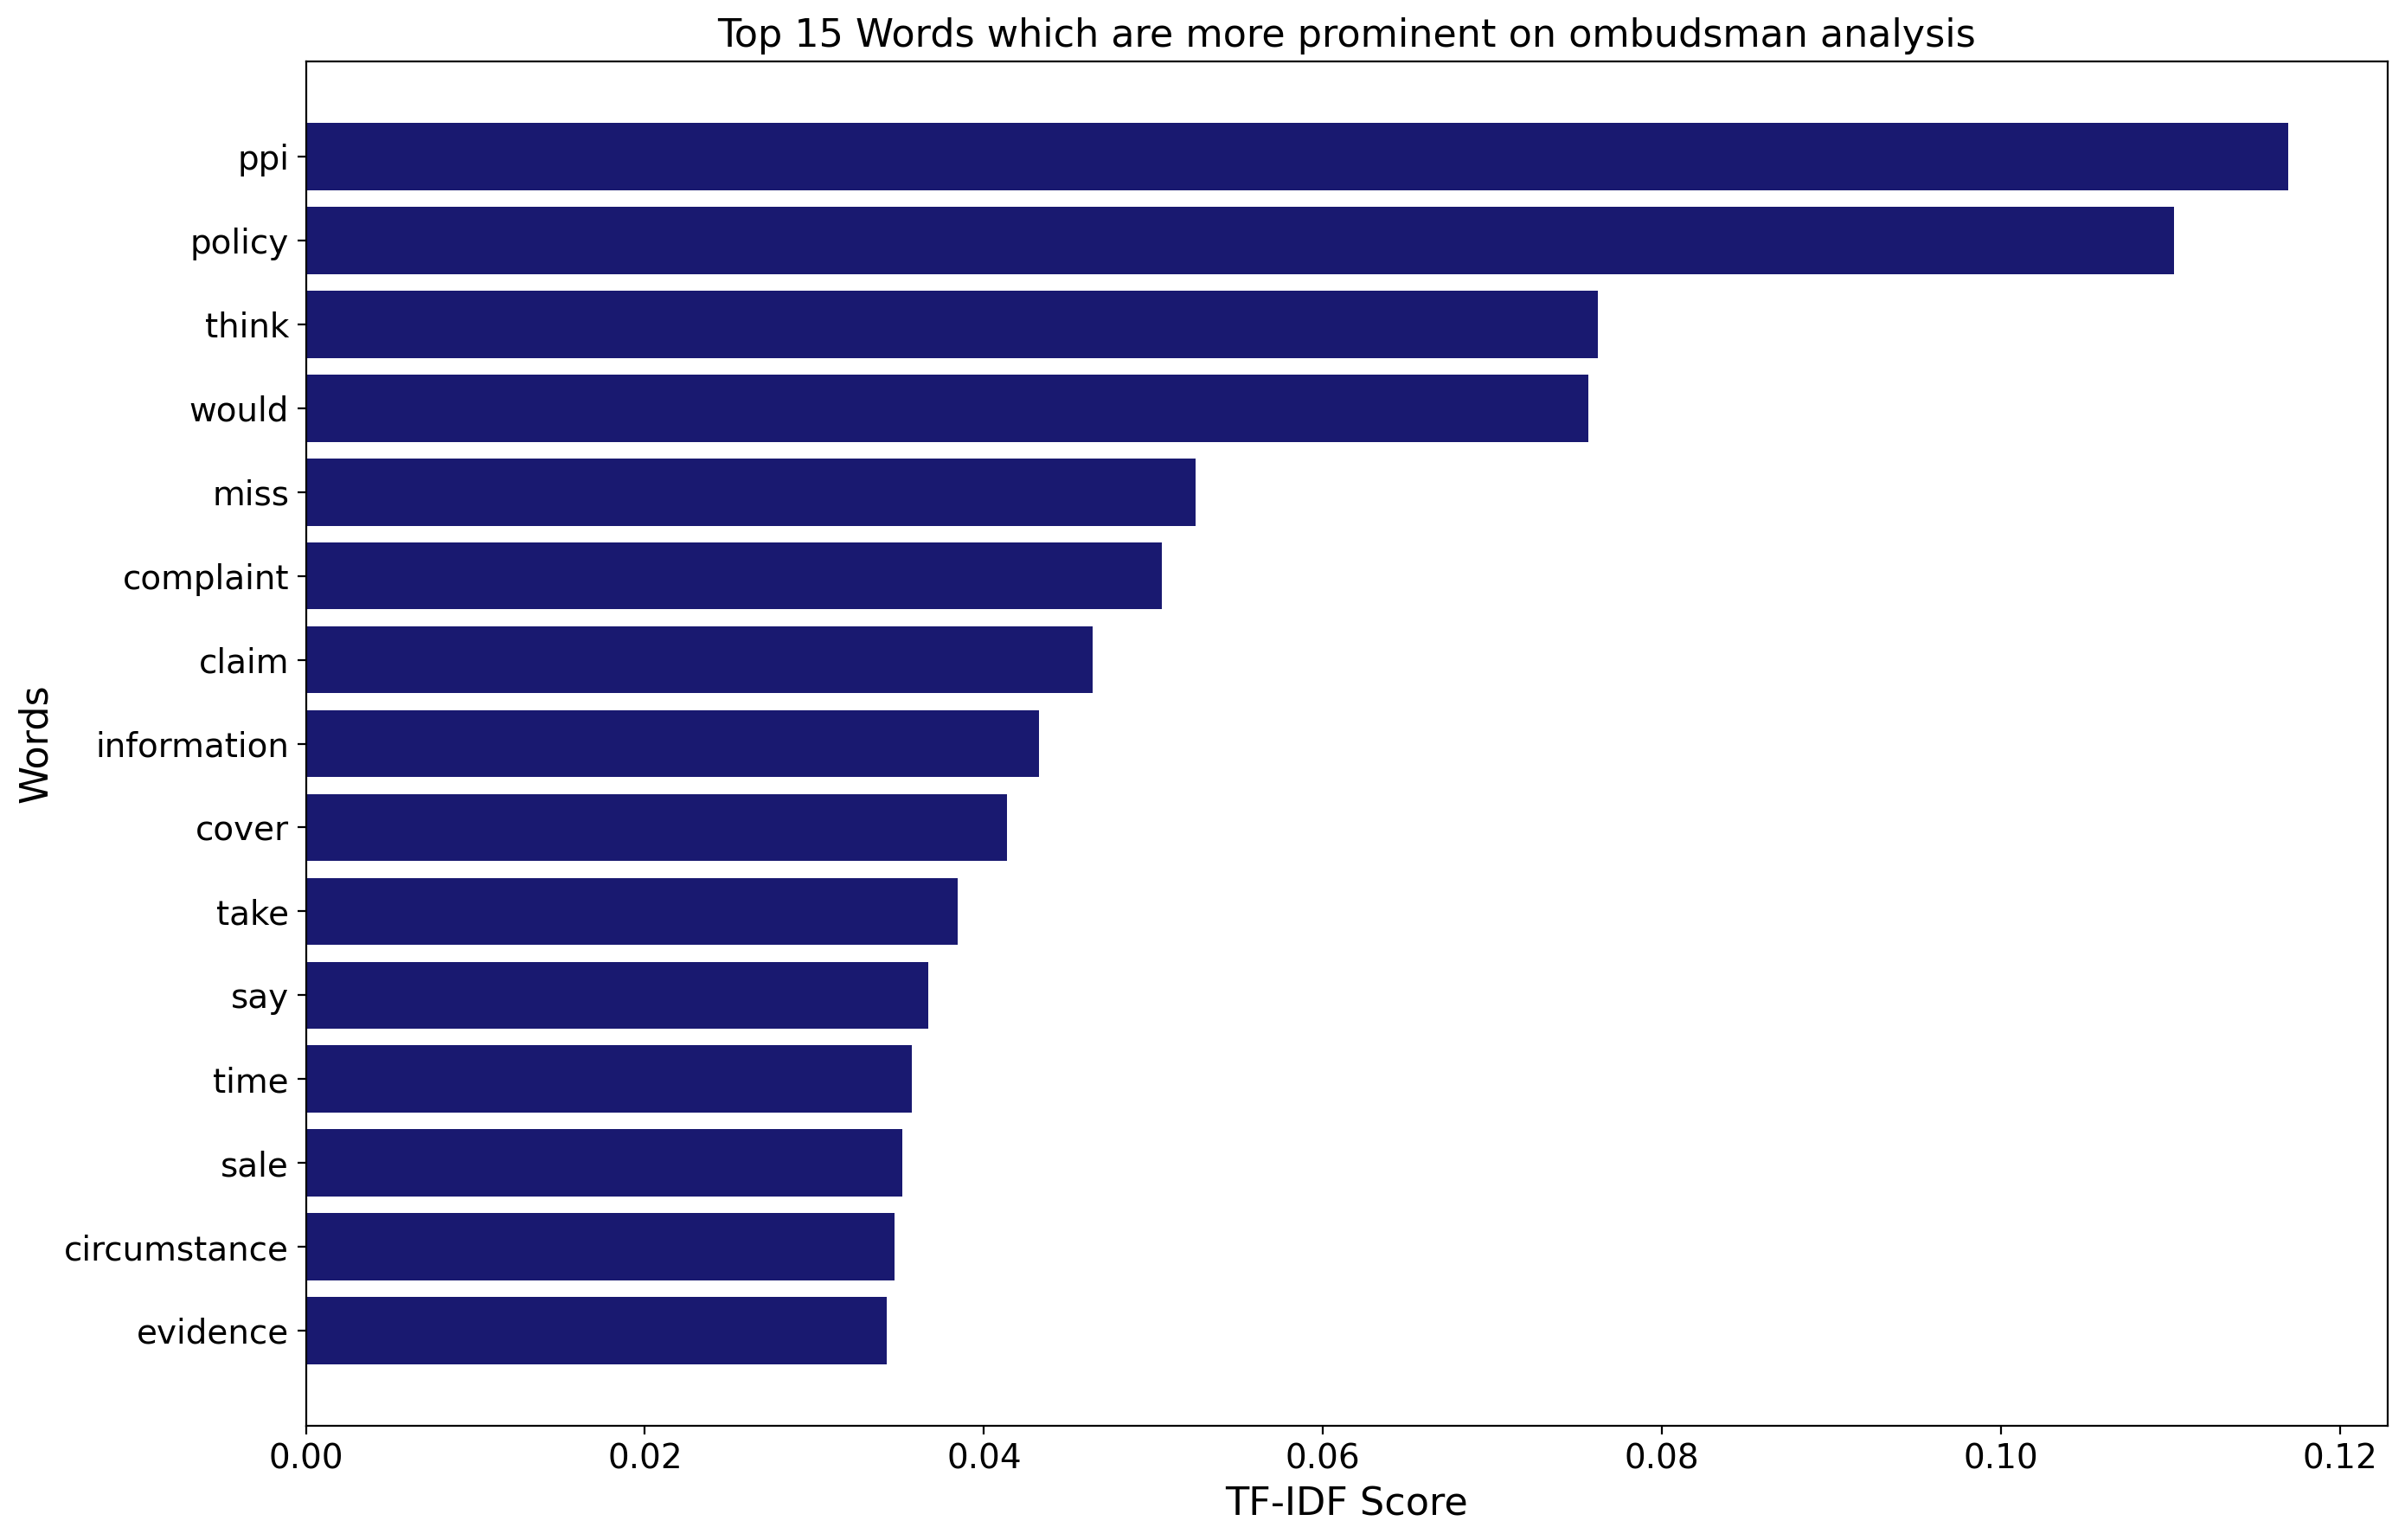

In [179]:
# Bar plot indicating top 15 words which are more frequent in ombudsman findings..


# Separate words and their corresponding scores
words, scores = zip(*top_15_omb_words)

# Plotting
plt.figure(figsize=(14,9), dpi = 200)
plt.barh(words, scores, color='midnightblue')
plt.xlabel('TF-IDF Score',fontsize = 16)
plt.ylabel('Words',fontsize = 16)
plt.title('Top 15 Words which are more prominent on ombudsman analysis', fontsize = 16)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest scores at the top


plt.xticks(fontsize=14) # Setting the size of the X axis values.
plt.yticks(fontsize=14) # Setting the size of the Y axis values.
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [180]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Compute TF-IDF scores for each category
vectorizer = TfidfVectorizer(max_features=1000)

omb_final_mat = vectorizer.fit_transform(new_df['Final_Decision'])


In [181]:
# Extract the TF-IDF feature names
feature_names = vectorizer.get_feature_names_out()

# Compute mean TF-IDF scores for each decision category
omb_final_mat_mean = omb_final_mat.mean(axis=0).A1

In [182]:
# Get the top 10 words for each category
top_15_omb_final_indices = omb_final_mat_mean.argsort()[-15:][::-1]
top_15_omb_final_words = [(feature_names[i], omb_final_mat_mean[i]) for i in top_15_omb_final_indices]

print("Top 15 words used in Ombudsman analysis:\n")
for word, score in top_15_omb_final_words:
    print(f"{word}: {score}")

Top 15 words used in Ombudsman analysis:

ombudsman: 0.14978779585187318
decision: 0.10779587782677556
complaint: 0.08997040362129052
uphold: 0.08510224001820123
ref: 0.08465203090573642
drn: 0.0846492982185317
service: 0.08080486805230444
financial: 0.08040024650608517
required: 0.07979044558272794
ask: 0.07947357828872245
accept: 0.07945808612780098
reject: 0.07926238651270096
rule: 0.07912126481954969
reason: 0.07745050690885583
set: 0.06677733316100506


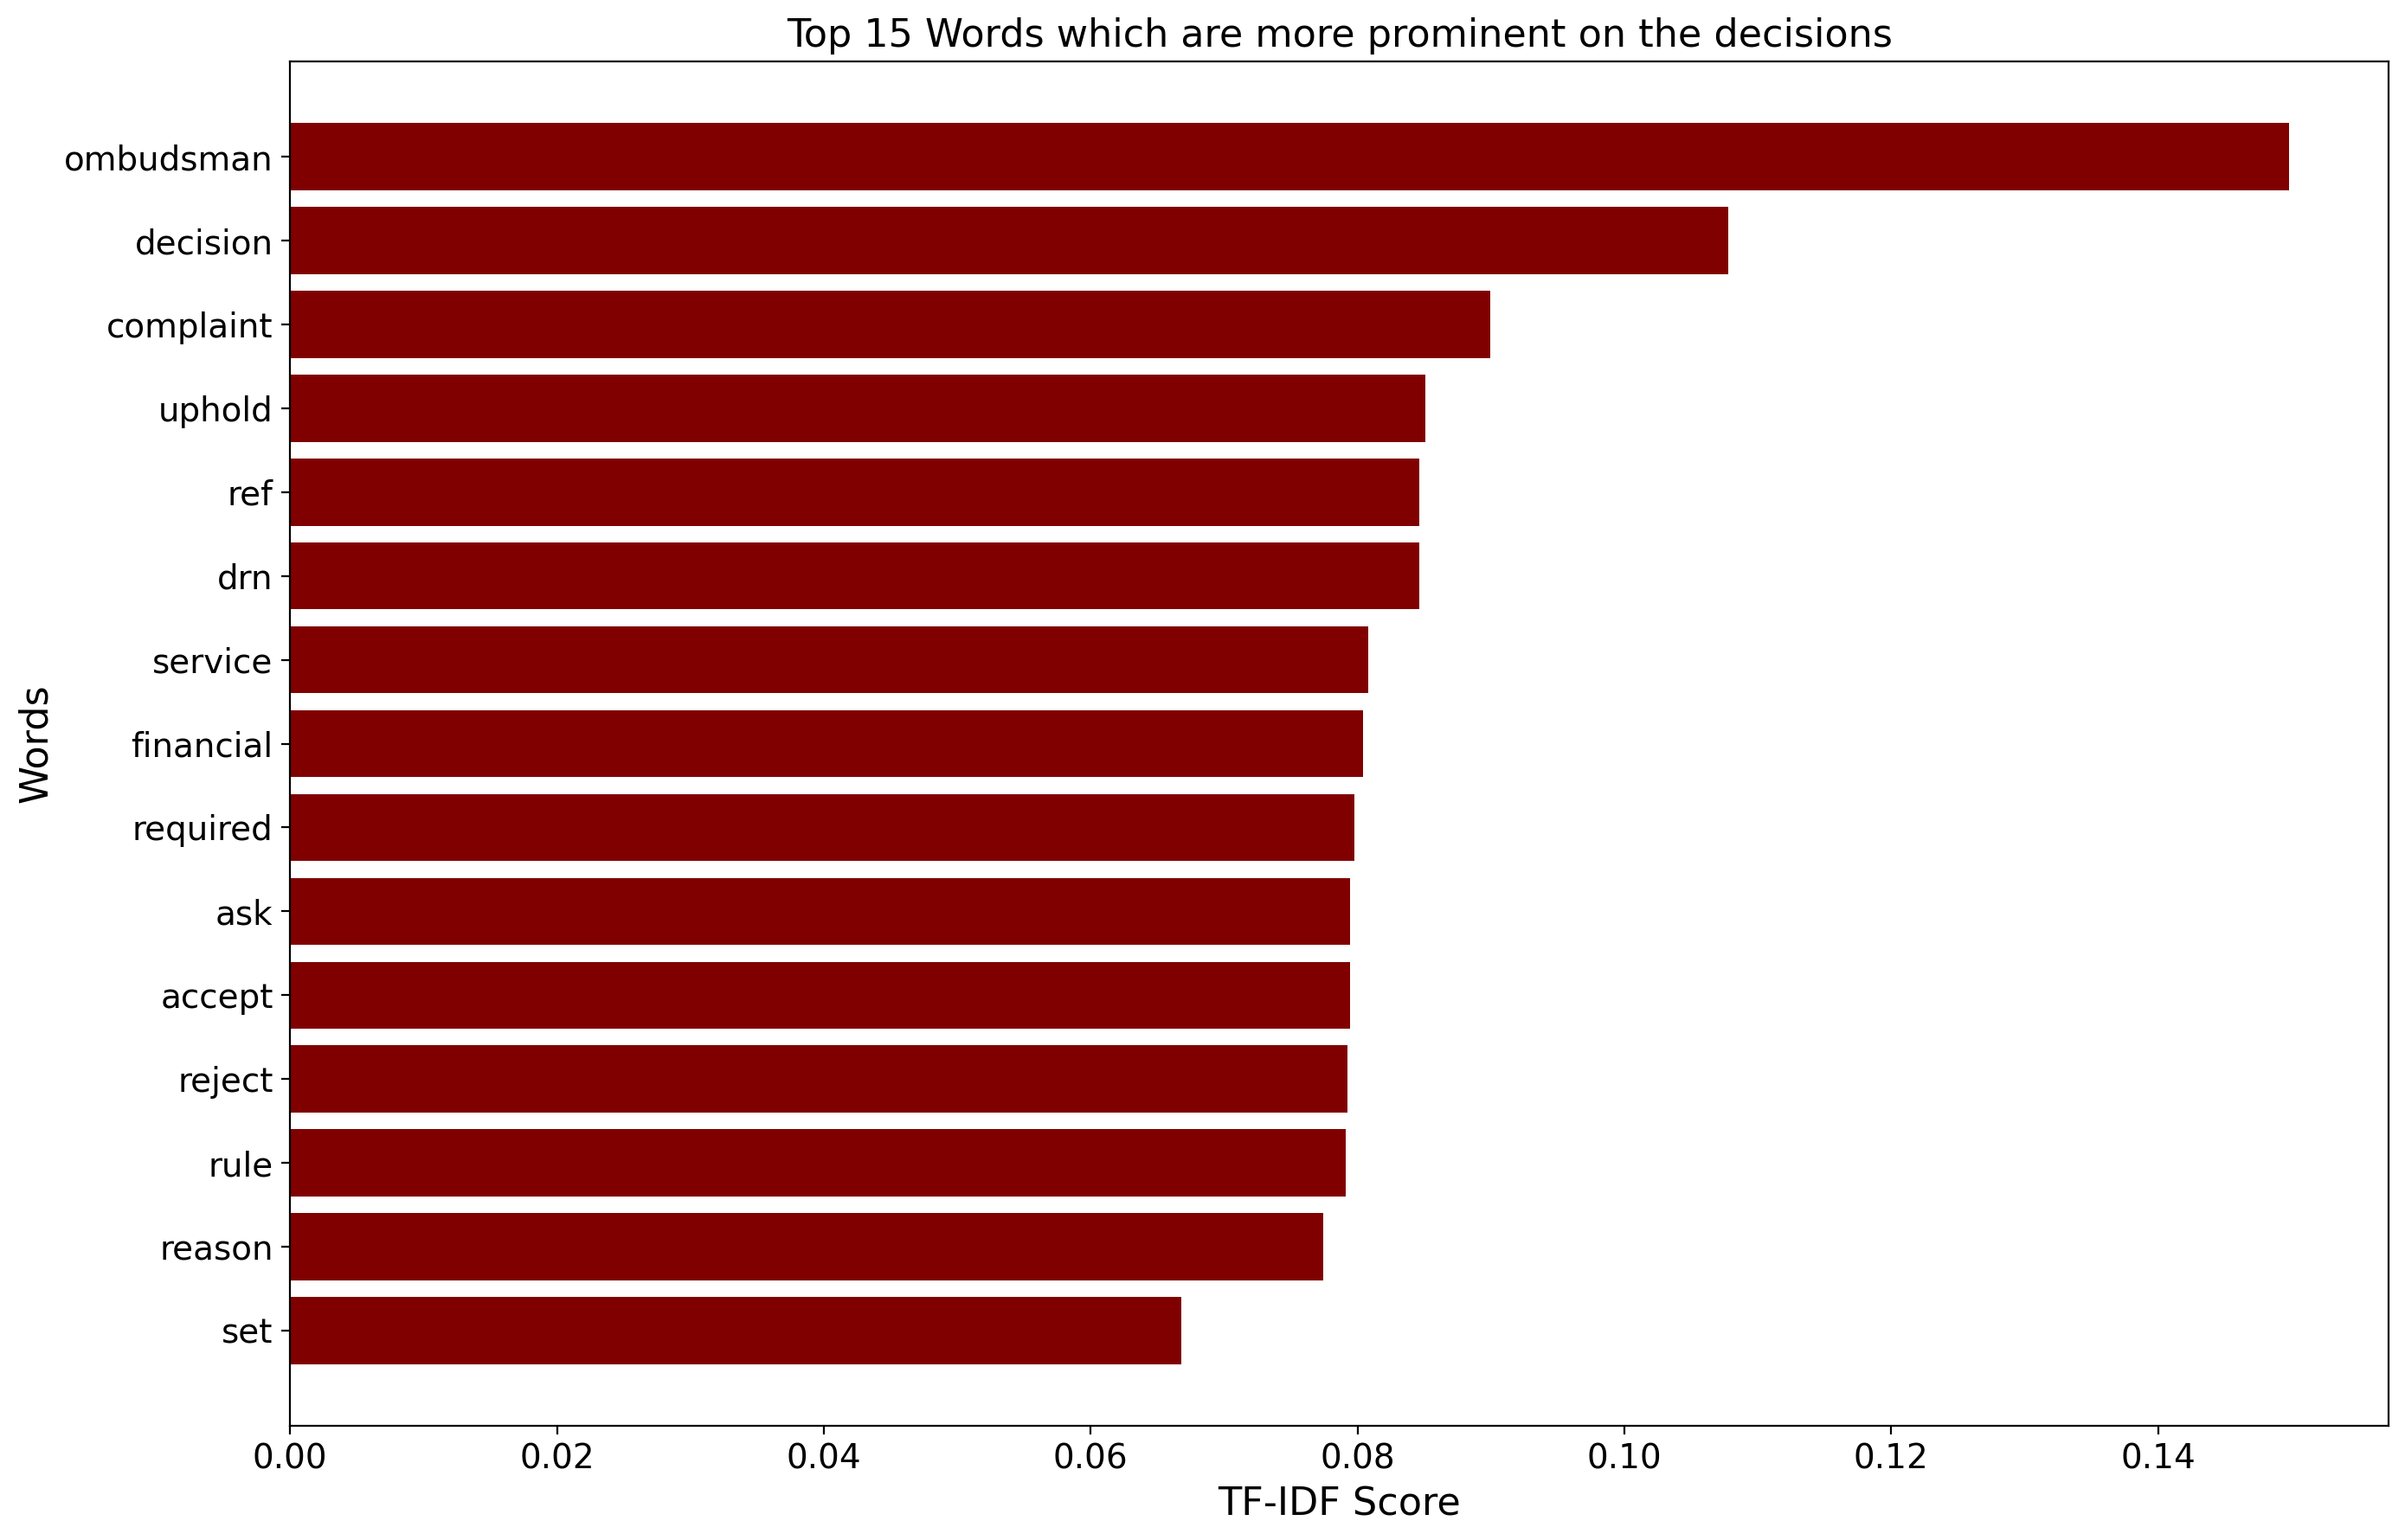

In [183]:
# Separate words and their corresponding scores
words, scores = zip(*top_15_omb_final_words)

# Plotting
plt.figure(figsize=(14,9), dpi = 200)
plt.barh(words, scores, color='maroon')
plt.xlabel('TF-IDF Score',fontsize = 16)
plt.ylabel('Words',fontsize = 16)
plt.title('Top 15 Words which are more prominent on the decisions', fontsize = 16)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest scores at the top


plt.xticks(fontsize=14) # Setting the size of the X axis values.
plt.yticks(fontsize=14) # Setting the size of the Y axis values.
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# ***FEATURE EXTRACTION TECHNIQUES***

## ***TFIDF METHOD***

In [184]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [185]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(new_df['complaint_data'])
y = new_df['decision'].apply(lambda x: 1 if x == 'Upheld' else 0)

In [186]:
# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print(tfidf_df.head())

    aa  able  abroad  accept  accepted  access  accident  accidental  \
0  0.0   0.0     0.0     0.0       0.0     0.0       0.0         0.0   
1  0.0   0.0     0.0     0.0       0.0     0.0       0.0         0.0   
2  0.0   0.0     0.0     0.0       0.0     0.0       0.0         0.0   
3  0.0   0.0     0.0     0.0       0.0     0.0       0.0         0.0   
4  0.0   0.0     0.0     0.0       0.0     0.0       0.0         0.0   

   accommodation  account  ...  working  worth  would  written  wrong  \
0            0.0      0.0  ...      0.0    0.0    0.0      0.0    0.0   
1            0.0      0.0  ...      0.0    0.0    0.0      0.0    0.0   
2            0.0      0.0  ...      0.0    0.0    0.0      0.0    0.0   
3            0.0      0.0  ...      0.0    0.0    0.0      0.0    0.0   
4            0.0      0.0  ...      0.0    0.0    0.0      0.0    0.0   

      wrote      year  yorkshire  zenith  zurich  
0  0.202347  0.000000        0.0     0.0     0.0  
1  0.000000  0.000000     

## ***WORD2VEC METHOD***

In [187]:
import gensim
from gensim.models import Word2Vec
import numpy as np

In [ ]:
# Tokenize the text data
tokenized_text = [text.split() for text in new_df['complaint_data']]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Function to get Word2Vec vectors
def get_word2vec_vectors(text, model, vector_size=100):
    words = text.split()
    vector = np.zeros(vector_size)
    count = 0
    for word in words:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

In [ ]:
# Create X and y for Word2Vec
X = np.array([get_word2vec_vectors(text, word2vec_model) for text in new_df['complaint_data']])
y = new_df['decision'].apply(lambda x: 1 if x == 'Upheld' else 0)


## ***GLOVE METHOD***

In [ ]:
import numpy as np

# Load GloVe vectors from the file present in the already det directory.
glove_path = 'glove.6B.100d.txt'
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
# Function to get GloVe vectors
def get_glove_vectors(text, embeddings_index, vector_size=100):
    words = text.split()
    vector = np.zeros(vector_size)
    count = 0
    for word in words:
        if word in embeddings_index:
            vector += embeddings_index[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

In [ ]:
# Create X and y for GloVe
X = np.array([get_glove_vectors(text, embeddings_index) for text in new_df['complaint_data']])
y = new_df['decision'].apply(lambda x: 1 if x == 'Upheld' else 0)

# ***MODELLING***

In [190]:
# Performing the 80-20 train test split
# 80% of records go into the train dataset where the remaining 20% of records into the test dataset.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [191]:
X_train.shape, X_test.shape

((128278, 1000), (32070, 1000))

## ***LOGISTC REGRESSION MODEL***

In [192]:
# Fitting the Logistic Regression model.

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [193]:
# Predictions on the test dataframe

y_logistic_pred = model.predict(X_test)

In [194]:
# Fetching the accuracy score.

accuracy_test = accuracy_score(y_test,y_logistic_pred)

In [195]:
# Fetching the precision, recall and F1- scores on the test dataset

precision_test = precision_score(y_test,y_logistic_pred)
recall_test = recall_score(y_test,y_logistic_pred)
f1_test = f1_score(y_test,y_logistic_pred)

In [196]:
# AUC-ROC Score
auc_roc = roc_auc_score(y_test, y_logistic_pred)

In [197]:
print(f'Test Accuracy: {accuracy_test}')

Test Accuracy: 0.7949797318366074


In [198]:
print(f'Test Precision: {precision_test}')
print(f'Test Recall: {recall_test}')
print(f'Test F1 Score: {f1_test}')

Test Precision: 0.7254191209787041
Test Recall: 0.6067266698247277
Test F1 Score: 0.6607852241655059


In [199]:
print(f"AUC-ROC Score: {auc_roc}")

AUC-ROC Score: 0.7470305438363704


In [200]:
y_test.value_counts()

decision
0    21515
1    10555
Name: count, dtype: int64

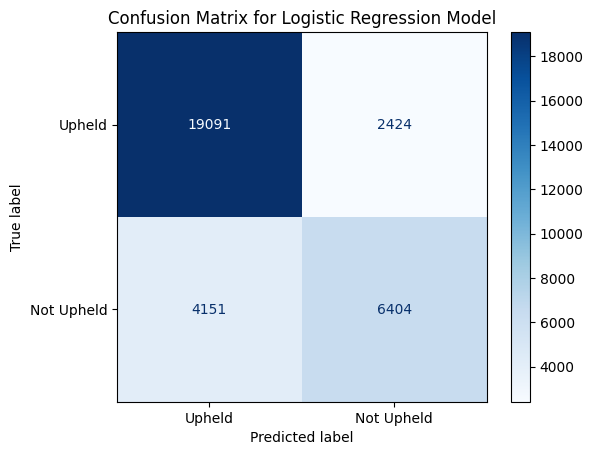

In [201]:
# Printing out the confusion matrix for the Logistic Regression model evaluated on the test dataset.

import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_logistic_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Upheld', 'Not Upheld'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

In [202]:
print("Classification Report:\n", classification_report(y_test, y_logistic_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85     21515
           1       0.73      0.61      0.66     10555

    accuracy                           0.79     32070
   macro avg       0.77      0.75      0.76     32070
weighted avg       0.79      0.79      0.79     32070



## ***RANDOM FOREST MODEL***

In [204]:
# Train a Random Forest model
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=500)
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [205]:
# Predict on the test set
y_pred_rand_model = random_forest_model.predict(X_test)

In [206]:
accuracy_rand_test = accuracy_score(y_test,y_pred_rand_model)

In [207]:
# Fetching the precision, recall and F1- scores on the test dataset

precision_rand_test = precision_score(y_test,y_pred_rand_model)
recall_rand_test = recall_score(y_test,y_pred_rand_model)
f1_rand_test = f1_score(y_test,y_pred_rand_model)

In [208]:
# AUC-ROC Score
auc_roc_rand_test = roc_auc_score(y_test, y_pred_rand_model)

In [209]:
print(f'Test Accuracy: {accuracy_rand_test}')

Test Accuracy: 0.8247583411287808


In [210]:
print(f'Test Precision: {precision_rand_test}')
print(f'Test Recall: {recall_rand_test}')
print(f'Test F1 Score: {f1_rand_test}')

Test Precision: 0.798043241937432
Test Recall: 0.6259592610137376
Test F1 Score: 0.7016034830625465


In [211]:
print(f"AUC-ROC Score: {auc_roc_rand_test}")

AUC-ROC Score: 0.7741230188405894


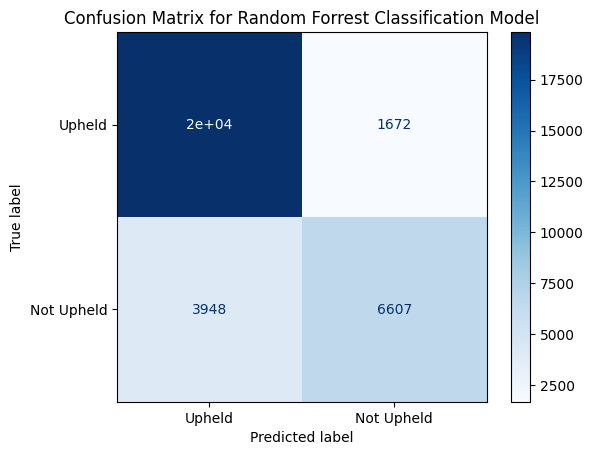

In [212]:
# Printing out the confusion matrix for the Random Forest model evaluated on the test dataset.

cm = confusion_matrix(y_test, y_pred_rand_model)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Upheld', 'Not Upheld'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forrest Classification Model')
plt.show()

## ***BERT MODEL***

In [228]:
# Preparing the raw data corpus encompassing the complaint information.
# Passing the raw ( non preprocessed) text is essential for BERT to capture the bidirectional dependencies effectively..

complaint_columns = ['complaint_info','complaint_explanation']
df['complaint_data'] = df[complaint_columns].apply(lambda x: ' '.join(x), axis=1)

In [229]:
# Label encoding
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['decision'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['complaint_data'], df['label'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Tokenizer and Model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [230]:
# Custom Function for performing BERT tokenization.

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [231]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CustomDataset(
        texts=df['complaint_data'].to_numpy(),
        labels=df['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [232]:
# Generating data loaders on the train, val and test dataset.
BATCH_SIZE = 16
MAX_LEN = 128

train_data_loader = create_data_loader(pd.DataFrame({'complaint_data': X_train, 'label': y_train}), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(pd.DataFrame({'complaint_data': X_val, 'label': y_val}), tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(pd.DataFrame({'complaint_data': X_test, 'label': y_test}), tokenizer, MAX_LEN, BATCH_SIZE)

In [233]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

EPOCHS = 1
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [234]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        loss = loss_fn(outputs.logits, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [235]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            loss = loss_fn(outputs.logits, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [236]:
# Training the model

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        None,
        len(X_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(X_val)
    )

    print(f'Val loss {val_loss} accuracy {val_acc}')

Epoch 1/1
----------


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Train loss 0.45367027679760286 accuracy 0.7619012971894229


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Val loss 0.42046990532270095 accuracy 0.784128468974119


In [237]:
# Evaluate on the test set
test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(X_test)
)
print(f'Test loss {test_loss} accuracy {test_acc}')

# Predict on the test set
model = model.eval()
y_pred_bert_torch = []
y_true_bert_torch = []

with torch.no_grad():
    for d in test_data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        y_pred_bert_torch.extend(preds)
        y_true_bert_torch.extend(labels)



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

Test loss 0.42666269231615517 accuracy 0.7811661989398191


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

In [238]:
# Convert to numpy arrays
y_pred_bert_torch = torch.stack(y_pred_bert_torch).cpu().numpy()
y_true_bert_torch = torch.stack(y_true_bert_torch).cpu().numpy()


In [240]:
# Fetching the precision, recall and F1 scores on the test dataset.

precision_test_bert = precision_score(y_pred_bert_torch,y_true_bert_torch)
recall_test_bert = recall_score(y_pred_bert_torch,y_true_bert_torch)
f1_test_bert = f1_score(y_pred_bert_torch,y_true_bert_torch)

In [241]:
auc_roc_test_bert = roc_auc_score(y_true_bert_torch, y_pred_bert_torch)

In [242]:
accuracy_test_bert = accuracy_score(y_true_bert_torch,y_pred_bert_torch)

In [243]:
print(f'Test Accuracy: {accuracy_test_bert}')

Test Accuracy: 0.7811661989398192


In [244]:
print(f'Test Precision: {precision_test_bert}')
print(f'Test Recall: {recall_test_bert}')
print(f'Test F1 Score: {f1_test_bert}')

Test Precision: 0.4414021790620559
Test Recall: 0.8059159314997405
Test F1 Score: 0.5703966699314398


In [245]:
print(f"AUC-ROC Score: {auc_roc_test_bert}")

AUC-ROC Score: 0.69462625801813


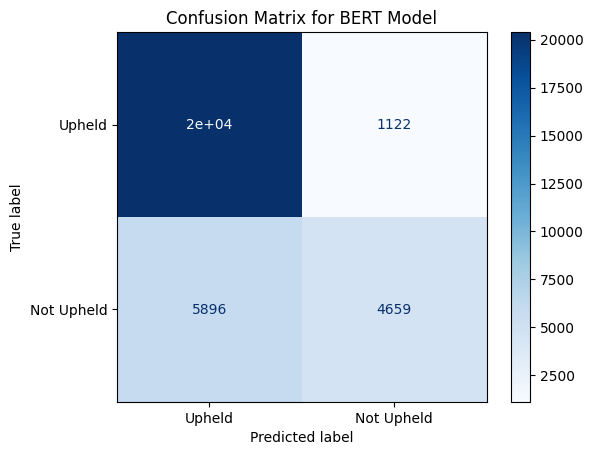

In [246]:
# Plotting the confusion matrix.

cm = confusion_matrix(y_true_bert_torch,y_pred_bert_torch)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Upheld', 'Not Upheld'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for BERT Model')
plt.show()

In [247]:
# Classification report
print(classification_report(y_true_bert_torch, y_pred_bert_torch, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

  Not upheld       0.78      0.95      0.85     21515
      Upheld       0.81      0.44      0.57     10555

    accuracy                           0.78     32070
   macro avg       0.79      0.69      0.71     32070
weighted avg       0.79      0.78      0.76     32070

